# Afriat

In [1]:
ood_seed = 14

In [2]:
num_ood = 1  # not functioning

In [3]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import label_transfer
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [5]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "biolord_afriat.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata

AnnData object with n_obs × n_vars = 19053 × 5000
    obs: 'mouse', 'experiment', 'time_int', 'time_cat', 'zone', 'status_control'

In [6]:
df = adata.obs.groupby(['time_cat', 'zone', 'status_control']).size()
availables = list(df[df>100].index)
availables, len(availables)

([('0.0', 'Pericentral', 'Control'),
  ('0.0', 'Periportal', 'Control'),
  ('12.0', 'Pericentral', 'Infected'),
  ('12.0', 'Pericentral', 'Uninfected'),
  ('12.0', 'Periportal', 'Infected'),
  ('12.0', 'Periportal', 'Uninfected'),
  ('2.0', 'Pericentral', 'Uninfected'),
  ('2.0', 'Periportal', 'Infected'),
  ('2.0', 'Periportal', 'Uninfected'),
  ('24.0', 'Pericentral', 'Infected'),
  ('24.0', 'Pericentral', 'Uninfected'),
  ('24.0', 'Periportal', 'Infected'),
  ('24.0', 'Periportal', 'Uninfected'),
  ('30.0', 'Pericentral', 'Infected'),
  ('30.0', 'Pericentral', 'Uninfected'),
  ('30.0', 'Periportal', 'Infected'),
  ('30.0', 'Periportal', 'Uninfected'),
  ('36.0', 'Pericentral', 'Infected'),
  ('36.0', 'Pericentral', 'Uninfected'),
  ('36.0', 'Periportal', 'Infected'),
  ('36.0', 'Periportal', 'Uninfected')],
 21)

In [7]:
def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["time_cat"] == choice[0]) & (adata.obs["zone"] == choice[1]) & (adata.obs["status_control"] == choice[2]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

adata, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

('30.0', 'Pericentral', 'Uninfected')

Removed datapoint: 597


In [8]:
warmup_epoch_range = [6, 48]
dtc_w1 = 100
dtc_w2 = 10

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

disentenglement_targets_configurations=[
    dict(
        obs_key = "status_control",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    ),
    dict(
        obs_key = "time_cat",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    ),
    dict(
        obs_key = "zone",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    )
]

In [9]:
n_epochs_kl_warmup = 600

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=(24 + 8 * len(disentenglement_targets_configurations)),
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.25,
    deeply_inject_disentengled_latents = True,
    include_auxillary_loss = True,
    beta_kl_weight = 0.5,
    encode_covariates = False,
)

train_params = dict(
    max_epochs=600,
    train_size=0.8,
    batch_size=128,
    check_val_every_n_epoch=10,
    limit_train_batches=1.0, 
    limit_val_batches=1.0,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=False,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=1e-4,
        weight_decay=1e-4,
        optimizer="AdamW",
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    )
)

dataset_params = dict(
    layer=None, 
    labels_key=None,
    batch_key=None,
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations,
    model_level_metrics=None,
    model_level_metrics_helper_covariates=None
)

tardis.MyModel.setup_anndata(adata, **dataset_params)
dataset_params["adata_path"] = adata_file_path
dataset_params["adata"] = os.path.split(adata_file_path)[1]

tardis.MyModel.setup_wandb(
    wandb_configurations=tardis.config.wandb,
    hyperparams=dict(
        model_params=model_params,
        train_params=train_params,
        dataset_params=dataset_params,
    )
)

vae = tardis.MyModel(
    adata,
    **model_params
)
vae.train(**train_params)

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


W&B logger initialized with the following parameters: 
Entity: inecik-academic
Project: tardis_conference
ID: fqhclco5
Name: old-cruiser-181
Tags: tardis, conference, figures, final
Notes: Final runs for Tardis before conference.
URL: https://wandb.ai/inecik-academic/tardis_conference/runs/fqhclco5
Directory: /lustre/groups/ml01/workspace/kemal.inecik/wandb/run-20240504_212226-fqhclco5/files



/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/600:   0%|          | 0/600 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `status_control` for `training` set. Number of elements in each group: 2533,3295,8937
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `time_cat` for `training` set. Number of elements in each group: 2533,2542,1724,3430,1176,3360
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `zone` for `training` set. Number of elements in each group: 4008,10757
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `status_control` for `validation` set. Number of elements in each group: 672,814,2205
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `time_cat` for `validation` set. Number of elements in each group: 672,660,384,860,276,839
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `zone` for `validation` set. Number of elements in each group: 979,2712
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 1/600:   0%|          | 1/600 [00:11<1:59:37, 11.98s/it]

Epoch 1/600:   0%|          | 1/600 [00:11<1:59:37, 11.98s/it, v_num=o5_1, total_loss_train=3.72e+3, kl_local_train=54.1]

Epoch 2/600:   0%|          | 1/600 [00:12<1:59:37, 11.98s/it, v_num=o5_1, total_loss_train=3.72e+3, kl_local_train=54.1]

Epoch 2/600:   0%|          | 2/600 [00:22<1:52:16, 11.26s/it, v_num=o5_1, total_loss_train=3.72e+3, kl_local_train=54.1]

Epoch 2/600:   0%|          | 2/600 [00:22<1:52:16, 11.26s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=79.2]

Epoch 3/600:   0%|          | 2/600 [00:22<1:52:16, 11.26s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=79.2]

Epoch 3/600:   0%|          | 3/600 [00:33<1:49:31, 11.01s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=79.2]

Epoch 3/600:   0%|          | 3/600 [00:33<1:49:31, 11.01s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=79.6]

Epoch 4/600:   0%|          | 3/600 [00:33<1:49:31, 11.01s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=79.6]

Epoch 4/600:   1%|          | 4/600 [00:44<1:47:49, 10.86s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=79.6]

Epoch 4/600:   1%|          | 4/600 [00:44<1:47:49, 10.86s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=76.2]

Epoch 5/600:   1%|          | 4/600 [00:44<1:47:49, 10.86s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=76.2]

Epoch 5/600:   1%|          | 5/600 [00:54<1:46:50, 10.77s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=76.2]

Epoch 5/600:   1%|          | 5/600 [00:54<1:46:50, 10.77s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=69.9]

Epoch 6/600:   1%|          | 5/600 [00:54<1:46:50, 10.77s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=69.9]

Epoch 6/600:   1%|          | 6/600 [01:05<1:46:15, 10.73s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=69.9]

Epoch 6/600:   1%|          | 6/600 [01:05<1:46:15, 10.73s/it, v_num=o5_1, total_loss_train=3.21e+3, kl_local_train=60.9]

Epoch 7/600:   1%|          | 6/600 [01:05<1:46:15, 10.73s/it, v_num=o5_1, total_loss_train=3.21e+3, kl_local_train=60.9]

Epoch 7/600:   1%|          | 7/600 [01:16<1:46:15, 10.75s/it, v_num=o5_1, total_loss_train=3.21e+3, kl_local_train=60.9]

Epoch 7/600:   1%|          | 7/600 [01:16<1:46:15, 10.75s/it, v_num=o5_1, total_loss_train=3.21e+3, kl_local_train=49.4]

Epoch 8/600:   1%|          | 7/600 [01:16<1:46:15, 10.75s/it, v_num=o5_1, total_loss_train=3.21e+3, kl_local_train=49.4]

Epoch 8/600:   1%|▏         | 8/600 [01:26<1:46:09, 10.76s/it, v_num=o5_1, total_loss_train=3.21e+3, kl_local_train=49.4]

Epoch 8/600:   1%|▏         | 8/600 [01:26<1:46:09, 10.76s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=34.2]

Epoch 9/600:   1%|▏         | 8/600 [01:26<1:46:09, 10.76s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=34.2]

Epoch 9/600:   2%|▏         | 9/600 [01:37<1:46:01, 10.76s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=34.2]

Epoch 9/600:   2%|▏         | 9/600 [01:37<1:46:01, 10.76s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=26.2]

Epoch 10/600:   2%|▏         | 9/600 [01:37<1:46:01, 10.76s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=26.2]

Epoch 10/600:   2%|▏         | 10/600 [01:48<1:45:49, 10.76s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=26.2]

Epoch 10/600:   2%|▏         | 10/600 [01:48<1:45:49, 10.76s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=45.8]

Epoch 11/600:   2%|▏         | 10/600 [01:48<1:45:49, 10.76s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=45.8]

Epoch 11/600:   2%|▏         | 11/600 [01:59<1:45:31, 10.75s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=45.8]

Epoch 11/600:   2%|▏         | 11/600 [01:59<1:45:31, 10.75s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=122] 

Epoch 12/600:   2%|▏         | 11/600 [01:59<1:45:31, 10.75s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=122]

Epoch 12/600:   2%|▏         | 12/600 [02:09<1:45:12, 10.74s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=122]

Epoch 12/600:   2%|▏         | 12/600 [02:09<1:45:12, 10.74s/it, v_num=o5_1, total_loss_train=3.21e+3, kl_local_train=215]

Epoch 13/600:   2%|▏         | 12/600 [02:09<1:45:12, 10.74s/it, v_num=o5_1, total_loss_train=3.21e+3, kl_local_train=215]

Epoch 13/600:   2%|▏         | 13/600 [02:20<1:45:07, 10.75s/it, v_num=o5_1, total_loss_train=3.21e+3, kl_local_train=215]

Epoch 13/600:   2%|▏         | 13/600 [02:20<1:45:07, 10.75s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=281]

Epoch 14/600:   2%|▏         | 13/600 [02:20<1:45:07, 10.75s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=281]

Epoch 14/600:   2%|▏         | 14/600 [02:31<1:45:02, 10.76s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=281]

Epoch 14/600:   2%|▏         | 14/600 [02:31<1:45:02, 10.76s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=334]

Epoch 15/600:   2%|▏         | 14/600 [02:31<1:45:02, 10.76s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=334]

Epoch 15/600:   2%|▎         | 15/600 [02:42<1:44:49, 10.75s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=334]

Epoch 15/600:   2%|▎         | 15/600 [02:42<1:44:49, 10.75s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=385]

Epoch 16/600:   2%|▎         | 15/600 [02:42<1:44:49, 10.75s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=385]

Epoch 16/600:   3%|▎         | 16/600 [02:52<1:44:53, 10.78s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=385]

Epoch 16/600:   3%|▎         | 16/600 [02:52<1:44:53, 10.78s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=462]

Epoch 17/600:   3%|▎         | 16/600 [02:53<1:44:53, 10.78s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=462]

Epoch 17/600:   3%|▎         | 17/600 [03:03<1:44:50, 10.79s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=462]

Epoch 17/600:   3%|▎         | 17/600 [03:03<1:44:50, 10.79s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=561]

Epoch 18/600:   3%|▎         | 17/600 [03:03<1:44:50, 10.79s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=561]

Epoch 18/600:   3%|▎         | 18/600 [03:14<1:44:46, 10.80s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=561]

Epoch 18/600:   3%|▎         | 18/600 [03:14<1:44:46, 10.80s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=631]

Epoch 19/600:   3%|▎         | 18/600 [03:14<1:44:46, 10.80s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=631]

Epoch 19/600:   3%|▎         | 19/600 [03:25<1:44:33, 10.80s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=631]

Epoch 19/600:   3%|▎         | 19/600 [03:25<1:44:33, 10.80s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=629]

Epoch 20/600:   3%|▎         | 19/600 [03:25<1:44:33, 10.80s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=629]

Epoch 20/600:   3%|▎         | 20/600 [03:36<1:44:20, 10.79s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=629]

Epoch 20/600:   3%|▎         | 20/600 [03:36<1:44:20, 10.79s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=646]

Epoch 21/600:   3%|▎         | 20/600 [03:36<1:44:20, 10.79s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=646]

Epoch 21/600:   4%|▎         | 21/600 [03:47<1:44:10, 10.79s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=646]

Epoch 21/600:   4%|▎         | 21/600 [03:47<1:44:10, 10.79s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=637]

Epoch 22/600:   4%|▎         | 21/600 [03:47<1:44:10, 10.79s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=637]

Epoch 22/600:   4%|▎         | 22/600 [03:57<1:43:59, 10.79s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=637]

Epoch 22/600:   4%|▎         | 22/600 [03:57<1:43:59, 10.79s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=622]

Epoch 23/600:   4%|▎         | 22/600 [03:57<1:43:59, 10.79s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=622]

Epoch 23/600:   4%|▍         | 23/600 [04:08<1:43:54, 10.80s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=622]

Epoch 23/600:   4%|▍         | 23/600 [04:08<1:43:54, 10.80s/it, v_num=o5_1, total_loss_train=3.24e+3, kl_local_train=615]

Epoch 24/600:   4%|▍         | 23/600 [04:08<1:43:54, 10.80s/it, v_num=o5_1, total_loss_train=3.24e+3, kl_local_train=615]

Epoch 24/600:   4%|▍         | 24/600 [04:19<1:43:34, 10.79s/it, v_num=o5_1, total_loss_train=3.24e+3, kl_local_train=615]

Epoch 24/600:   4%|▍         | 24/600 [04:19<1:43:34, 10.79s/it, v_num=o5_1, total_loss_train=3.24e+3, kl_local_train=629]

Epoch 25/600:   4%|▍         | 24/600 [04:19<1:43:34, 10.79s/it, v_num=o5_1, total_loss_train=3.24e+3, kl_local_train=629]

Epoch 25/600:   4%|▍         | 25/600 [04:30<1:43:27, 10.80s/it, v_num=o5_1, total_loss_train=3.24e+3, kl_local_train=629]

Epoch 25/600:   4%|▍         | 25/600 [04:30<1:43:27, 10.80s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=575]

Epoch 26/600:   4%|▍         | 25/600 [04:30<1:43:27, 10.80s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=575]

Epoch 26/600:   4%|▍         | 26/600 [04:40<1:43:12, 10.79s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=575]

Epoch 26/600:   4%|▍         | 26/600 [04:40<1:43:12, 10.79s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=477]

Epoch 27/600:   4%|▍         | 26/600 [04:40<1:43:12, 10.79s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=477]

Epoch 27/600:   4%|▍         | 27/600 [04:51<1:42:51, 10.77s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=477]

Epoch 27/600:   4%|▍         | 27/600 [04:51<1:42:51, 10.77s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=440]

Epoch 28/600:   4%|▍         | 27/600 [04:51<1:42:51, 10.77s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=440]

Epoch 28/600:   5%|▍         | 28/600 [05:02<1:42:43, 10.77s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=440]

Epoch 28/600:   5%|▍         | 28/600 [05:02<1:42:43, 10.77s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=384]

Epoch 29/600:   5%|▍         | 28/600 [05:02<1:42:43, 10.77s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=384]

Epoch 29/600:   5%|▍         | 29/600 [05:13<1:42:22, 10.76s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=384]

Epoch 29/600:   5%|▍         | 29/600 [05:13<1:42:22, 10.76s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=378]

Epoch 30/600:   5%|▍         | 29/600 [05:13<1:42:22, 10.76s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=378]

Epoch 30/600:   5%|▌         | 30/600 [05:23<1:41:57, 10.73s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=378]

Epoch 30/600:   5%|▌         | 30/600 [05:23<1:41:57, 10.73s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=326]

Epoch 31/600:   5%|▌         | 30/600 [05:23<1:41:57, 10.73s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=326]

Epoch 31/600:   5%|▌         | 31/600 [05:34<1:41:35, 10.71s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=326]

Epoch 31/600:   5%|▌         | 31/600 [05:34<1:41:35, 10.71s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=297]

Epoch 32/600:   5%|▌         | 31/600 [05:34<1:41:35, 10.71s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=297]

Epoch 32/600:   5%|▌         | 32/600 [05:45<1:41:25, 10.71s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=297]

Epoch 32/600:   5%|▌         | 32/600 [05:45<1:41:25, 10.71s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=266]

Epoch 33/600:   5%|▌         | 32/600 [05:45<1:41:25, 10.71s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=266]

Epoch 33/600:   6%|▌         | 33/600 [05:55<1:41:08, 10.70s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=266]

Epoch 33/600:   6%|▌         | 33/600 [05:55<1:41:08, 10.70s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=244]

Epoch 34/600:   6%|▌         | 33/600 [05:55<1:41:08, 10.70s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=244]

Epoch 34/600:   6%|▌         | 34/600 [06:06<1:40:57, 10.70s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=244]

Epoch 34/600:   6%|▌         | 34/600 [06:06<1:40:57, 10.70s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=237]

Epoch 35/600:   6%|▌         | 34/600 [06:06<1:40:57, 10.70s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=237]

Epoch 35/600:   6%|▌         | 35/600 [06:17<1:40:47, 10.70s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=237]

Epoch 35/600:   6%|▌         | 35/600 [06:17<1:40:47, 10.70s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=225]

Epoch 36/600:   6%|▌         | 35/600 [06:17<1:40:47, 10.70s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=225]

Epoch 36/600:   6%|▌         | 36/600 [06:28<1:40:40, 10.71s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=225]

Epoch 36/600:   6%|▌         | 36/600 [06:28<1:40:40, 10.71s/it, v_num=o5_1, total_loss_train=3.24e+3, kl_local_train=224]

Epoch 37/600:   6%|▌         | 36/600 [06:28<1:40:40, 10.71s/it, v_num=o5_1, total_loss_train=3.24e+3, kl_local_train=224]

Epoch 37/600:   6%|▌         | 37/600 [06:38<1:40:36, 10.72s/it, v_num=o5_1, total_loss_train=3.24e+3, kl_local_train=224]

Epoch 37/600:   6%|▌         | 37/600 [06:38<1:40:36, 10.72s/it, v_num=o5_1, total_loss_train=3.24e+3, kl_local_train=222]

Epoch 38/600:   6%|▌         | 37/600 [06:38<1:40:36, 10.72s/it, v_num=o5_1, total_loss_train=3.24e+3, kl_local_train=222]

Epoch 38/600:   6%|▋         | 38/600 [06:49<1:40:21, 10.71s/it, v_num=o5_1, total_loss_train=3.24e+3, kl_local_train=222]

Epoch 38/600:   6%|▋         | 38/600 [06:49<1:40:21, 10.71s/it, v_num=o5_1, total_loss_train=3.24e+3, kl_local_train=213]

Epoch 39/600:   6%|▋         | 38/600 [06:49<1:40:21, 10.71s/it, v_num=o5_1, total_loss_train=3.24e+3, kl_local_train=213]

Epoch 39/600:   6%|▋         | 39/600 [07:00<1:40:35, 10.76s/it, v_num=o5_1, total_loss_train=3.24e+3, kl_local_train=213]

Epoch 39/600:   6%|▋         | 39/600 [07:00<1:40:35, 10.76s/it, v_num=o5_1, total_loss_train=3.24e+3, kl_local_train=217]

Epoch 40/600:   6%|▋         | 39/600 [07:00<1:40:35, 10.76s/it, v_num=o5_1, total_loss_train=3.24e+3, kl_local_train=217]

Epoch 40/600:   7%|▋         | 40/600 [07:11<1:40:03, 10.72s/it, v_num=o5_1, total_loss_train=3.24e+3, kl_local_train=217]

Epoch 40/600:   7%|▋         | 40/600 [07:11<1:40:03, 10.72s/it, v_num=o5_1, total_loss_train=3.24e+3, kl_local_train=208]

Epoch 41/600:   7%|▋         | 40/600 [07:11<1:40:03, 10.72s/it, v_num=o5_1, total_loss_train=3.24e+3, kl_local_train=208]

Epoch 41/600:   7%|▋         | 41/600 [07:21<1:39:47, 10.71s/it, v_num=o5_1, total_loss_train=3.24e+3, kl_local_train=208]

Epoch 41/600:   7%|▋         | 41/600 [07:21<1:39:47, 10.71s/it, v_num=o5_1, total_loss_train=3.25e+3, kl_local_train=206]

Epoch 42/600:   7%|▋         | 41/600 [07:21<1:39:47, 10.71s/it, v_num=o5_1, total_loss_train=3.25e+3, kl_local_train=206]

Epoch 42/600:   7%|▋         | 42/600 [07:32<1:39:29, 10.70s/it, v_num=o5_1, total_loss_train=3.25e+3, kl_local_train=206]

Epoch 42/600:   7%|▋         | 42/600 [07:32<1:39:29, 10.70s/it, v_num=o5_1, total_loss_train=3.25e+3, kl_local_train=212]

Epoch 43/600:   7%|▋         | 42/600 [07:32<1:39:29, 10.70s/it, v_num=o5_1, total_loss_train=3.25e+3, kl_local_train=212]

Epoch 43/600:   7%|▋         | 43/600 [07:43<1:39:16, 10.69s/it, v_num=o5_1, total_loss_train=3.25e+3, kl_local_train=212]

Epoch 43/600:   7%|▋         | 43/600 [07:43<1:39:16, 10.69s/it, v_num=o5_1, total_loss_train=3.25e+3, kl_local_train=214]

Epoch 44/600:   7%|▋         | 43/600 [07:43<1:39:16, 10.69s/it, v_num=o5_1, total_loss_train=3.25e+3, kl_local_train=214]

Epoch 44/600:   7%|▋         | 44/600 [07:53<1:39:00, 10.68s/it, v_num=o5_1, total_loss_train=3.25e+3, kl_local_train=214]

Epoch 44/600:   7%|▋         | 44/600 [07:53<1:39:00, 10.68s/it, v_num=o5_1, total_loss_train=3.25e+3, kl_local_train=215]

Epoch 45/600:   7%|▋         | 44/600 [07:53<1:39:00, 10.68s/it, v_num=o5_1, total_loss_train=3.25e+3, kl_local_train=215]

Epoch 45/600:   8%|▊         | 45/600 [08:04<1:38:49, 10.68s/it, v_num=o5_1, total_loss_train=3.25e+3, kl_local_train=215]

Epoch 45/600:   8%|▊         | 45/600 [08:04<1:38:49, 10.68s/it, v_num=o5_1, total_loss_train=3.26e+3, kl_local_train=214]

Epoch 46/600:   8%|▊         | 45/600 [08:04<1:38:49, 10.68s/it, v_num=o5_1, total_loss_train=3.26e+3, kl_local_train=214]

Epoch 46/600:   8%|▊         | 46/600 [08:15<1:38:36, 10.68s/it, v_num=o5_1, total_loss_train=3.26e+3, kl_local_train=214]

Epoch 46/600:   8%|▊         | 46/600 [08:15<1:38:36, 10.68s/it, v_num=o5_1, total_loss_train=3.26e+3, kl_local_train=214]

Epoch 47/600:   8%|▊         | 46/600 [08:15<1:38:36, 10.68s/it, v_num=o5_1, total_loss_train=3.26e+3, kl_local_train=214]

Epoch 47/600:   8%|▊         | 47/600 [08:25<1:38:21, 10.67s/it, v_num=o5_1, total_loss_train=3.26e+3, kl_local_train=214]

Epoch 47/600:   8%|▊         | 47/600 [08:25<1:38:21, 10.67s/it, v_num=o5_1, total_loss_train=3.26e+3, kl_local_train=220]

Epoch 48/600:   8%|▊         | 47/600 [08:25<1:38:21, 10.67s/it, v_num=o5_1, total_loss_train=3.26e+3, kl_local_train=220]

Epoch 48/600:   8%|▊         | 48/600 [08:36<1:38:16, 10.68s/it, v_num=o5_1, total_loss_train=3.26e+3, kl_local_train=220]

Epoch 48/600:   8%|▊         | 48/600 [08:36<1:38:16, 10.68s/it, v_num=o5_1, total_loss_train=3.26e+3, kl_local_train=218]

Epoch 49/600:   8%|▊         | 48/600 [08:36<1:38:16, 10.68s/it, v_num=o5_1, total_loss_train=3.26e+3, kl_local_train=218]

Epoch 49/600:   8%|▊         | 49/600 [08:47<1:38:06, 10.68s/it, v_num=o5_1, total_loss_train=3.26e+3, kl_local_train=218]

Epoch 49/600:   8%|▊         | 49/600 [08:47<1:38:06, 10.68s/it, v_num=o5_1, total_loss_train=3.26e+3, kl_local_train=216]

Epoch 50/600:   8%|▊         | 49/600 [08:47<1:38:06, 10.68s/it, v_num=o5_1, total_loss_train=3.26e+3, kl_local_train=216]

Epoch 50/600:   8%|▊         | 50/600 [08:57<1:37:50, 10.67s/it, v_num=o5_1, total_loss_train=3.26e+3, kl_local_train=216]

Epoch 50/600:   8%|▊         | 50/600 [08:57<1:37:50, 10.67s/it, v_num=o5_1, total_loss_train=3.27e+3, kl_local_train=213]

Epoch 51/600:   8%|▊         | 50/600 [08:57<1:37:50, 10.67s/it, v_num=o5_1, total_loss_train=3.27e+3, kl_local_train=213]

Epoch 51/600:   8%|▊         | 51/600 [09:08<1:37:39, 10.67s/it, v_num=o5_1, total_loss_train=3.27e+3, kl_local_train=213]

Epoch 51/600:   8%|▊         | 51/600 [09:08<1:37:39, 10.67s/it, v_num=o5_1, total_loss_train=3.26e+3, kl_local_train=215]

Epoch 52/600:   8%|▊         | 51/600 [09:08<1:37:39, 10.67s/it, v_num=o5_1, total_loss_train=3.26e+3, kl_local_train=215]

Epoch 52/600:   9%|▊         | 52/600 [09:19<1:37:32, 10.68s/it, v_num=o5_1, total_loss_train=3.26e+3, kl_local_train=215]

Epoch 52/600:   9%|▊         | 52/600 [09:19<1:37:32, 10.68s/it, v_num=o5_1, total_loss_train=3.26e+3, kl_local_train=217]

Epoch 53/600:   9%|▊         | 52/600 [09:19<1:37:32, 10.68s/it, v_num=o5_1, total_loss_train=3.26e+3, kl_local_train=217]

Epoch 53/600:   9%|▉         | 53/600 [09:29<1:37:17, 10.67s/it, v_num=o5_1, total_loss_train=3.26e+3, kl_local_train=217]

Epoch 53/600:   9%|▉         | 53/600 [09:29<1:37:17, 10.67s/it, v_num=o5_1, total_loss_train=3.26e+3, kl_local_train=208]

Epoch 54/600:   9%|▉         | 53/600 [09:29<1:37:17, 10.67s/it, v_num=o5_1, total_loss_train=3.26e+3, kl_local_train=208]

Epoch 54/600:   9%|▉         | 54/600 [09:40<1:36:54, 10.65s/it, v_num=o5_1, total_loss_train=3.26e+3, kl_local_train=208]

Epoch 54/600:   9%|▉         | 54/600 [09:40<1:36:54, 10.65s/it, v_num=o5_1, total_loss_train=3.25e+3, kl_local_train=201]

Epoch 55/600:   9%|▉         | 54/600 [09:40<1:36:54, 10.65s/it, v_num=o5_1, total_loss_train=3.25e+3, kl_local_train=201]

Epoch 55/600:   9%|▉         | 55/600 [09:51<1:36:42, 10.65s/it, v_num=o5_1, total_loss_train=3.25e+3, kl_local_train=201]

Epoch 55/600:   9%|▉         | 55/600 [09:51<1:36:42, 10.65s/it, v_num=o5_1, total_loss_train=3.25e+3, kl_local_train=197]

Epoch 56/600:   9%|▉         | 55/600 [09:51<1:36:42, 10.65s/it, v_num=o5_1, total_loss_train=3.25e+3, kl_local_train=197]

Epoch 56/600:   9%|▉         | 56/600 [10:01<1:37:00, 10.70s/it, v_num=o5_1, total_loss_train=3.25e+3, kl_local_train=197]

Epoch 56/600:   9%|▉         | 56/600 [10:01<1:37:00, 10.70s/it, v_num=o5_1, total_loss_train=3.25e+3, kl_local_train=192]

Epoch 57/600:   9%|▉         | 56/600 [10:01<1:37:00, 10.70s/it, v_num=o5_1, total_loss_train=3.25e+3, kl_local_train=192]

Epoch 57/600:  10%|▉         | 57/600 [10:12<1:36:44, 10.69s/it, v_num=o5_1, total_loss_train=3.25e+3, kl_local_train=192]

Epoch 57/600:  10%|▉         | 57/600 [10:12<1:36:44, 10.69s/it, v_num=o5_1, total_loss_train=3.25e+3, kl_local_train=188]

Epoch 58/600:  10%|▉         | 57/600 [10:12<1:36:44, 10.69s/it, v_num=o5_1, total_loss_train=3.25e+3, kl_local_train=188]

Epoch 58/600:  10%|▉         | 58/600 [10:23<1:36:33, 10.69s/it, v_num=o5_1, total_loss_train=3.25e+3, kl_local_train=188]

Epoch 58/600:  10%|▉         | 58/600 [10:23<1:36:33, 10.69s/it, v_num=o5_1, total_loss_train=3.24e+3, kl_local_train=187]

Epoch 59/600:  10%|▉         | 58/600 [10:23<1:36:33, 10.69s/it, v_num=o5_1, total_loss_train=3.24e+3, kl_local_train=187]

Epoch 59/600:  10%|▉         | 59/600 [10:33<1:36:11, 10.67s/it, v_num=o5_1, total_loss_train=3.24e+3, kl_local_train=187]

Epoch 59/600:  10%|▉         | 59/600 [10:33<1:36:11, 10.67s/it, v_num=o5_1, total_loss_train=3.24e+3, kl_local_train=185]

Epoch 60/600:  10%|▉         | 59/600 [10:33<1:36:11, 10.67s/it, v_num=o5_1, total_loss_train=3.24e+3, kl_local_train=185]

Epoch 60/600:  10%|█         | 60/600 [10:44<1:35:50, 10.65s/it, v_num=o5_1, total_loss_train=3.24e+3, kl_local_train=185]

Epoch 60/600:  10%|█         | 60/600 [10:44<1:35:50, 10.65s/it, v_num=o5_1, total_loss_train=3.24e+3, kl_local_train=180]

Epoch 61/600:  10%|█         | 60/600 [10:44<1:35:50, 10.65s/it, v_num=o5_1, total_loss_train=3.24e+3, kl_local_train=180]

Epoch 61/600:  10%|█         | 61/600 [10:55<1:35:38, 10.65s/it, v_num=o5_1, total_loss_train=3.24e+3, kl_local_train=180]

Epoch 61/600:  10%|█         | 61/600 [10:55<1:35:38, 10.65s/it, v_num=o5_1, total_loss_train=3.24e+3, kl_local_train=176]

Epoch 62/600:  10%|█         | 61/600 [10:55<1:35:38, 10.65s/it, v_num=o5_1, total_loss_train=3.24e+3, kl_local_train=176]

Epoch 62/600:  10%|█         | 62/600 [11:05<1:35:24, 10.64s/it, v_num=o5_1, total_loss_train=3.24e+3, kl_local_train=176]

Epoch 62/600:  10%|█         | 62/600 [11:05<1:35:24, 10.64s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=178]

Epoch 63/600:  10%|█         | 62/600 [11:05<1:35:24, 10.64s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=178]

Epoch 63/600:  10%|█         | 63/600 [11:16<1:35:16, 10.65s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=178]

Epoch 63/600:  10%|█         | 63/600 [11:16<1:35:16, 10.65s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=175]

Epoch 64/600:  10%|█         | 63/600 [11:16<1:35:16, 10.65s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=175]

Epoch 64/600:  11%|█         | 64/600 [11:26<1:35:01, 10.64s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=175]

Epoch 64/600:  11%|█         | 64/600 [11:26<1:35:01, 10.64s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=171]

Epoch 65/600:  11%|█         | 64/600 [11:26<1:35:01, 10.64s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=171]

Epoch 65/600:  11%|█         | 65/600 [11:37<1:34:57, 10.65s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=171]

Epoch 65/600:  11%|█         | 65/600 [11:37<1:34:57, 10.65s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=165]

Epoch 66/600:  11%|█         | 65/600 [11:37<1:34:57, 10.65s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=165]

Epoch 66/600:  11%|█         | 66/600 [11:48<1:34:48, 10.65s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=165]

Epoch 66/600:  11%|█         | 66/600 [11:48<1:34:48, 10.65s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=168]

Epoch 67/600:  11%|█         | 66/600 [11:48<1:34:48, 10.65s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=168]

Epoch 67/600:  11%|█         | 67/600 [11:58<1:34:35, 10.65s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=168]

Epoch 67/600:  11%|█         | 67/600 [11:58<1:34:35, 10.65s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=167]

Epoch 68/600:  11%|█         | 67/600 [11:58<1:34:35, 10.65s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=167]

Epoch 68/600:  11%|█▏        | 68/600 [12:09<1:34:13, 10.63s/it, v_num=o5_1, total_loss_train=3.23e+3, kl_local_train=167]

Epoch 68/600:  11%|█▏        | 68/600 [12:09<1:34:13, 10.63s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=164]

Epoch 69/600:  11%|█▏        | 68/600 [12:09<1:34:13, 10.63s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=164]

Epoch 69/600:  12%|█▏        | 69/600 [12:20<1:34:02, 10.63s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=164]

Epoch 69/600:  12%|█▏        | 69/600 [12:20<1:34:02, 10.63s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=161]

Epoch 70/600:  12%|█▏        | 69/600 [12:20<1:34:02, 10.63s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=161]

Epoch 70/600:  12%|█▏        | 70/600 [12:30<1:33:56, 10.64s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=161]

Epoch 70/600:  12%|█▏        | 70/600 [12:30<1:33:56, 10.64s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=163]

Epoch 71/600:  12%|█▏        | 70/600 [12:30<1:33:56, 10.64s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=163]

Epoch 71/600:  12%|█▏        | 71/600 [12:41<1:33:51, 10.65s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=163]

Epoch 71/600:  12%|█▏        | 71/600 [12:41<1:33:51, 10.65s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=161]

Epoch 72/600:  12%|█▏        | 71/600 [12:41<1:33:51, 10.65s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=161]

Epoch 72/600:  12%|█▏        | 72/600 [12:52<1:33:36, 10.64s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=161]

Epoch 72/600:  12%|█▏        | 72/600 [12:52<1:33:36, 10.64s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=159]

Epoch 73/600:  12%|█▏        | 72/600 [12:52<1:33:36, 10.64s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=159]

Epoch 73/600:  12%|█▏        | 73/600 [13:02<1:33:29, 10.64s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=159]

Epoch 73/600:  12%|█▏        | 73/600 [13:02<1:33:29, 10.64s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=158]

Epoch 74/600:  12%|█▏        | 73/600 [13:02<1:33:29, 10.64s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=158]

Epoch 74/600:  12%|█▏        | 74/600 [13:13<1:33:14, 10.64s/it, v_num=o5_1, total_loss_train=3.22e+3, kl_local_train=158]

Epoch 74/600:  12%|█▏        | 74/600 [13:13<1:33:14, 10.64s/it, v_num=o5_1, total_loss_train=3.21e+3, kl_local_train=159]

Epoch 75/600:  12%|█▏        | 74/600 [13:13<1:33:14, 10.64s/it, v_num=o5_1, total_loss_train=3.21e+3, kl_local_train=159]

Epoch 75/600:  12%|█▎        | 75/600 [13:24<1:33:05, 10.64s/it, v_num=o5_1, total_loss_train=3.21e+3, kl_local_train=159]

Epoch 75/600:  12%|█▎        | 75/600 [13:24<1:33:05, 10.64s/it, v_num=o5_1, total_loss_train=3.21e+3, kl_local_train=155]

Epoch 76/600:  12%|█▎        | 75/600 [13:24<1:33:05, 10.64s/it, v_num=o5_1, total_loss_train=3.21e+3, kl_local_train=155]

Epoch 76/600:  13%|█▎        | 76/600 [13:34<1:32:53, 10.64s/it, v_num=o5_1, total_loss_train=3.21e+3, kl_local_train=155]

Epoch 76/600:  13%|█▎        | 76/600 [13:34<1:32:53, 10.64s/it, v_num=o5_1, total_loss_train=3.21e+3, kl_local_train=157]

Epoch 77/600:  13%|█▎        | 76/600 [13:34<1:32:53, 10.64s/it, v_num=o5_1, total_loss_train=3.21e+3, kl_local_train=157]

Epoch 77/600:  13%|█▎        | 77/600 [13:45<1:32:45, 10.64s/it, v_num=o5_1, total_loss_train=3.21e+3, kl_local_train=157]

Epoch 77/600:  13%|█▎        | 77/600 [13:45<1:32:45, 10.64s/it, v_num=o5_1, total_loss_train=3.21e+3, kl_local_train=154]

Epoch 78/600:  13%|█▎        | 77/600 [13:45<1:32:45, 10.64s/it, v_num=o5_1, total_loss_train=3.21e+3, kl_local_train=154]

Epoch 78/600:  13%|█▎        | 78/600 [13:55<1:32:43, 10.66s/it, v_num=o5_1, total_loss_train=3.21e+3, kl_local_train=154]

Epoch 78/600:  13%|█▎        | 78/600 [13:55<1:32:43, 10.66s/it, v_num=o5_1, total_loss_train=3.21e+3, kl_local_train=154]

Epoch 79/600:  13%|█▎        | 78/600 [13:56<1:32:43, 10.66s/it, v_num=o5_1, total_loss_train=3.21e+3, kl_local_train=154]

Epoch 79/600:  13%|█▎        | 79/600 [14:06<1:32:39, 10.67s/it, v_num=o5_1, total_loss_train=3.21e+3, kl_local_train=154]

Epoch 79/600:  13%|█▎        | 79/600 [14:06<1:32:39, 10.67s/it, v_num=o5_1, total_loss_train=3.21e+3, kl_local_train=151]

Epoch 80/600:  13%|█▎        | 79/600 [14:06<1:32:39, 10.67s/it, v_num=o5_1, total_loss_train=3.21e+3, kl_local_train=151]

Epoch 80/600:  13%|█▎        | 80/600 [14:17<1:32:26, 10.67s/it, v_num=o5_1, total_loss_train=3.21e+3, kl_local_train=151]

Epoch 80/600:  13%|█▎        | 80/600 [14:17<1:32:26, 10.67s/it, v_num=o5_1, total_loss_train=3.21e+3, kl_local_train=152]

Epoch 81/600:  13%|█▎        | 80/600 [14:17<1:32:26, 10.67s/it, v_num=o5_1, total_loss_train=3.21e+3, kl_local_train=152]

Epoch 81/600:  14%|█▎        | 81/600 [14:27<1:32:09, 10.65s/it, v_num=o5_1, total_loss_train=3.21e+3, kl_local_train=152]

Epoch 81/600:  14%|█▎        | 81/600 [14:27<1:32:09, 10.65s/it, v_num=o5_1, total_loss_train=3.2e+3, kl_local_train=150] 

Epoch 82/600:  14%|█▎        | 81/600 [14:27<1:32:09, 10.65s/it, v_num=o5_1, total_loss_train=3.2e+3, kl_local_train=150]

Epoch 82/600:  14%|█▎        | 82/600 [14:38<1:31:58, 10.65s/it, v_num=o5_1, total_loss_train=3.2e+3, kl_local_train=150]

Epoch 82/600:  14%|█▎        | 82/600 [14:38<1:31:58, 10.65s/it, v_num=o5_1, total_loss_train=3.2e+3, kl_local_train=149]

Epoch 83/600:  14%|█▎        | 82/600 [14:38<1:31:58, 10.65s/it, v_num=o5_1, total_loss_train=3.2e+3, kl_local_train=149]

Epoch 83/600:  14%|█▍        | 83/600 [14:49<1:31:49, 10.66s/it, v_num=o5_1, total_loss_train=3.2e+3, kl_local_train=149]

Epoch 83/600:  14%|█▍        | 83/600 [14:49<1:31:49, 10.66s/it, v_num=o5_1, total_loss_train=3.2e+3, kl_local_train=150]

Epoch 84/600:  14%|█▍        | 83/600 [14:49<1:31:49, 10.66s/it, v_num=o5_1, total_loss_train=3.2e+3, kl_local_train=150]

Epoch 84/600:  14%|█▍        | 84/600 [15:00<1:32:19, 10.74s/it, v_num=o5_1, total_loss_train=3.2e+3, kl_local_train=150]

Epoch 84/600:  14%|█▍        | 84/600 [15:00<1:32:19, 10.74s/it, v_num=o5_1, total_loss_train=3.2e+3, kl_local_train=150]

Epoch 85/600:  14%|█▍        | 84/600 [15:00<1:32:19, 10.74s/it, v_num=o5_1, total_loss_train=3.2e+3, kl_local_train=150]

Epoch 85/600:  14%|█▍        | 85/600 [15:10<1:31:58, 10.72s/it, v_num=o5_1, total_loss_train=3.2e+3, kl_local_train=150]

Epoch 85/600:  14%|█▍        | 85/600 [15:10<1:31:58, 10.72s/it, v_num=o5_1, total_loss_train=3.2e+3, kl_local_train=151]

Epoch 86/600:  14%|█▍        | 85/600 [15:10<1:31:58, 10.72s/it, v_num=o5_1, total_loss_train=3.2e+3, kl_local_train=151]

Epoch 86/600:  14%|█▍        | 86/600 [15:21<1:31:38, 10.70s/it, v_num=o5_1, total_loss_train=3.2e+3, kl_local_train=151]

Epoch 86/600:  14%|█▍        | 86/600 [15:21<1:31:38, 10.70s/it, v_num=o5_1, total_loss_train=3.2e+3, kl_local_train=147]

Epoch 87/600:  14%|█▍        | 86/600 [15:21<1:31:38, 10.70s/it, v_num=o5_1, total_loss_train=3.2e+3, kl_local_train=147]

Epoch 87/600:  14%|█▍        | 87/600 [15:32<1:31:28, 10.70s/it, v_num=o5_1, total_loss_train=3.2e+3, kl_local_train=147]

Epoch 87/600:  14%|█▍        | 87/600 [15:32<1:31:28, 10.70s/it, v_num=o5_1, total_loss_train=3.2e+3, kl_local_train=148]

Epoch 88/600:  14%|█▍        | 87/600 [15:32<1:31:28, 10.70s/it, v_num=o5_1, total_loss_train=3.2e+3, kl_local_train=148]

Epoch 88/600:  15%|█▍        | 88/600 [15:42<1:31:23, 10.71s/it, v_num=o5_1, total_loss_train=3.2e+3, kl_local_train=148]

Epoch 88/600:  15%|█▍        | 88/600 [15:42<1:31:23, 10.71s/it, v_num=o5_1, total_loss_train=3.2e+3, kl_local_train=147]

Epoch 89/600:  15%|█▍        | 88/600 [15:42<1:31:23, 10.71s/it, v_num=o5_1, total_loss_train=3.2e+3, kl_local_train=147]

Epoch 89/600:  15%|█▍        | 89/600 [15:53<1:31:11, 10.71s/it, v_num=o5_1, total_loss_train=3.2e+3, kl_local_train=147]

Epoch 89/600:  15%|█▍        | 89/600 [15:53<1:31:11, 10.71s/it, v_num=o5_1, total_loss_train=3.19e+3, kl_local_train=148]

Epoch 90/600:  15%|█▍        | 89/600 [15:53<1:31:11, 10.71s/it, v_num=o5_1, total_loss_train=3.19e+3, kl_local_train=148]

Epoch 90/600:  15%|█▌        | 90/600 [16:04<1:30:56, 10.70s/it, v_num=o5_1, total_loss_train=3.19e+3, kl_local_train=148]

Epoch 90/600:  15%|█▌        | 90/600 [16:04<1:30:56, 10.70s/it, v_num=o5_1, total_loss_train=3.19e+3, kl_local_train=148]

Epoch 91/600:  15%|█▌        | 90/600 [16:04<1:30:56, 10.70s/it, v_num=o5_1, total_loss_train=3.19e+3, kl_local_train=148]

Epoch 91/600:  15%|█▌        | 91/600 [16:15<1:30:41, 10.69s/it, v_num=o5_1, total_loss_train=3.19e+3, kl_local_train=148]

Epoch 91/600:  15%|█▌        | 91/600 [16:15<1:30:41, 10.69s/it, v_num=o5_1, total_loss_train=3.19e+3, kl_local_train=149]

Epoch 92/600:  15%|█▌        | 91/600 [16:15<1:30:41, 10.69s/it, v_num=o5_1, total_loss_train=3.19e+3, kl_local_train=149]

Epoch 92/600:  15%|█▌        | 92/600 [16:25<1:30:27, 10.68s/it, v_num=o5_1, total_loss_train=3.19e+3, kl_local_train=149]

Epoch 92/600:  15%|█▌        | 92/600 [16:25<1:30:27, 10.68s/it, v_num=o5_1, total_loss_train=3.19e+3, kl_local_train=148]

Epoch 93/600:  15%|█▌        | 92/600 [16:25<1:30:27, 10.68s/it, v_num=o5_1, total_loss_train=3.19e+3, kl_local_train=148]

Epoch 93/600:  16%|█▌        | 93/600 [16:36<1:30:15, 10.68s/it, v_num=o5_1, total_loss_train=3.19e+3, kl_local_train=148]

Epoch 93/600:  16%|█▌        | 93/600 [16:36<1:30:15, 10.68s/it, v_num=o5_1, total_loss_train=3.19e+3, kl_local_train=146]

Epoch 94/600:  16%|█▌        | 93/600 [16:36<1:30:15, 10.68s/it, v_num=o5_1, total_loss_train=3.19e+3, kl_local_train=146]

Epoch 94/600:  16%|█▌        | 94/600 [16:47<1:30:02, 10.68s/it, v_num=o5_1, total_loss_train=3.19e+3, kl_local_train=146]

Epoch 94/600:  16%|█▌        | 94/600 [16:47<1:30:02, 10.68s/it, v_num=o5_1, total_loss_train=3.19e+3, kl_local_train=146]

Epoch 95/600:  16%|█▌        | 94/600 [16:47<1:30:02, 10.68s/it, v_num=o5_1, total_loss_train=3.19e+3, kl_local_train=146]

Epoch 95/600:  16%|█▌        | 95/600 [16:57<1:29:46, 10.67s/it, v_num=o5_1, total_loss_train=3.19e+3, kl_local_train=146]

Epoch 95/600:  16%|█▌        | 95/600 [16:57<1:29:46, 10.67s/it, v_num=o5_1, total_loss_train=3.19e+3, kl_local_train=145]

Epoch 96/600:  16%|█▌        | 95/600 [16:57<1:29:46, 10.67s/it, v_num=o5_1, total_loss_train=3.19e+3, kl_local_train=145]

Epoch 96/600:  16%|█▌        | 96/600 [17:08<1:29:38, 10.67s/it, v_num=o5_1, total_loss_train=3.19e+3, kl_local_train=145]

Epoch 96/600:  16%|█▌        | 96/600 [17:08<1:29:38, 10.67s/it, v_num=o5_1, total_loss_train=3.19e+3, kl_local_train=144]

Epoch 97/600:  16%|█▌        | 96/600 [17:08<1:29:38, 10.67s/it, v_num=o5_1, total_loss_train=3.19e+3, kl_local_train=144]

Epoch 97/600:  16%|█▌        | 97/600 [17:19<1:29:24, 10.67s/it, v_num=o5_1, total_loss_train=3.19e+3, kl_local_train=144]

Epoch 97/600:  16%|█▌        | 97/600 [17:19<1:29:24, 10.67s/it, v_num=o5_1, total_loss_train=3.19e+3, kl_local_train=144]

Epoch 98/600:  16%|█▌        | 97/600 [17:19<1:29:24, 10.67s/it, v_num=o5_1, total_loss_train=3.19e+3, kl_local_train=144]

Epoch 98/600:  16%|█▋        | 98/600 [17:29<1:29:17, 10.67s/it, v_num=o5_1, total_loss_train=3.19e+3, kl_local_train=144]

Epoch 98/600:  16%|█▋        | 98/600 [17:29<1:29:17, 10.67s/it, v_num=o5_1, total_loss_train=3.18e+3, kl_local_train=143]

Epoch 99/600:  16%|█▋        | 98/600 [17:29<1:29:17, 10.67s/it, v_num=o5_1, total_loss_train=3.18e+3, kl_local_train=143]

Epoch 99/600:  16%|█▋        | 99/600 [17:40<1:29:06, 10.67s/it, v_num=o5_1, total_loss_train=3.18e+3, kl_local_train=143]

Epoch 99/600:  16%|█▋        | 99/600 [17:40<1:29:06, 10.67s/it, v_num=o5_1, total_loss_train=3.18e+3, kl_local_train=143]

Epoch 100/600:  16%|█▋        | 99/600 [17:40<1:29:06, 10.67s/it, v_num=o5_1, total_loss_train=3.18e+3, kl_local_train=143]

Epoch 100/600:  17%|█▋        | 100/600 [17:51<1:28:53, 10.67s/it, v_num=o5_1, total_loss_train=3.18e+3, kl_local_train=143]

Epoch 100/600:  17%|█▋        | 100/600 [17:51<1:28:53, 10.67s/it, v_num=o5_1, total_loss_train=3.18e+3, kl_local_train=140]

Epoch 101/600:  17%|█▋        | 100/600 [17:51<1:28:53, 10.67s/it, v_num=o5_1, total_loss_train=3.18e+3, kl_local_train=140]

Epoch 101/600:  17%|█▋        | 101/600 [18:01<1:28:36, 10.65s/it, v_num=o5_1, total_loss_train=3.18e+3, kl_local_train=140]

Epoch 101/600:  17%|█▋        | 101/600 [18:01<1:28:36, 10.65s/it, v_num=o5_1, total_loss_train=3.18e+3, kl_local_train=141]

Epoch 102/600:  17%|█▋        | 101/600 [18:01<1:28:36, 10.65s/it, v_num=o5_1, total_loss_train=3.18e+3, kl_local_train=141]

Epoch 102/600:  17%|█▋        | 102/600 [18:12<1:28:28, 10.66s/it, v_num=o5_1, total_loss_train=3.18e+3, kl_local_train=141]

Epoch 102/600:  17%|█▋        | 102/600 [18:12<1:28:28, 10.66s/it, v_num=o5_1, total_loss_train=3.18e+3, kl_local_train=142]

Epoch 103/600:  17%|█▋        | 102/600 [18:12<1:28:28, 10.66s/it, v_num=o5_1, total_loss_train=3.18e+3, kl_local_train=142]

Epoch 103/600:  17%|█▋        | 103/600 [18:23<1:28:20, 10.67s/it, v_num=o5_1, total_loss_train=3.18e+3, kl_local_train=142]

Epoch 103/600:  17%|█▋        | 103/600 [18:23<1:28:20, 10.67s/it, v_num=o5_1, total_loss_train=3.18e+3, kl_local_train=142]

Epoch 104/600:  17%|█▋        | 103/600 [18:23<1:28:20, 10.67s/it, v_num=o5_1, total_loss_train=3.18e+3, kl_local_train=142]

Epoch 104/600:  17%|█▋        | 104/600 [18:33<1:28:08, 10.66s/it, v_num=o5_1, total_loss_train=3.18e+3, kl_local_train=142]

Epoch 104/600:  17%|█▋        | 104/600 [18:33<1:28:08, 10.66s/it, v_num=o5_1, total_loss_train=3.18e+3, kl_local_train=138]

Epoch 105/600:  17%|█▋        | 104/600 [18:33<1:28:08, 10.66s/it, v_num=o5_1, total_loss_train=3.18e+3, kl_local_train=138]

Epoch 105/600:  18%|█▊        | 105/600 [18:44<1:27:49, 10.64s/it, v_num=o5_1, total_loss_train=3.18e+3, kl_local_train=138]

Epoch 105/600:  18%|█▊        | 105/600 [18:44<1:27:49, 10.64s/it, v_num=o5_1, total_loss_train=3.18e+3, kl_local_train=139]

Epoch 106/600:  18%|█▊        | 105/600 [18:44<1:27:49, 10.64s/it, v_num=o5_1, total_loss_train=3.18e+3, kl_local_train=139]

Epoch 106/600:  18%|█▊        | 106/600 [18:54<1:27:35, 10.64s/it, v_num=o5_1, total_loss_train=3.18e+3, kl_local_train=139]

Epoch 106/600:  18%|█▊        | 106/600 [18:54<1:27:35, 10.64s/it, v_num=o5_1, total_loss_train=3.18e+3, kl_local_train=136]

Epoch 107/600:  18%|█▊        | 106/600 [18:54<1:27:35, 10.64s/it, v_num=o5_1, total_loss_train=3.18e+3, kl_local_train=136]

Epoch 107/600:  18%|█▊        | 107/600 [19:05<1:27:30, 10.65s/it, v_num=o5_1, total_loss_train=3.18e+3, kl_local_train=136]

Epoch 107/600:  18%|█▊        | 107/600 [19:05<1:27:30, 10.65s/it, v_num=o5_1, total_loss_train=3.18e+3, kl_local_train=138]

Epoch 108/600:  18%|█▊        | 107/600 [19:05<1:27:30, 10.65s/it, v_num=o5_1, total_loss_train=3.18e+3, kl_local_train=138]

Epoch 108/600:  18%|█▊        | 108/600 [19:16<1:27:29, 10.67s/it, v_num=o5_1, total_loss_train=3.18e+3, kl_local_train=138]

Epoch 108/600:  18%|█▊        | 108/600 [19:16<1:27:29, 10.67s/it, v_num=o5_1, total_loss_train=3.17e+3, kl_local_train=138]

Epoch 109/600:  18%|█▊        | 108/600 [19:16<1:27:29, 10.67s/it, v_num=o5_1, total_loss_train=3.17e+3, kl_local_train=138]

Epoch 109/600:  18%|█▊        | 109/600 [19:26<1:27:15, 10.66s/it, v_num=o5_1, total_loss_train=3.17e+3, kl_local_train=138]

Epoch 109/600:  18%|█▊        | 109/600 [19:26<1:27:15, 10.66s/it, v_num=o5_1, total_loss_train=3.17e+3, kl_local_train=137]

Epoch 110/600:  18%|█▊        | 109/600 [19:26<1:27:15, 10.66s/it, v_num=o5_1, total_loss_train=3.17e+3, kl_local_train=137]

Epoch 110/600:  18%|█▊        | 110/600 [19:37<1:26:48, 10.63s/it, v_num=o5_1, total_loss_train=3.17e+3, kl_local_train=137]

Epoch 110/600:  18%|█▊        | 110/600 [19:37<1:26:48, 10.63s/it, v_num=o5_1, total_loss_train=3.17e+3, kl_local_train=137]

Epoch 111/600:  18%|█▊        | 110/600 [19:37<1:26:48, 10.63s/it, v_num=o5_1, total_loss_train=3.17e+3, kl_local_train=137]

Epoch 111/600:  18%|█▊        | 111/600 [19:48<1:26:44, 10.64s/it, v_num=o5_1, total_loss_train=3.17e+3, kl_local_train=137]

Epoch 111/600:  18%|█▊        | 111/600 [19:48<1:26:44, 10.64s/it, v_num=o5_1, total_loss_train=3.17e+3, kl_local_train=137]

Epoch 112/600:  18%|█▊        | 111/600 [19:48<1:26:44, 10.64s/it, v_num=o5_1, total_loss_train=3.17e+3, kl_local_train=137]

Epoch 112/600:  19%|█▊        | 112/600 [19:58<1:26:39, 10.65s/it, v_num=o5_1, total_loss_train=3.17e+3, kl_local_train=137]

Epoch 112/600:  19%|█▊        | 112/600 [19:58<1:26:39, 10.65s/it, v_num=o5_1, total_loss_train=3.17e+3, kl_local_train=137]

Epoch 113/600:  19%|█▊        | 112/600 [19:58<1:26:39, 10.65s/it, v_num=o5_1, total_loss_train=3.17e+3, kl_local_train=137]

Epoch 113/600:  19%|█▉        | 113/600 [20:09<1:26:50, 10.70s/it, v_num=o5_1, total_loss_train=3.17e+3, kl_local_train=137]

Epoch 113/600:  19%|█▉        | 113/600 [20:09<1:26:50, 10.70s/it, v_num=o5_1, total_loss_train=3.17e+3, kl_local_train=136]

Epoch 114/600:  19%|█▉        | 113/600 [20:09<1:26:50, 10.70s/it, v_num=o5_1, total_loss_train=3.17e+3, kl_local_train=136]

Epoch 114/600:  19%|█▉        | 114/600 [20:20<1:26:35, 10.69s/it, v_num=o5_1, total_loss_train=3.17e+3, kl_local_train=136]

Epoch 114/600:  19%|█▉        | 114/600 [20:20<1:26:35, 10.69s/it, v_num=o5_1, total_loss_train=3.17e+3, kl_local_train=136]

Epoch 115/600:  19%|█▉        | 114/600 [20:20<1:26:35, 10.69s/it, v_num=o5_1, total_loss_train=3.17e+3, kl_local_train=136]

Epoch 115/600:  19%|█▉        | 115/600 [20:30<1:26:24, 10.69s/it, v_num=o5_1, total_loss_train=3.17e+3, kl_local_train=136]

Epoch 115/600:  19%|█▉        | 115/600 [20:30<1:26:24, 10.69s/it, v_num=o5_1, total_loss_train=3.17e+3, kl_local_train=134]

Epoch 116/600:  19%|█▉        | 115/600 [20:31<1:26:24, 10.69s/it, v_num=o5_1, total_loss_train=3.17e+3, kl_local_train=134]

Epoch 116/600:  19%|█▉        | 116/600 [20:41<1:26:18, 10.70s/it, v_num=o5_1, total_loss_train=3.17e+3, kl_local_train=134]

Epoch 116/600:  19%|█▉        | 116/600 [20:41<1:26:18, 10.70s/it, v_num=o5_1, total_loss_train=3.17e+3, kl_local_train=134]

Epoch 117/600:  19%|█▉        | 116/600 [20:41<1:26:18, 10.70s/it, v_num=o5_1, total_loss_train=3.17e+3, kl_local_train=134]

Epoch 117/600:  20%|█▉        | 117/600 [20:52<1:26:11, 10.71s/it, v_num=o5_1, total_loss_train=3.17e+3, kl_local_train=134]

Epoch 117/600:  20%|█▉        | 117/600 [20:52<1:26:11, 10.71s/it, v_num=o5_1, total_loss_train=3.17e+3, kl_local_train=134]

Epoch 118/600:  20%|█▉        | 117/600 [20:52<1:26:11, 10.71s/it, v_num=o5_1, total_loss_train=3.17e+3, kl_local_train=134]

Epoch 118/600:  20%|█▉        | 118/600 [21:03<1:25:53, 10.69s/it, v_num=o5_1, total_loss_train=3.17e+3, kl_local_train=134]

Epoch 118/600:  20%|█▉        | 118/600 [21:03<1:25:53, 10.69s/it, v_num=o5_1, total_loss_train=3.16e+3, kl_local_train=133]

Epoch 119/600:  20%|█▉        | 118/600 [21:03<1:25:53, 10.69s/it, v_num=o5_1, total_loss_train=3.16e+3, kl_local_train=133]

Epoch 119/600:  20%|█▉        | 119/600 [21:13<1:25:42, 10.69s/it, v_num=o5_1, total_loss_train=3.16e+3, kl_local_train=133]

Epoch 119/600:  20%|█▉        | 119/600 [21:13<1:25:42, 10.69s/it, v_num=o5_1, total_loss_train=3.16e+3, kl_local_train=133]

Epoch 120/600:  20%|█▉        | 119/600 [21:13<1:25:42, 10.69s/it, v_num=o5_1, total_loss_train=3.16e+3, kl_local_train=133]

Epoch 120/600:  20%|██        | 120/600 [21:24<1:25:31, 10.69s/it, v_num=o5_1, total_loss_train=3.16e+3, kl_local_train=133]

Epoch 120/600:  20%|██        | 120/600 [21:24<1:25:31, 10.69s/it, v_num=o5_1, total_loss_train=3.16e+3, kl_local_train=133]

Epoch 121/600:  20%|██        | 120/600 [21:24<1:25:31, 10.69s/it, v_num=o5_1, total_loss_train=3.16e+3, kl_local_train=133]

Epoch 121/600:  20%|██        | 121/600 [21:35<1:25:21, 10.69s/it, v_num=o5_1, total_loss_train=3.16e+3, kl_local_train=133]

Epoch 121/600:  20%|██        | 121/600 [21:35<1:25:21, 10.69s/it, v_num=o5_1, total_loss_train=3.16e+3, kl_local_train=131]

Epoch 122/600:  20%|██        | 121/600 [21:35<1:25:21, 10.69s/it, v_num=o5_1, total_loss_train=3.16e+3, kl_local_train=131]

Epoch 122/600:  20%|██        | 122/600 [21:45<1:25:10, 10.69s/it, v_num=o5_1, total_loss_train=3.16e+3, kl_local_train=131]

Epoch 122/600:  20%|██        | 122/600 [21:45<1:25:10, 10.69s/it, v_num=o5_1, total_loss_train=3.16e+3, kl_local_train=131]

Epoch 123/600:  20%|██        | 122/600 [21:45<1:25:10, 10.69s/it, v_num=o5_1, total_loss_train=3.16e+3, kl_local_train=131]

Epoch 123/600:  20%|██        | 123/600 [21:56<1:24:59, 10.69s/it, v_num=o5_1, total_loss_train=3.16e+3, kl_local_train=131]

Epoch 123/600:  20%|██        | 123/600 [21:56<1:24:59, 10.69s/it, v_num=o5_1, total_loss_train=3.16e+3, kl_local_train=129]

Epoch 124/600:  20%|██        | 123/600 [21:56<1:24:59, 10.69s/it, v_num=o5_1, total_loss_train=3.16e+3, kl_local_train=129]

Epoch 124/600:  21%|██        | 124/600 [22:07<1:24:46, 10.69s/it, v_num=o5_1, total_loss_train=3.16e+3, kl_local_train=129]

Epoch 124/600:  21%|██        | 124/600 [22:07<1:24:46, 10.69s/it, v_num=o5_1, total_loss_train=3.16e+3, kl_local_train=130]

Epoch 125/600:  21%|██        | 124/600 [22:07<1:24:46, 10.69s/it, v_num=o5_1, total_loss_train=3.16e+3, kl_local_train=130]

Epoch 125/600:  21%|██        | 125/600 [22:17<1:24:31, 10.68s/it, v_num=o5_1, total_loss_train=3.16e+3, kl_local_train=130]

Epoch 125/600:  21%|██        | 125/600 [22:17<1:24:31, 10.68s/it, v_num=o5_1, total_loss_train=3.16e+3, kl_local_train=131]

Epoch 126/600:  21%|██        | 125/600 [22:17<1:24:31, 10.68s/it, v_num=o5_1, total_loss_train=3.16e+3, kl_local_train=131]

Epoch 126/600:  21%|██        | 126/600 [22:28<1:24:18, 10.67s/it, v_num=o5_1, total_loss_train=3.16e+3, kl_local_train=131]

Epoch 126/600:  21%|██        | 126/600 [22:28<1:24:18, 10.67s/it, v_num=o5_1, total_loss_train=3.16e+3, kl_local_train=131]

Epoch 127/600:  21%|██        | 126/600 [22:28<1:24:18, 10.67s/it, v_num=o5_1, total_loss_train=3.16e+3, kl_local_train=131]

Epoch 127/600:  21%|██        | 127/600 [22:39<1:24:07, 10.67s/it, v_num=o5_1, total_loss_train=3.16e+3, kl_local_train=131]

Epoch 127/600:  21%|██        | 127/600 [22:39<1:24:07, 10.67s/it, v_num=o5_1, total_loss_train=3.16e+3, kl_local_train=129]

Epoch 128/600:  21%|██        | 127/600 [22:39<1:24:07, 10.67s/it, v_num=o5_1, total_loss_train=3.16e+3, kl_local_train=129]

Epoch 128/600:  21%|██▏       | 128/600 [22:49<1:23:52, 10.66s/it, v_num=o5_1, total_loss_train=3.16e+3, kl_local_train=129]

Epoch 128/600:  21%|██▏       | 128/600 [22:49<1:23:52, 10.66s/it, v_num=o5_1, total_loss_train=3.16e+3, kl_local_train=127]

Epoch 129/600:  21%|██▏       | 128/600 [22:49<1:23:52, 10.66s/it, v_num=o5_1, total_loss_train=3.16e+3, kl_local_train=127]

Epoch 129/600:  22%|██▏       | 129/600 [23:00<1:23:43, 10.67s/it, v_num=o5_1, total_loss_train=3.16e+3, kl_local_train=127]

Epoch 129/600:  22%|██▏       | 129/600 [23:00<1:23:43, 10.67s/it, v_num=o5_1, total_loss_train=3.16e+3, kl_local_train=127]

Epoch 130/600:  22%|██▏       | 129/600 [23:00<1:23:43, 10.67s/it, v_num=o5_1, total_loss_train=3.16e+3, kl_local_train=127]

Epoch 130/600:  22%|██▏       | 130/600 [23:11<1:23:32, 10.67s/it, v_num=o5_1, total_loss_train=3.16e+3, kl_local_train=127]

Epoch 130/600:  22%|██▏       | 130/600 [23:11<1:23:32, 10.67s/it, v_num=o5_1, total_loss_train=3.15e+3, kl_local_train=126]

Epoch 131/600:  22%|██▏       | 130/600 [23:11<1:23:32, 10.67s/it, v_num=o5_1, total_loss_train=3.15e+3, kl_local_train=126]

Epoch 131/600:  22%|██▏       | 131/600 [23:21<1:23:19, 10.66s/it, v_num=o5_1, total_loss_train=3.15e+3, kl_local_train=126]

Epoch 131/600:  22%|██▏       | 131/600 [23:21<1:23:19, 10.66s/it, v_num=o5_1, total_loss_train=3.15e+3, kl_local_train=126]

Epoch 132/600:  22%|██▏       | 131/600 [23:21<1:23:19, 10.66s/it, v_num=o5_1, total_loss_train=3.15e+3, kl_local_train=126]

Epoch 132/600:  22%|██▏       | 132/600 [23:32<1:23:09, 10.66s/it, v_num=o5_1, total_loss_train=3.15e+3, kl_local_train=126]

Epoch 132/600:  22%|██▏       | 132/600 [23:32<1:23:09, 10.66s/it, v_num=o5_1, total_loss_train=3.15e+3, kl_local_train=124]

Epoch 133/600:  22%|██▏       | 132/600 [23:32<1:23:09, 10.66s/it, v_num=o5_1, total_loss_train=3.15e+3, kl_local_train=124]

Epoch 133/600:  22%|██▏       | 133/600 [23:43<1:22:56, 10.66s/it, v_num=o5_1, total_loss_train=3.15e+3, kl_local_train=124]

Epoch 133/600:  22%|██▏       | 133/600 [23:43<1:22:56, 10.66s/it, v_num=o5_1, total_loss_train=3.15e+3, kl_local_train=124]

Epoch 134/600:  22%|██▏       | 133/600 [23:43<1:22:56, 10.66s/it, v_num=o5_1, total_loss_train=3.15e+3, kl_local_train=124]

Epoch 134/600:  22%|██▏       | 134/600 [23:53<1:22:44, 10.65s/it, v_num=o5_1, total_loss_train=3.15e+3, kl_local_train=124]

Epoch 134/600:  22%|██▏       | 134/600 [23:53<1:22:44, 10.65s/it, v_num=o5_1, total_loss_train=3.15e+3, kl_local_train=124]

Epoch 135/600:  22%|██▏       | 134/600 [23:53<1:22:44, 10.65s/it, v_num=o5_1, total_loss_train=3.15e+3, kl_local_train=124]

Epoch 135/600:  22%|██▎       | 135/600 [24:04<1:22:33, 10.65s/it, v_num=o5_1, total_loss_train=3.15e+3, kl_local_train=124]

Epoch 135/600:  22%|██▎       | 135/600 [24:04<1:22:33, 10.65s/it, v_num=o5_1, total_loss_train=3.15e+3, kl_local_train=124]

Epoch 136/600:  22%|██▎       | 135/600 [24:04<1:22:33, 10.65s/it, v_num=o5_1, total_loss_train=3.15e+3, kl_local_train=124]

Epoch 136/600:  23%|██▎       | 136/600 [24:15<1:22:30, 10.67s/it, v_num=o5_1, total_loss_train=3.15e+3, kl_local_train=124]

Epoch 136/600:  23%|██▎       | 136/600 [24:15<1:22:30, 10.67s/it, v_num=o5_1, total_loss_train=3.15e+3, kl_local_train=124]

Epoch 137/600:  23%|██▎       | 136/600 [24:15<1:22:30, 10.67s/it, v_num=o5_1, total_loss_train=3.15e+3, kl_local_train=124]

Epoch 137/600:  23%|██▎       | 137/600 [24:25<1:22:19, 10.67s/it, v_num=o5_1, total_loss_train=3.15e+3, kl_local_train=124]

Epoch 137/600:  23%|██▎       | 137/600 [24:25<1:22:19, 10.67s/it, v_num=o5_1, total_loss_train=3.15e+3, kl_local_train=124]

Epoch 138/600:  23%|██▎       | 137/600 [24:25<1:22:19, 10.67s/it, v_num=o5_1, total_loss_train=3.15e+3, kl_local_train=124]

Epoch 138/600:  23%|██▎       | 138/600 [24:36<1:22:09, 10.67s/it, v_num=o5_1, total_loss_train=3.15e+3, kl_local_train=124]

Epoch 138/600:  23%|██▎       | 138/600 [24:36<1:22:09, 10.67s/it, v_num=o5_1, total_loss_train=3.15e+3, kl_local_train=124]

Epoch 139/600:  23%|██▎       | 138/600 [24:36<1:22:09, 10.67s/it, v_num=o5_1, total_loss_train=3.15e+3, kl_local_train=124]

Epoch 139/600:  23%|██▎       | 139/600 [24:47<1:21:52, 10.66s/it, v_num=o5_1, total_loss_train=3.15e+3, kl_local_train=124]

Epoch 139/600:  23%|██▎       | 139/600 [24:47<1:21:52, 10.66s/it, v_num=o5_1, total_loss_train=3.15e+3, kl_local_train=124]

Epoch 140/600:  23%|██▎       | 139/600 [24:47<1:21:52, 10.66s/it, v_num=o5_1, total_loss_train=3.15e+3, kl_local_train=124]

Epoch 140/600:  23%|██▎       | 140/600 [24:57<1:21:43, 10.66s/it, v_num=o5_1, total_loss_train=3.15e+3, kl_local_train=124]

Epoch 140/600:  23%|██▎       | 140/600 [24:57<1:21:43, 10.66s/it, v_num=o5_1, total_loss_train=3.15e+3, kl_local_train=122]

Epoch 141/600:  23%|██▎       | 140/600 [24:57<1:21:43, 10.66s/it, v_num=o5_1, total_loss_train=3.15e+3, kl_local_train=122]

Epoch 141/600:  24%|██▎       | 141/600 [25:08<1:21:49, 10.70s/it, v_num=o5_1, total_loss_train=3.15e+3, kl_local_train=122]

Epoch 141/600:  24%|██▎       | 141/600 [25:08<1:21:49, 10.70s/it, v_num=o5_1, total_loss_train=3.15e+3, kl_local_train=121]

Epoch 142/600:  24%|██▎       | 141/600 [25:08<1:21:49, 10.70s/it, v_num=o5_1, total_loss_train=3.15e+3, kl_local_train=121]

Epoch 142/600:  24%|██▎       | 142/600 [25:19<1:21:37, 10.69s/it, v_num=o5_1, total_loss_train=3.15e+3, kl_local_train=121]

Epoch 142/600:  24%|██▎       | 142/600 [25:19<1:21:37, 10.69s/it, v_num=o5_1, total_loss_train=3.15e+3, kl_local_train=122]

Epoch 143/600:  24%|██▎       | 142/600 [25:19<1:21:37, 10.69s/it, v_num=o5_1, total_loss_train=3.15e+3, kl_local_train=122]

Epoch 143/600:  24%|██▍       | 143/600 [25:29<1:21:20, 10.68s/it, v_num=o5_1, total_loss_train=3.15e+3, kl_local_train=122]

Epoch 143/600:  24%|██▍       | 143/600 [25:29<1:21:20, 10.68s/it, v_num=o5_1, total_loss_train=3.14e+3, kl_local_train=122]

Epoch 144/600:  24%|██▍       | 143/600 [25:29<1:21:20, 10.68s/it, v_num=o5_1, total_loss_train=3.14e+3, kl_local_train=122]

Epoch 144/600:  24%|██▍       | 144/600 [25:40<1:21:04, 10.67s/it, v_num=o5_1, total_loss_train=3.14e+3, kl_local_train=122]

Epoch 144/600:  24%|██▍       | 144/600 [25:40<1:21:04, 10.67s/it, v_num=o5_1, total_loss_train=3.14e+3, kl_local_train=120]

Epoch 145/600:  24%|██▍       | 144/600 [25:40<1:21:04, 10.67s/it, v_num=o5_1, total_loss_train=3.14e+3, kl_local_train=120]

Epoch 145/600:  24%|██▍       | 145/600 [25:51<1:20:51, 10.66s/it, v_num=o5_1, total_loss_train=3.14e+3, kl_local_train=120]

Epoch 145/600:  24%|██▍       | 145/600 [25:51<1:20:51, 10.66s/it, v_num=o5_1, total_loss_train=3.14e+3, kl_local_train=120]

Epoch 146/600:  24%|██▍       | 145/600 [25:51<1:20:51, 10.66s/it, v_num=o5_1, total_loss_train=3.14e+3, kl_local_train=120]

Epoch 146/600:  24%|██▍       | 146/600 [26:01<1:20:43, 10.67s/it, v_num=o5_1, total_loss_train=3.14e+3, kl_local_train=120]

Epoch 146/600:  24%|██▍       | 146/600 [26:01<1:20:43, 10.67s/it, v_num=o5_1, total_loss_train=3.14e+3, kl_local_train=120]

Epoch 147/600:  24%|██▍       | 146/600 [26:01<1:20:43, 10.67s/it, v_num=o5_1, total_loss_train=3.14e+3, kl_local_train=120]

Epoch 147/600:  24%|██▍       | 147/600 [26:12<1:20:25, 10.65s/it, v_num=o5_1, total_loss_train=3.14e+3, kl_local_train=120]

Epoch 147/600:  24%|██▍       | 147/600 [26:12<1:20:25, 10.65s/it, v_num=o5_1, total_loss_train=3.14e+3, kl_local_train=120]

Epoch 148/600:  24%|██▍       | 147/600 [26:12<1:20:25, 10.65s/it, v_num=o5_1, total_loss_train=3.14e+3, kl_local_train=120]

Epoch 148/600:  25%|██▍       | 148/600 [26:23<1:20:18, 10.66s/it, v_num=o5_1, total_loss_train=3.14e+3, kl_local_train=120]

Epoch 148/600:  25%|██▍       | 148/600 [26:23<1:20:18, 10.66s/it, v_num=o5_1, total_loss_train=3.14e+3, kl_local_train=120]

Epoch 149/600:  25%|██▍       | 148/600 [26:23<1:20:18, 10.66s/it, v_num=o5_1, total_loss_train=3.14e+3, kl_local_train=120]

Epoch 149/600:  25%|██▍       | 149/600 [26:33<1:20:10, 10.67s/it, v_num=o5_1, total_loss_train=3.14e+3, kl_local_train=120]

Epoch 149/600:  25%|██▍       | 149/600 [26:33<1:20:10, 10.67s/it, v_num=o5_1, total_loss_train=3.14e+3, kl_local_train=118]

Epoch 150/600:  25%|██▍       | 149/600 [26:33<1:20:10, 10.67s/it, v_num=o5_1, total_loss_train=3.14e+3, kl_local_train=118]

Epoch 150/600:  25%|██▌       | 150/600 [26:44<1:19:58, 10.66s/it, v_num=o5_1, total_loss_train=3.14e+3, kl_local_train=118]

Epoch 150/600:  25%|██▌       | 150/600 [26:44<1:19:58, 10.66s/it, v_num=o5_1, total_loss_train=3.14e+3, kl_local_train=118]

Epoch 151/600:  25%|██▌       | 150/600 [26:44<1:19:58, 10.66s/it, v_num=o5_1, total_loss_train=3.14e+3, kl_local_train=118]

Epoch 151/600:  25%|██▌       | 151/600 [26:55<1:19:44, 10.66s/it, v_num=o5_1, total_loss_train=3.14e+3, kl_local_train=118]

Epoch 151/600:  25%|██▌       | 151/600 [26:55<1:19:44, 10.66s/it, v_num=o5_1, total_loss_train=3.14e+3, kl_local_train=118]

Epoch 152/600:  25%|██▌       | 151/600 [26:55<1:19:44, 10.66s/it, v_num=o5_1, total_loss_train=3.14e+3, kl_local_train=118]

Epoch 152/600:  25%|██▌       | 152/600 [27:05<1:19:29, 10.65s/it, v_num=o5_1, total_loss_train=3.14e+3, kl_local_train=118]

Epoch 152/600:  25%|██▌       | 152/600 [27:05<1:19:29, 10.65s/it, v_num=o5_1, total_loss_train=3.14e+3, kl_local_train=117]

Epoch 153/600:  25%|██▌       | 152/600 [27:05<1:19:29, 10.65s/it, v_num=o5_1, total_loss_train=3.14e+3, kl_local_train=117]

Epoch 153/600:  26%|██▌       | 153/600 [27:16<1:19:15, 10.64s/it, v_num=o5_1, total_loss_train=3.14e+3, kl_local_train=117]

Epoch 153/600:  26%|██▌       | 153/600 [27:16<1:19:15, 10.64s/it, v_num=o5_1, total_loss_train=3.14e+3, kl_local_train=117]

Epoch 154/600:  26%|██▌       | 153/600 [27:16<1:19:15, 10.64s/it, v_num=o5_1, total_loss_train=3.14e+3, kl_local_train=117]

Epoch 154/600:  26%|██▌       | 154/600 [27:27<1:19:10, 10.65s/it, v_num=o5_1, total_loss_train=3.14e+3, kl_local_train=117]

Epoch 154/600:  26%|██▌       | 154/600 [27:27<1:19:10, 10.65s/it, v_num=o5_1, total_loss_train=3.14e+3, kl_local_train=117]

Epoch 155/600:  26%|██▌       | 154/600 [27:27<1:19:10, 10.65s/it, v_num=o5_1, total_loss_train=3.14e+3, kl_local_train=117]

Epoch 155/600:  26%|██▌       | 155/600 [27:37<1:18:56, 10.64s/it, v_num=o5_1, total_loss_train=3.14e+3, kl_local_train=117]

Epoch 155/600:  26%|██▌       | 155/600 [27:37<1:18:56, 10.64s/it, v_num=o5_1, total_loss_train=3.14e+3, kl_local_train=117]

Epoch 156/600:  26%|██▌       | 155/600 [27:37<1:18:56, 10.64s/it, v_num=o5_1, total_loss_train=3.14e+3, kl_local_train=117]

Epoch 156/600:  26%|██▌       | 156/600 [27:48<1:18:47, 10.65s/it, v_num=o5_1, total_loss_train=3.14e+3, kl_local_train=117]

Epoch 156/600:  26%|██▌       | 156/600 [27:48<1:18:47, 10.65s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=117]

Epoch 157/600:  26%|██▌       | 156/600 [27:48<1:18:47, 10.65s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=117]

Epoch 157/600:  26%|██▌       | 157/600 [27:59<1:18:39, 10.65s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=117]

Epoch 157/600:  26%|██▌       | 157/600 [27:59<1:18:39, 10.65s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=116]

Epoch 158/600:  26%|██▌       | 157/600 [27:59<1:18:39, 10.65s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=116]

Epoch 158/600:  26%|██▋       | 158/600 [28:09<1:18:24, 10.64s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=116]

Epoch 158/600:  26%|██▋       | 158/600 [28:09<1:18:24, 10.64s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=117]

Epoch 159/600:  26%|██▋       | 158/600 [28:09<1:18:24, 10.64s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=117]

Epoch 159/600:  26%|██▋       | 159/600 [28:20<1:18:18, 10.65s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=117]

Epoch 159/600:  26%|██▋       | 159/600 [28:20<1:18:18, 10.65s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=116]

Epoch 160/600:  26%|██▋       | 159/600 [28:20<1:18:18, 10.65s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=116]

Epoch 160/600:  27%|██▋       | 160/600 [28:30<1:18:07, 10.65s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=116]

Epoch 160/600:  27%|██▋       | 160/600 [28:30<1:18:07, 10.65s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=116]

Epoch 161/600:  27%|██▋       | 160/600 [28:30<1:18:07, 10.65s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=116]

Epoch 161/600:  27%|██▋       | 161/600 [28:41<1:17:56, 10.65s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=116]

Epoch 161/600:  27%|██▋       | 161/600 [28:41<1:17:56, 10.65s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=115]

Epoch 162/600:  27%|██▋       | 161/600 [28:41<1:17:56, 10.65s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=115]

Epoch 162/600:  27%|██▋       | 162/600 [28:52<1:17:46, 10.66s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=115]

Epoch 162/600:  27%|██▋       | 162/600 [28:52<1:17:46, 10.66s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=115]

Epoch 163/600:  27%|██▋       | 162/600 [28:52<1:17:46, 10.66s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=115]

Epoch 163/600:  27%|██▋       | 163/600 [29:02<1:17:33, 10.65s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=115]

Epoch 163/600:  27%|██▋       | 163/600 [29:02<1:17:33, 10.65s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=114]

Epoch 164/600:  27%|██▋       | 163/600 [29:02<1:17:33, 10.65s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=114]

Epoch 164/600:  27%|██▋       | 164/600 [29:13<1:17:28, 10.66s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=114]

Epoch 164/600:  27%|██▋       | 164/600 [29:13<1:17:28, 10.66s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=114]

Epoch 165/600:  27%|██▋       | 164/600 [29:13<1:17:28, 10.66s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=114]

Epoch 165/600:  28%|██▊       | 165/600 [29:24<1:17:17, 10.66s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=114]

Epoch 165/600:  28%|██▊       | 165/600 [29:24<1:17:17, 10.66s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=114]

Epoch 166/600:  28%|██▊       | 165/600 [29:24<1:17:17, 10.66s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=114]

Epoch 166/600:  28%|██▊       | 166/600 [29:34<1:17:04, 10.66s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=114]

Epoch 166/600:  28%|██▊       | 166/600 [29:34<1:17:04, 10.66s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=114]

Epoch 167/600:  28%|██▊       | 166/600 [29:34<1:17:04, 10.66s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=114]

Epoch 167/600:  28%|██▊       | 167/600 [29:45<1:16:51, 10.65s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=114]

Epoch 167/600:  28%|██▊       | 167/600 [29:45<1:16:51, 10.65s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=114]

Epoch 168/600:  28%|██▊       | 167/600 [29:45<1:16:51, 10.65s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=114]

Epoch 168/600:  28%|██▊       | 168/600 [29:56<1:16:37, 10.64s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=114]

Epoch 168/600:  28%|██▊       | 168/600 [29:56<1:16:37, 10.64s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=114]

Epoch 169/600:  28%|██▊       | 168/600 [29:56<1:16:37, 10.64s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=114]

Epoch 169/600:  28%|██▊       | 169/600 [30:06<1:16:23, 10.64s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=114]

Epoch 169/600:  28%|██▊       | 169/600 [30:06<1:16:23, 10.64s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=112]

Epoch 170/600:  28%|██▊       | 169/600 [30:06<1:16:23, 10.64s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=112]

Epoch 170/600:  28%|██▊       | 170/600 [30:17<1:16:15, 10.64s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=112]

Epoch 170/600:  28%|██▊       | 170/600 [30:17<1:16:15, 10.64s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=114]

Epoch 171/600:  28%|██▊       | 170/600 [30:17<1:16:15, 10.64s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=114]

Epoch 171/600:  28%|██▊       | 171/600 [30:28<1:16:04, 10.64s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=114]

Epoch 171/600:  28%|██▊       | 171/600 [30:28<1:16:04, 10.64s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=114]

Epoch 172/600:  28%|██▊       | 171/600 [30:28<1:16:04, 10.64s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=114]

Epoch 172/600:  29%|██▊       | 172/600 [30:38<1:15:53, 10.64s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=114]

Epoch 172/600:  29%|██▊       | 172/600 [30:38<1:15:53, 10.64s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=113]

Epoch 173/600:  29%|██▊       | 172/600 [30:38<1:15:53, 10.64s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=113]

Epoch 173/600:  29%|██▉       | 173/600 [30:49<1:15:42, 10.64s/it, v_num=o5_1, total_loss_train=3.13e+3, kl_local_train=113]

Epoch 173/600:  29%|██▉       | 173/600 [30:49<1:15:42, 10.64s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=112]

Epoch 174/600:  29%|██▉       | 173/600 [30:49<1:15:42, 10.64s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=112]

Epoch 174/600:  29%|██▉       | 174/600 [30:59<1:15:29, 10.63s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=112]

Epoch 174/600:  29%|██▉       | 174/600 [30:59<1:15:29, 10.63s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=111]

Epoch 175/600:  29%|██▉       | 174/600 [30:59<1:15:29, 10.63s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=111]

Epoch 175/600:  29%|██▉       | 175/600 [31:10<1:15:26, 10.65s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=111]

Epoch 175/600:  29%|██▉       | 175/600 [31:10<1:15:26, 10.65s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=110]

Epoch 176/600:  29%|██▉       | 175/600 [31:10<1:15:26, 10.65s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=110]

Epoch 176/600:  29%|██▉       | 176/600 [31:21<1:15:11, 10.64s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=110]

Epoch 176/600:  29%|██▉       | 176/600 [31:21<1:15:11, 10.64s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=110]

Epoch 177/600:  29%|██▉       | 176/600 [31:21<1:15:11, 10.64s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=110]

Epoch 177/600:  30%|██▉       | 177/600 [31:31<1:14:55, 10.63s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=110]

Epoch 177/600:  30%|██▉       | 177/600 [31:31<1:14:55, 10.63s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=110]

Epoch 178/600:  30%|██▉       | 177/600 [31:31<1:14:55, 10.63s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=110]

Epoch 178/600:  30%|██▉       | 178/600 [31:42<1:14:41, 10.62s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=110]

Epoch 178/600:  30%|██▉       | 178/600 [31:42<1:14:41, 10.62s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=111]

Epoch 179/600:  30%|██▉       | 178/600 [31:42<1:14:41, 10.62s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=111]

Epoch 179/600:  30%|██▉       | 179/600 [31:53<1:14:32, 10.62s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=111]

Epoch 179/600:  30%|██▉       | 179/600 [31:53<1:14:32, 10.62s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=111]

Epoch 180/600:  30%|██▉       | 179/600 [31:53<1:14:32, 10.62s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=111]

Epoch 180/600:  30%|███       | 180/600 [32:03<1:14:23, 10.63s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=111]

Epoch 180/600:  30%|███       | 180/600 [32:03<1:14:23, 10.63s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=110]

Epoch 181/600:  30%|███       | 180/600 [32:03<1:14:23, 10.63s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=110]

Epoch 181/600:  30%|███       | 181/600 [32:14<1:14:13, 10.63s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=110]

Epoch 181/600:  30%|███       | 181/600 [32:14<1:14:13, 10.63s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=110]

Epoch 182/600:  30%|███       | 181/600 [32:14<1:14:13, 10.63s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=110]

Epoch 182/600:  30%|███       | 182/600 [32:25<1:14:03, 10.63s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=110]

Epoch 182/600:  30%|███       | 182/600 [32:25<1:14:03, 10.63s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=109]

Epoch 183/600:  30%|███       | 182/600 [32:25<1:14:03, 10.63s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=109]

Epoch 183/600:  30%|███       | 183/600 [32:35<1:13:56, 10.64s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=109]

Epoch 183/600:  30%|███       | 183/600 [32:35<1:13:56, 10.64s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=110]

Epoch 184/600:  30%|███       | 183/600 [32:35<1:13:56, 10.64s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=110]

Epoch 184/600:  31%|███       | 184/600 [32:46<1:13:45, 10.64s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=110]

Epoch 184/600:  31%|███       | 184/600 [32:46<1:13:45, 10.64s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=109]

Epoch 185/600:  31%|███       | 184/600 [32:46<1:13:45, 10.64s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=109]

Epoch 185/600:  31%|███       | 185/600 [32:56<1:13:33, 10.63s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=109]

Epoch 185/600:  31%|███       | 185/600 [32:56<1:13:33, 10.63s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=109]

Epoch 186/600:  31%|███       | 185/600 [32:56<1:13:33, 10.63s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=109]

Epoch 186/600:  31%|███       | 186/600 [33:07<1:13:26, 10.64s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=109]

Epoch 186/600:  31%|███       | 186/600 [33:07<1:13:26, 10.64s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=109]

Epoch 187/600:  31%|███       | 186/600 [33:07<1:13:26, 10.64s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=109]

Epoch 187/600:  31%|███       | 187/600 [33:18<1:13:12, 10.64s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=109]

Epoch 187/600:  31%|███       | 187/600 [33:18<1:13:12, 10.64s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=109]

Epoch 188/600:  31%|███       | 187/600 [33:18<1:13:12, 10.64s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=109]

Epoch 188/600:  31%|███▏      | 188/600 [33:28<1:13:04, 10.64s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=109]

Epoch 188/600:  31%|███▏      | 188/600 [33:28<1:13:04, 10.64s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=109]

Epoch 189/600:  31%|███▏      | 188/600 [33:28<1:13:04, 10.64s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=109]

Epoch 189/600:  32%|███▏      | 189/600 [33:39<1:12:52, 10.64s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=109]

Epoch 189/600:  32%|███▏      | 189/600 [33:39<1:12:52, 10.64s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=108]

Epoch 190/600:  32%|███▏      | 189/600 [33:39<1:12:52, 10.64s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=108]

Epoch 190/600:  32%|███▏      | 190/600 [33:50<1:12:45, 10.65s/it, v_num=o5_1, total_loss_train=3.12e+3, kl_local_train=108]

Epoch 190/600:  32%|███▏      | 190/600 [33:50<1:12:45, 10.65s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=108]

Epoch 191/600:  32%|███▏      | 190/600 [33:50<1:12:45, 10.65s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=108]

Epoch 191/600:  32%|███▏      | 191/600 [34:00<1:12:34, 10.65s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=108]

Epoch 191/600:  32%|███▏      | 191/600 [34:00<1:12:34, 10.65s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=107]

Epoch 192/600:  32%|███▏      | 191/600 [34:00<1:12:34, 10.65s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=107]

Epoch 192/600:  32%|███▏      | 192/600 [34:11<1:12:16, 10.63s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=107]

Epoch 192/600:  32%|███▏      | 192/600 [34:11<1:12:16, 10.63s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=106]

Epoch 193/600:  32%|███▏      | 192/600 [34:11<1:12:16, 10.63s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=106]

Epoch 193/600:  32%|███▏      | 193/600 [34:22<1:12:10, 10.64s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=106]

Epoch 193/600:  32%|███▏      | 193/600 [34:22<1:12:10, 10.64s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=107]

Epoch 194/600:  32%|███▏      | 193/600 [34:22<1:12:10, 10.64s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=107]

Epoch 194/600:  32%|███▏      | 194/600 [34:32<1:12:08, 10.66s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=107]

Epoch 194/600:  32%|███▏      | 194/600 [34:32<1:12:08, 10.66s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=107]

Epoch 195/600:  32%|███▏      | 194/600 [34:32<1:12:08, 10.66s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=107]

Epoch 195/600:  32%|███▎      | 195/600 [34:43<1:11:59, 10.67s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=107]

Epoch 195/600:  32%|███▎      | 195/600 [34:43<1:11:59, 10.67s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=107]

Epoch 196/600:  32%|███▎      | 195/600 [34:43<1:11:59, 10.67s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=107]

Epoch 196/600:  33%|███▎      | 196/600 [34:54<1:11:45, 10.66s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=107]

Epoch 196/600:  33%|███▎      | 196/600 [34:54<1:11:45, 10.66s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=107]

Epoch 197/600:  33%|███▎      | 196/600 [34:54<1:11:45, 10.66s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=107]

Epoch 197/600:  33%|███▎      | 197/600 [35:04<1:11:37, 10.66s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=107]

Epoch 197/600:  33%|███▎      | 197/600 [35:04<1:11:37, 10.66s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=106]

Epoch 198/600:  33%|███▎      | 197/600 [35:04<1:11:37, 10.66s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=106]

Epoch 198/600:  33%|███▎      | 198/600 [35:15<1:11:39, 10.70s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=106]

Epoch 198/600:  33%|███▎      | 198/600 [35:15<1:11:39, 10.70s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=105]

Epoch 199/600:  33%|███▎      | 198/600 [35:15<1:11:39, 10.70s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=105]

Epoch 199/600:  33%|███▎      | 199/600 [35:26<1:11:29, 10.70s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=105]

Epoch 199/600:  33%|███▎      | 199/600 [35:26<1:11:29, 10.70s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=106]

Epoch 200/600:  33%|███▎      | 199/600 [35:26<1:11:29, 10.70s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=106]

Epoch 200/600:  33%|███▎      | 200/600 [35:36<1:11:15, 10.69s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=106]

Epoch 200/600:  33%|███▎      | 200/600 [35:36<1:11:15, 10.69s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=106]

Epoch 201/600:  33%|███▎      | 200/600 [35:36<1:11:15, 10.69s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=106]

Epoch 201/600:  34%|███▎      | 201/600 [35:47<1:10:58, 10.67s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=106]

Epoch 201/600:  34%|███▎      | 201/600 [35:47<1:10:58, 10.67s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=106]

Epoch 202/600:  34%|███▎      | 201/600 [35:47<1:10:58, 10.67s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=106]

Epoch 202/600:  34%|███▎      | 202/600 [35:58<1:10:44, 10.66s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=106]

Epoch 202/600:  34%|███▎      | 202/600 [35:58<1:10:44, 10.66s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=105]

Epoch 203/600:  34%|███▎      | 202/600 [35:58<1:10:44, 10.66s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=105]

Epoch 203/600:  34%|███▍      | 203/600 [36:08<1:10:30, 10.66s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=105]

Epoch 203/600:  34%|███▍      | 203/600 [36:08<1:10:30, 10.66s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=104]

Epoch 204/600:  34%|███▍      | 203/600 [36:08<1:10:30, 10.66s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=104]

Epoch 204/600:  34%|███▍      | 204/600 [36:19<1:10:24, 10.67s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=104]

Epoch 204/600:  34%|███▍      | 204/600 [36:19<1:10:24, 10.67s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=104]

Epoch 205/600:  34%|███▍      | 204/600 [36:19<1:10:24, 10.67s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=104]

Epoch 205/600:  34%|███▍      | 205/600 [36:30<1:10:12, 10.66s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=104]

Epoch 205/600:  34%|███▍      | 205/600 [36:30<1:10:12, 10.66s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=105]

Epoch 206/600:  34%|███▍      | 205/600 [36:30<1:10:12, 10.66s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=105]

Epoch 206/600:  34%|███▍      | 206/600 [36:40<1:09:57, 10.65s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=105]

Epoch 206/600:  34%|███▍      | 206/600 [36:40<1:09:57, 10.65s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=104]

Epoch 207/600:  34%|███▍      | 206/600 [36:40<1:09:57, 10.65s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=104]

Epoch 207/600:  34%|███▍      | 207/600 [36:51<1:09:48, 10.66s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=104]

Epoch 207/600:  34%|███▍      | 207/600 [36:51<1:09:48, 10.66s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=105]

Epoch 208/600:  34%|███▍      | 207/600 [36:51<1:09:48, 10.66s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=105]

Epoch 208/600:  35%|███▍      | 208/600 [37:02<1:09:36, 10.66s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=105]

Epoch 208/600:  35%|███▍      | 208/600 [37:02<1:09:36, 10.66s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=104]

Epoch 209/600:  35%|███▍      | 208/600 [37:02<1:09:36, 10.66s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=104]

Epoch 209/600:  35%|███▍      | 209/600 [37:12<1:09:25, 10.65s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=104]

Epoch 209/600:  35%|███▍      | 209/600 [37:12<1:09:25, 10.65s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=104]

Epoch 210/600:  35%|███▍      | 209/600 [37:12<1:09:25, 10.65s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=104]

Epoch 210/600:  35%|███▌      | 210/600 [37:23<1:09:17, 10.66s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=104]

Epoch 210/600:  35%|███▌      | 210/600 [37:23<1:09:17, 10.66s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=103]

Epoch 211/600:  35%|███▌      | 210/600 [37:23<1:09:17, 10.66s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=103]

Epoch 211/600:  35%|███▌      | 211/600 [37:34<1:09:03, 10.65s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=103]

Epoch 211/600:  35%|███▌      | 211/600 [37:34<1:09:03, 10.65s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=103]

Epoch 212/600:  35%|███▌      | 211/600 [37:34<1:09:03, 10.65s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=103]

Epoch 212/600:  35%|███▌      | 212/600 [37:44<1:08:54, 10.66s/it, v_num=o5_1, total_loss_train=3.11e+3, kl_local_train=103]

Epoch 212/600:  35%|███▌      | 212/600 [37:44<1:08:54, 10.66s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=104] 

Epoch 213/600:  35%|███▌      | 212/600 [37:44<1:08:54, 10.66s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=104]

Epoch 213/600:  36%|███▌      | 213/600 [37:55<1:08:43, 10.65s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=104]

Epoch 213/600:  36%|███▌      | 213/600 [37:55<1:08:43, 10.65s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=103]

Epoch 214/600:  36%|███▌      | 213/600 [37:55<1:08:43, 10.65s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=103]

Epoch 214/600:  36%|███▌      | 214/600 [38:06<1:08:32, 10.65s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=103]

Epoch 214/600:  36%|███▌      | 214/600 [38:06<1:08:32, 10.65s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=102]

Epoch 215/600:  36%|███▌      | 214/600 [38:06<1:08:32, 10.65s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=102]

Epoch 215/600:  36%|███▌      | 215/600 [38:16<1:08:23, 10.66s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=102]

Epoch 215/600:  36%|███▌      | 215/600 [38:16<1:08:23, 10.66s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=103]

Epoch 216/600:  36%|███▌      | 215/600 [38:16<1:08:23, 10.66s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=103]

Epoch 216/600:  36%|███▌      | 216/600 [38:27<1:08:09, 10.65s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=103]

Epoch 216/600:  36%|███▌      | 216/600 [38:27<1:08:09, 10.65s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=102]

Epoch 217/600:  36%|███▌      | 216/600 [38:27<1:08:09, 10.65s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=102]

Epoch 217/600:  36%|███▌      | 217/600 [38:38<1:07:57, 10.65s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=102]

Epoch 217/600:  36%|███▌      | 217/600 [38:38<1:07:57, 10.65s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=102]

Epoch 218/600:  36%|███▌      | 217/600 [38:38<1:07:57, 10.65s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=102]

Epoch 218/600:  36%|███▋      | 218/600 [38:48<1:07:45, 10.64s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=102]

Epoch 218/600:  36%|███▋      | 218/600 [38:48<1:07:45, 10.64s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=102]

Epoch 219/600:  36%|███▋      | 218/600 [38:48<1:07:45, 10.64s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=102]

Epoch 219/600:  36%|███▋      | 219/600 [38:59<1:07:34, 10.64s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=102]

Epoch 219/600:  36%|███▋      | 219/600 [38:59<1:07:34, 10.64s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=102]

Epoch 220/600:  36%|███▋      | 219/600 [38:59<1:07:34, 10.64s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=102]

Epoch 220/600:  37%|███▋      | 220/600 [39:09<1:07:26, 10.65s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=102]

Epoch 220/600:  37%|███▋      | 220/600 [39:09<1:07:26, 10.65s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=102]

Epoch 221/600:  37%|███▋      | 220/600 [39:09<1:07:26, 10.65s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=102]

Epoch 221/600:  37%|███▋      | 221/600 [39:20<1:07:16, 10.65s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=102]

Epoch 221/600:  37%|███▋      | 221/600 [39:20<1:07:16, 10.65s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=101]

Epoch 222/600:  37%|███▋      | 221/600 [39:20<1:07:16, 10.65s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=101]

Epoch 222/600:  37%|███▋      | 222/600 [39:31<1:07:08, 10.66s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=101]

Epoch 222/600:  37%|███▋      | 222/600 [39:31<1:07:08, 10.66s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=101]

Epoch 223/600:  37%|███▋      | 222/600 [39:31<1:07:08, 10.66s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=101]

Epoch 223/600:  37%|███▋      | 223/600 [39:41<1:06:55, 10.65s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=101]

Epoch 223/600:  37%|███▋      | 223/600 [39:41<1:06:55, 10.65s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=101]

Epoch 224/600:  37%|███▋      | 223/600 [39:41<1:06:55, 10.65s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=101]

Epoch 224/600:  37%|███▋      | 224/600 [39:52<1:06:49, 10.66s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=101]

Epoch 224/600:  37%|███▋      | 224/600 [39:52<1:06:49, 10.66s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=101]

Epoch 225/600:  37%|███▋      | 224/600 [39:52<1:06:49, 10.66s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=101]

Epoch 225/600:  38%|███▊      | 225/600 [40:03<1:06:38, 10.66s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=101]

Epoch 225/600:  38%|███▊      | 225/600 [40:03<1:06:38, 10.66s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=100]

Epoch 226/600:  38%|███▊      | 225/600 [40:03<1:06:38, 10.66s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=100]

Epoch 226/600:  38%|███▊      | 226/600 [40:13<1:06:25, 10.66s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=100]

Epoch 226/600:  38%|███▊      | 226/600 [40:13<1:06:25, 10.66s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=100]

Epoch 227/600:  38%|███▊      | 226/600 [40:13<1:06:25, 10.66s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=100]

Epoch 227/600:  38%|███▊      | 227/600 [40:24<1:06:33, 10.71s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=100]

Epoch 227/600:  38%|███▊      | 227/600 [40:24<1:06:33, 10.71s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=100]

Epoch 228/600:  38%|███▊      | 227/600 [40:24<1:06:33, 10.71s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=100]

Epoch 228/600:  38%|███▊      | 228/600 [40:35<1:06:14, 10.69s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=100]

Epoch 228/600:  38%|███▊      | 228/600 [40:35<1:06:14, 10.69s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=100]

Epoch 229/600:  38%|███▊      | 228/600 [40:35<1:06:14, 10.69s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=100]

Epoch 229/600:  38%|███▊      | 229/600 [40:46<1:06:00, 10.68s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=100]

Epoch 229/600:  38%|███▊      | 229/600 [40:46<1:06:00, 10.68s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=99.6]

Epoch 230/600:  38%|███▊      | 229/600 [40:46<1:06:00, 10.68s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=99.6]

Epoch 230/600:  38%|███▊      | 230/600 [40:56<1:05:50, 10.68s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=99.6]

Epoch 230/600:  38%|███▊      | 230/600 [40:56<1:05:50, 10.68s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=99.6]

Epoch 231/600:  38%|███▊      | 230/600 [40:56<1:05:50, 10.68s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=99.6]

Epoch 231/600:  38%|███▊      | 231/600 [41:07<1:05:38, 10.67s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=99.6]

Epoch 231/600:  38%|███▊      | 231/600 [41:07<1:05:38, 10.67s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=99.8]

Epoch 232/600:  38%|███▊      | 231/600 [41:07<1:05:38, 10.67s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=99.8]

Epoch 232/600:  39%|███▊      | 232/600 [41:17<1:05:23, 10.66s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=99.8]

Epoch 232/600:  39%|███▊      | 232/600 [41:17<1:05:23, 10.66s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=98.7]

Epoch 233/600:  39%|███▊      | 232/600 [41:18<1:05:23, 10.66s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=98.7]

Epoch 233/600:  39%|███▉      | 233/600 [41:28<1:05:09, 10.65s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=98.7]

Epoch 233/600:  39%|███▉      | 233/600 [41:28<1:05:09, 10.65s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=99.3]

Epoch 234/600:  39%|███▉      | 233/600 [41:28<1:05:09, 10.65s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=99.3]

Epoch 234/600:  39%|███▉      | 234/600 [41:39<1:04:55, 10.64s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=99.3]

Epoch 234/600:  39%|███▉      | 234/600 [41:39<1:04:55, 10.64s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=99]  

Epoch 235/600:  39%|███▉      | 234/600 [41:39<1:04:55, 10.64s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=99]

Epoch 235/600:  39%|███▉      | 235/600 [41:49<1:04:47, 10.65s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=99]

Epoch 235/600:  39%|███▉      | 235/600 [41:49<1:04:47, 10.65s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=98.3]

Epoch 236/600:  39%|███▉      | 235/600 [41:49<1:04:47, 10.65s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=98.3]

Epoch 236/600:  39%|███▉      | 236/600 [42:00<1:04:30, 10.63s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=98.3]

Epoch 236/600:  39%|███▉      | 236/600 [42:00<1:04:30, 10.63s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=98.4]

Epoch 237/600:  39%|███▉      | 236/600 [42:00<1:04:30, 10.63s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=98.4]

Epoch 237/600:  40%|███▉      | 237/600 [42:11<1:04:17, 10.63s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=98.4]

Epoch 237/600:  40%|███▉      | 237/600 [42:11<1:04:17, 10.63s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=98.1]

Epoch 238/600:  40%|███▉      | 237/600 [42:11<1:04:17, 10.63s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=98.1]

Epoch 238/600:  40%|███▉      | 238/600 [42:21<1:04:07, 10.63s/it, v_num=o5_1, total_loss_train=3.1e+3, kl_local_train=98.1]

Epoch 238/600:  40%|███▉      | 238/600 [42:21<1:04:07, 10.63s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=98.4]

Epoch 239/600:  40%|███▉      | 238/600 [42:21<1:04:07, 10.63s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=98.4]

Epoch 239/600:  40%|███▉      | 239/600 [42:32<1:04:00, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=98.4]

Epoch 239/600:  40%|███▉      | 239/600 [42:32<1:04:00, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=98.3]

Epoch 240/600:  40%|███▉      | 239/600 [42:32<1:04:00, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=98.3]

Epoch 240/600:  40%|████      | 240/600 [42:43<1:03:52, 10.65s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=98.3]

Epoch 240/600:  40%|████      | 240/600 [42:43<1:03:52, 10.65s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=98.2]

Epoch 241/600:  40%|████      | 240/600 [42:43<1:03:52, 10.65s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=98.2]

Epoch 241/600:  40%|████      | 241/600 [42:53<1:03:37, 10.63s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=98.2]

Epoch 241/600:  40%|████      | 241/600 [42:53<1:03:37, 10.63s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=97.8]

Epoch 242/600:  40%|████      | 241/600 [42:53<1:03:37, 10.63s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=97.8]

Epoch 242/600:  40%|████      | 242/600 [43:04<1:03:25, 10.63s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=97.8]

Epoch 242/600:  40%|████      | 242/600 [43:04<1:03:25, 10.63s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=96.9]

Epoch 243/600:  40%|████      | 242/600 [43:04<1:03:25, 10.63s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=96.9]

Epoch 243/600:  40%|████      | 243/600 [43:14<1:03:19, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=96.9]

Epoch 243/600:  40%|████      | 243/600 [43:14<1:03:19, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=97.7]

Epoch 244/600:  40%|████      | 243/600 [43:14<1:03:19, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=97.7]

Epoch 244/600:  41%|████      | 244/600 [43:25<1:03:05, 10.63s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=97.7]

Epoch 244/600:  41%|████      | 244/600 [43:25<1:03:05, 10.63s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=97.1]

Epoch 245/600:  41%|████      | 244/600 [43:25<1:03:05, 10.63s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=97.1]

Epoch 245/600:  41%|████      | 245/600 [43:36<1:02:55, 10.63s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=97.1]

Epoch 245/600:  41%|████      | 245/600 [43:36<1:02:55, 10.63s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=97.4]

Epoch 246/600:  41%|████      | 245/600 [43:36<1:02:55, 10.63s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=97.4]

Epoch 246/600:  41%|████      | 246/600 [43:46<1:02:46, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=97.4]

Epoch 246/600:  41%|████      | 246/600 [43:46<1:02:46, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=97.1]

Epoch 247/600:  41%|████      | 246/600 [43:46<1:02:46, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=97.1]

Epoch 247/600:  41%|████      | 247/600 [43:57<1:02:37, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=97.1]

Epoch 247/600:  41%|████      | 247/600 [43:57<1:02:37, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=96.5]

Epoch 248/600:  41%|████      | 247/600 [43:57<1:02:37, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=96.5]

Epoch 248/600:  41%|████▏     | 248/600 [44:08<1:02:22, 10.63s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=96.5]

Epoch 248/600:  41%|████▏     | 248/600 [44:08<1:02:22, 10.63s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=96.5]

Epoch 249/600:  41%|████▏     | 248/600 [44:08<1:02:22, 10.63s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=96.5]

Epoch 249/600:  42%|████▏     | 249/600 [44:18<1:02:09, 10.63s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=96.5]

Epoch 249/600:  42%|████▏     | 249/600 [44:18<1:02:09, 10.63s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=97.1]

Epoch 250/600:  42%|████▏     | 249/600 [44:18<1:02:09, 10.63s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=97.1]

Epoch 250/600:  42%|████▏     | 250/600 [44:29<1:02:07, 10.65s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=97.1]

Epoch 250/600:  42%|████▏     | 250/600 [44:29<1:02:07, 10.65s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=97]  

Epoch 251/600:  42%|████▏     | 250/600 [44:29<1:02:07, 10.65s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=97]

Epoch 251/600:  42%|████▏     | 251/600 [44:40<1:01:52, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=97]

Epoch 251/600:  42%|████▏     | 251/600 [44:40<1:01:52, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=95.9]

Epoch 252/600:  42%|████▏     | 251/600 [44:40<1:01:52, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=95.9]

Epoch 252/600:  42%|████▏     | 252/600 [44:50<1:01:43, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=95.9]

Epoch 252/600:  42%|████▏     | 252/600 [44:50<1:01:43, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=96.2]

Epoch 253/600:  42%|████▏     | 252/600 [44:50<1:01:43, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=96.2]

Epoch 253/600:  42%|████▏     | 253/600 [45:01<1:01:32, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=96.2]

Epoch 253/600:  42%|████▏     | 253/600 [45:01<1:01:32, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=95.5]

Epoch 254/600:  42%|████▏     | 253/600 [45:01<1:01:32, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=95.5]

Epoch 254/600:  42%|████▏     | 254/600 [45:11<1:01:20, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=95.5]

Epoch 254/600:  42%|████▏     | 254/600 [45:11<1:01:20, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=95.9]

Epoch 255/600:  42%|████▏     | 254/600 [45:11<1:01:20, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=95.9]

Epoch 255/600:  42%|████▎     | 255/600 [45:22<1:01:09, 10.63s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=95.9]

Epoch 255/600:  42%|████▎     | 255/600 [45:22<1:01:09, 10.63s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=96.6]

Epoch 256/600:  42%|████▎     | 255/600 [45:22<1:01:09, 10.63s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=96.6]

Epoch 256/600:  43%|████▎     | 256/600 [45:33<1:01:04, 10.65s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=96.6]

Epoch 256/600:  43%|████▎     | 256/600 [45:33<1:01:04, 10.65s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=95.2]

Epoch 257/600:  43%|████▎     | 256/600 [45:33<1:01:04, 10.65s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=95.2]

Epoch 257/600:  43%|████▎     | 257/600 [45:43<1:00:51, 10.65s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=95.2]

Epoch 257/600:  43%|████▎     | 257/600 [45:43<1:00:51, 10.65s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=95.3]

Epoch 258/600:  43%|████▎     | 257/600 [45:43<1:00:51, 10.65s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=95.3]

Epoch 258/600:  43%|████▎     | 258/600 [45:54<1:00:41, 10.65s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=95.3]

Epoch 258/600:  43%|████▎     | 258/600 [45:54<1:00:41, 10.65s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=96.2]

Epoch 259/600:  43%|████▎     | 258/600 [45:54<1:00:41, 10.65s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=96.2]

Epoch 259/600:  43%|████▎     | 259/600 [46:05<1:00:30, 10.65s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=96.2]

Epoch 259/600:  43%|████▎     | 259/600 [46:05<1:00:30, 10.65s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=95]  

Epoch 260/600:  43%|████▎     | 259/600 [46:05<1:00:30, 10.65s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=95]

Epoch 260/600:  43%|████▎     | 260/600 [46:15<1:00:24, 10.66s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=95]

Epoch 260/600:  43%|████▎     | 260/600 [46:15<1:00:24, 10.66s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=95.4]

Epoch 261/600:  43%|████▎     | 260/600 [46:15<1:00:24, 10.66s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=95.4]

Epoch 261/600:  44%|████▎     | 261/600 [46:26<1:00:10, 10.65s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=95.4]

Epoch 261/600:  44%|████▎     | 261/600 [46:26<1:00:10, 10.65s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=95.4]

Epoch 262/600:  44%|████▎     | 261/600 [46:26<1:00:10, 10.65s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=95.4]

Epoch 262/600:  44%|████▎     | 262/600 [46:37<59:59, 10.65s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=95.4]  

Epoch 262/600:  44%|████▎     | 262/600 [46:37<59:59, 10.65s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=95.1]

Epoch 263/600:  44%|████▎     | 262/600 [46:37<59:59, 10.65s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=95.1]

Epoch 263/600:  44%|████▍     | 263/600 [46:47<59:48, 10.65s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=95.1]

Epoch 263/600:  44%|████▍     | 263/600 [46:47<59:48, 10.65s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=94.7]

Epoch 264/600:  44%|████▍     | 263/600 [46:47<59:48, 10.65s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=94.7]

Epoch 264/600:  44%|████▍     | 264/600 [46:58<59:35, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=94.7]

Epoch 264/600:  44%|████▍     | 264/600 [46:58<59:35, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=94.3]

Epoch 265/600:  44%|████▍     | 264/600 [46:58<59:35, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=94.3]

Epoch 265/600:  44%|████▍     | 265/600 [47:09<59:23, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=94.3]

Epoch 265/600:  44%|████▍     | 265/600 [47:09<59:23, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=94.9]

Epoch 266/600:  44%|████▍     | 265/600 [47:09<59:23, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=94.9]

Epoch 266/600:  44%|████▍     | 266/600 [47:19<59:13, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=94.9]

Epoch 266/600:  44%|████▍     | 266/600 [47:19<59:13, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=93.5]

Epoch 267/600:  44%|████▍     | 266/600 [47:19<59:13, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=93.5]

Epoch 267/600:  44%|████▍     | 267/600 [47:30<59:01, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=93.5]

Epoch 267/600:  44%|████▍     | 267/600 [47:30<59:01, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=93.8]

Epoch 268/600:  44%|████▍     | 267/600 [47:30<59:01, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=93.8]

Epoch 268/600:  45%|████▍     | 268/600 [47:40<58:50, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=93.8]

Epoch 268/600:  45%|████▍     | 268/600 [47:40<58:50, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=93.9]

Epoch 269/600:  45%|████▍     | 268/600 [47:41<58:50, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=93.9]

Epoch 269/600:  45%|████▍     | 269/600 [47:51<58:40, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=93.9]

Epoch 269/600:  45%|████▍     | 269/600 [47:51<58:40, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=93.9]

Epoch 270/600:  45%|████▍     | 269/600 [47:51<58:40, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=93.9]

Epoch 270/600:  45%|████▌     | 270/600 [48:02<58:30, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=93.9]

Epoch 270/600:  45%|████▌     | 270/600 [48:02<58:30, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=93.4]

Epoch 271/600:  45%|████▌     | 270/600 [48:02<58:30, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=93.4]

Epoch 271/600:  45%|████▌     | 271/600 [48:12<58:20, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=93.4]

Epoch 271/600:  45%|████▌     | 271/600 [48:12<58:20, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=93.8]

Epoch 272/600:  45%|████▌     | 271/600 [48:12<58:20, 10.64s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=93.8]

Epoch 272/600:  45%|████▌     | 272/600 [48:23<58:13, 10.65s/it, v_num=o5_1, total_loss_train=3.09e+3, kl_local_train=93.8]

Epoch 272/600:  45%|████▌     | 272/600 [48:23<58:13, 10.65s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=93.6]

Epoch 273/600:  45%|████▌     | 272/600 [48:23<58:13, 10.65s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=93.6]

Epoch 273/600:  46%|████▌     | 273/600 [48:34<57:59, 10.64s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=93.6]

Epoch 273/600:  46%|████▌     | 273/600 [48:34<57:59, 10.64s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=92.4]

Epoch 274/600:  46%|████▌     | 273/600 [48:34<57:59, 10.64s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=92.4]

Epoch 274/600:  46%|████▌     | 274/600 [48:44<57:47, 10.64s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=92.4]

Epoch 274/600:  46%|████▌     | 274/600 [48:44<57:47, 10.64s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=93]  

Epoch 275/600:  46%|████▌     | 274/600 [48:44<57:47, 10.64s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=93]

Epoch 275/600:  46%|████▌     | 275/600 [48:55<57:34, 10.63s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=93]

Epoch 275/600:  46%|████▌     | 275/600 [48:55<57:34, 10.63s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=92.8]

Epoch 276/600:  46%|████▌     | 275/600 [48:55<57:34, 10.63s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=92.8]

Epoch 276/600:  46%|████▌     | 276/600 [49:06<57:27, 10.64s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=92.8]

Epoch 276/600:  46%|████▌     | 276/600 [49:06<57:27, 10.64s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=92.4]

Epoch 277/600:  46%|████▌     | 276/600 [49:06<57:27, 10.64s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=92.4]

Epoch 277/600:  46%|████▌     | 277/600 [49:16<57:13, 10.63s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=92.4]

Epoch 277/600:  46%|████▌     | 277/600 [49:16<57:13, 10.63s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=92.5]

Epoch 278/600:  46%|████▌     | 277/600 [49:16<57:13, 10.63s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=92.5]

Epoch 278/600:  46%|████▋     | 278/600 [49:27<57:01, 10.63s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=92.5]

Epoch 278/600:  46%|████▋     | 278/600 [49:27<57:01, 10.63s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=91.9]

Epoch 279/600:  46%|████▋     | 278/600 [49:27<57:01, 10.63s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=91.9]

Epoch 279/600:  46%|████▋     | 279/600 [49:38<57:26, 10.74s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=91.9]

Epoch 279/600:  46%|████▋     | 279/600 [49:38<57:26, 10.74s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=91.8]

Epoch 280/600:  46%|████▋     | 279/600 [49:38<57:26, 10.74s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=91.8]

Epoch 280/600:  47%|████▋     | 280/600 [49:49<57:26, 10.77s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=91.8]

Epoch 280/600:  47%|████▋     | 280/600 [49:49<57:26, 10.77s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=92.4]

Epoch 281/600:  47%|████▋     | 280/600 [49:49<57:26, 10.77s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=92.4]

Epoch 281/600:  47%|████▋     | 281/600 [49:59<57:03, 10.73s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=92.4]

Epoch 281/600:  47%|████▋     | 281/600 [49:59<57:03, 10.73s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=91.9]

Epoch 282/600:  47%|████▋     | 281/600 [49:59<57:03, 10.73s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=91.9]

Epoch 282/600:  47%|████▋     | 282/600 [50:10<56:44, 10.71s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=91.9]

Epoch 282/600:  47%|████▋     | 282/600 [50:10<56:44, 10.71s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=92]  

Epoch 283/600:  47%|████▋     | 282/600 [50:10<56:44, 10.71s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=92]

Epoch 283/600:  47%|████▋     | 283/600 [50:21<56:32, 10.70s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=92]

Epoch 283/600:  47%|████▋     | 283/600 [50:21<56:32, 10.70s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=91.8]

Epoch 284/600:  47%|████▋     | 283/600 [50:21<56:32, 10.70s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=91.8]

Epoch 284/600:  47%|████▋     | 284/600 [50:31<56:23, 10.71s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=91.8]

Epoch 284/600:  47%|████▋     | 284/600 [50:31<56:23, 10.71s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=92]  

Epoch 285/600:  47%|████▋     | 284/600 [50:31<56:23, 10.71s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=92]

Epoch 285/600:  48%|████▊     | 285/600 [50:42<56:05, 10.68s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=92]

Epoch 285/600:  48%|████▊     | 285/600 [50:42<56:05, 10.68s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=92.1]

Epoch 286/600:  48%|████▊     | 285/600 [50:42<56:05, 10.68s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=92.1]

Epoch 286/600:  48%|████▊     | 286/600 [50:53<55:49, 10.67s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=92.1]

Epoch 286/600:  48%|████▊     | 286/600 [50:53<55:49, 10.67s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=91.5]

Epoch 287/600:  48%|████▊     | 286/600 [50:53<55:49, 10.67s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=91.5]

Epoch 287/600:  48%|████▊     | 287/600 [51:03<55:39, 10.67s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=91.5]

Epoch 287/600:  48%|████▊     | 287/600 [51:03<55:39, 10.67s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=91.3]

Epoch 288/600:  48%|████▊     | 287/600 [51:03<55:39, 10.67s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=91.3]

Epoch 288/600:  48%|████▊     | 288/600 [51:14<55:30, 10.67s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=91.3]

Epoch 288/600:  48%|████▊     | 288/600 [51:14<55:30, 10.67s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=91.6]

Epoch 289/600:  48%|████▊     | 288/600 [51:14<55:30, 10.67s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=91.6]

Epoch 289/600:  48%|████▊     | 289/600 [51:25<55:40, 10.74s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=91.6]

Epoch 289/600:  48%|████▊     | 289/600 [51:25<55:40, 10.74s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=91.3]

Epoch 290/600:  48%|████▊     | 289/600 [51:25<55:40, 10.74s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=91.3]

Epoch 290/600:  48%|████▊     | 290/600 [51:36<56:40, 10.97s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=91.3]

Epoch 290/600:  48%|████▊     | 290/600 [51:36<56:40, 10.97s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=90.8]

Epoch 291/600:  48%|████▊     | 290/600 [51:36<56:40, 10.97s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=90.8]

Epoch 291/600:  48%|████▊     | 291/600 [51:48<57:33, 11.18s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=90.8]

Epoch 291/600:  48%|████▊     | 291/600 [51:48<57:33, 11.18s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=90.9]

Epoch 292/600:  48%|████▊     | 291/600 [51:48<57:33, 11.18s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=90.9]

Epoch 292/600:  49%|████▊     | 292/600 [52:00<58:16, 11.35s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=90.9]

Epoch 292/600:  49%|████▊     | 292/600 [52:00<58:16, 11.35s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=90.8]

Epoch 293/600:  49%|████▊     | 292/600 [52:00<58:16, 11.35s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=90.8]

Epoch 293/600:  49%|████▉     | 293/600 [52:12<58:37, 11.46s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=90.8]

Epoch 293/600:  49%|████▉     | 293/600 [52:12<58:37, 11.46s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=91.3]

Epoch 294/600:  49%|████▉     | 293/600 [52:12<58:37, 11.46s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=91.3]

Epoch 294/600:  49%|████▉     | 294/600 [52:23<58:41, 11.51s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=91.3]

Epoch 294/600:  49%|████▉     | 294/600 [52:23<58:41, 11.51s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=90.9]

Epoch 295/600:  49%|████▉     | 294/600 [52:23<58:41, 11.51s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=90.9]

Epoch 295/600:  49%|████▉     | 295/600 [52:35<58:40, 11.54s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=90.9]

Epoch 295/600:  49%|████▉     | 295/600 [52:35<58:40, 11.54s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=90.1]

Epoch 296/600:  49%|████▉     | 295/600 [52:35<58:40, 11.54s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=90.1]

Epoch 296/600:  49%|████▉     | 296/600 [52:46<58:37, 11.57s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=90.1]

Epoch 296/600:  49%|████▉     | 296/600 [52:46<58:37, 11.57s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=89.8]

Epoch 297/600:  49%|████▉     | 296/600 [52:46<58:37, 11.57s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=89.8]

Epoch 297/600:  50%|████▉     | 297/600 [52:58<58:04, 11.50s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=89.8]

Epoch 297/600:  50%|████▉     | 297/600 [52:58<58:04, 11.50s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=90]  

Epoch 298/600:  50%|████▉     | 297/600 [52:58<58:04, 11.50s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=90]

Epoch 298/600:  50%|████▉     | 298/600 [53:09<58:05, 11.54s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=90]

Epoch 298/600:  50%|████▉     | 298/600 [53:09<58:05, 11.54s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=89.7]

Epoch 299/600:  50%|████▉     | 298/600 [53:09<58:05, 11.54s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=89.7]

Epoch 299/600:  50%|████▉     | 299/600 [53:21<57:54, 11.54s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=89.7]

Epoch 299/600:  50%|████▉     | 299/600 [53:21<57:54, 11.54s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=89.7]

Epoch 300/600:  50%|████▉     | 299/600 [53:21<57:54, 11.54s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=89.7]

Epoch 300/600:  50%|█████     | 300/600 [53:33<57:46, 11.55s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=89.7]

Epoch 300/600:  50%|█████     | 300/600 [53:33<57:46, 11.55s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=89.7]

Epoch 301/600:  50%|█████     | 300/600 [53:33<57:46, 11.55s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=89.7]

Epoch 301/600:  50%|█████     | 301/600 [53:44<57:29, 11.54s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=89.7]

Epoch 301/600:  50%|█████     | 301/600 [53:44<57:29, 11.54s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=89.3]

Epoch 302/600:  50%|█████     | 301/600 [53:44<57:29, 11.54s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=89.3]

Epoch 302/600:  50%|█████     | 302/600 [53:55<56:55, 11.46s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=89.3]

Epoch 302/600:  50%|█████     | 302/600 [53:55<56:55, 11.46s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=89.2]

Epoch 303/600:  50%|█████     | 302/600 [53:55<56:55, 11.46s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=89.2]

Epoch 303/600:  50%|█████     | 303/600 [54:07<56:53, 11.49s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=89.2]

Epoch 303/600:  50%|█████     | 303/600 [54:07<56:53, 11.49s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=89.3]

Epoch 304/600:  50%|█████     | 303/600 [54:07<56:53, 11.49s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=89.3]

Epoch 304/600:  51%|█████     | 304/600 [54:18<56:48, 11.52s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=89.3]

Epoch 304/600:  51%|█████     | 304/600 [54:18<56:48, 11.52s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=89]  

Epoch 305/600:  51%|█████     | 304/600 [54:18<56:48, 11.52s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=89]

Epoch 305/600:  51%|█████     | 305/600 [54:30<56:39, 11.52s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=89]

Epoch 305/600:  51%|█████     | 305/600 [54:30<56:39, 11.52s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=89]

Epoch 306/600:  51%|█████     | 305/600 [54:30<56:39, 11.52s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=89]

Epoch 306/600:  51%|█████     | 306/600 [54:41<56:11, 11.47s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=89]

Epoch 306/600:  51%|█████     | 306/600 [54:41<56:11, 11.47s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=89.3]

Epoch 307/600:  51%|█████     | 306/600 [54:41<56:11, 11.47s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=89.3]

Epoch 307/600:  51%|█████     | 307/600 [54:53<56:06, 11.49s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=89.3]

Epoch 307/600:  51%|█████     | 307/600 [54:53<56:06, 11.49s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=89.1]

Epoch 308/600:  51%|█████     | 307/600 [54:53<56:06, 11.49s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=89.1]

Epoch 308/600:  51%|█████▏    | 308/600 [55:04<56:03, 11.52s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=89.1]

Epoch 308/600:  51%|█████▏    | 308/600 [55:04<56:03, 11.52s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=89.1]

Epoch 309/600:  51%|█████▏    | 308/600 [55:04<56:03, 11.52s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=89.1]

Epoch 309/600:  52%|█████▏    | 309/600 [55:16<55:52, 11.52s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=89.1]

Epoch 309/600:  52%|█████▏    | 309/600 [55:16<55:52, 11.52s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=89.2]

Epoch 310/600:  52%|█████▏    | 309/600 [55:16<55:52, 11.52s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=89.2]

Epoch 310/600:  52%|█████▏    | 310/600 [55:27<55:37, 11.51s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=89.2]

Epoch 310/600:  52%|█████▏    | 310/600 [55:27<55:37, 11.51s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=89.3]

Epoch 311/600:  52%|█████▏    | 310/600 [55:27<55:37, 11.51s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=89.3]

Epoch 311/600:  52%|█████▏    | 311/600 [55:39<55:25, 11.51s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=89.3]

Epoch 311/600:  52%|█████▏    | 311/600 [55:39<55:25, 11.51s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=88.5]

Epoch 312/600:  52%|█████▏    | 311/600 [55:39<55:25, 11.51s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=88.5]

Epoch 312/600:  52%|█████▏    | 312/600 [55:51<55:19, 11.53s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=88.5]

Epoch 312/600:  52%|█████▏    | 312/600 [55:51<55:19, 11.53s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=88]  

Epoch 313/600:  52%|█████▏    | 312/600 [55:51<55:19, 11.53s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=88]

Epoch 313/600:  52%|█████▏    | 313/600 [56:02<55:09, 11.53s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=88]

Epoch 313/600:  52%|█████▏    | 313/600 [56:02<55:09, 11.53s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=87.8]

Epoch 314/600:  52%|█████▏    | 313/600 [56:02<55:09, 11.53s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=87.8]

Epoch 314/600:  52%|█████▏    | 314/600 [56:14<54:54, 11.52s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=87.8]

Epoch 314/600:  52%|█████▏    | 314/600 [56:14<54:54, 11.52s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=88.1]

Epoch 315/600:  52%|█████▏    | 314/600 [56:14<54:54, 11.52s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=88.1]

Epoch 315/600:  52%|█████▎    | 315/600 [56:25<54:44, 11.52s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=88.1]

Epoch 315/600:  52%|█████▎    | 315/600 [56:25<54:44, 11.52s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=87.9]

Epoch 316/600:  52%|█████▎    | 315/600 [56:25<54:44, 11.52s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=87.9]

Epoch 316/600:  53%|█████▎    | 316/600 [56:36<54:14, 11.46s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=87.9]

Epoch 316/600:  53%|█████▎    | 316/600 [56:36<54:14, 11.46s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=87.7]

Epoch 317/600:  53%|█████▎    | 316/600 [56:36<54:14, 11.46s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=87.7]

Epoch 317/600:  53%|█████▎    | 317/600 [56:48<54:03, 11.46s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=87.7]

Epoch 317/600:  53%|█████▎    | 317/600 [56:48<54:03, 11.46s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=87.6]

Epoch 318/600:  53%|█████▎    | 317/600 [56:48<54:03, 11.46s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=87.6]

Epoch 318/600:  53%|█████▎    | 318/600 [56:59<54:00, 11.49s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=87.6]

Epoch 318/600:  53%|█████▎    | 318/600 [56:59<54:00, 11.49s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=88.6]

Epoch 319/600:  53%|█████▎    | 318/600 [56:59<54:00, 11.49s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=88.6]

Epoch 319/600:  53%|█████▎    | 319/600 [57:11<53:52, 11.50s/it, v_num=o5_1, total_loss_train=3.08e+3, kl_local_train=88.6]

Epoch 319/600:  53%|█████▎    | 319/600 [57:11<53:52, 11.50s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=87.7]

Epoch 320/600:  53%|█████▎    | 319/600 [57:11<53:52, 11.50s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=87.7]

Epoch 320/600:  53%|█████▎    | 320/600 [57:22<53:43, 11.51s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=87.7]

Epoch 320/600:  53%|█████▎    | 320/600 [57:23<53:43, 11.51s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=87.7]

Epoch 321/600:  53%|█████▎    | 320/600 [57:23<53:43, 11.51s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=87.7]

Epoch 321/600:  54%|█████▎    | 321/600 [57:34<53:26, 11.49s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=87.7]

Epoch 321/600:  54%|█████▎    | 321/600 [57:34<53:26, 11.49s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=87.1]

Epoch 322/600:  54%|█████▎    | 321/600 [57:34<53:26, 11.49s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=87.1]

Epoch 322/600:  54%|█████▎    | 322/600 [57:45<52:56, 11.43s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=87.1]

Epoch 322/600:  54%|█████▎    | 322/600 [57:45<52:56, 11.43s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=87.3]

Epoch 323/600:  54%|█████▎    | 322/600 [57:45<52:56, 11.43s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=87.3]

Epoch 323/600:  54%|█████▍    | 323/600 [57:57<52:54, 11.46s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=87.3]

Epoch 323/600:  54%|█████▍    | 323/600 [57:57<52:54, 11.46s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=87.7]

Epoch 324/600:  54%|█████▍    | 323/600 [57:57<52:54, 11.46s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=87.7]

Epoch 324/600:  54%|█████▍    | 324/600 [58:08<52:47, 11.48s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=87.7]

Epoch 324/600:  54%|█████▍    | 324/600 [58:08<52:47, 11.48s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=87.2]

Epoch 325/600:  54%|█████▍    | 324/600 [58:08<52:47, 11.48s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=87.2]

Epoch 325/600:  54%|█████▍    | 325/600 [58:20<52:19, 11.42s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=87.2]

Epoch 325/600:  54%|█████▍    | 325/600 [58:20<52:19, 11.42s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=87.6]

Epoch 326/600:  54%|█████▍    | 325/600 [58:20<52:19, 11.42s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=87.6]

Epoch 326/600:  54%|█████▍    | 326/600 [58:31<52:19, 11.46s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=87.6]

Epoch 326/600:  54%|█████▍    | 326/600 [58:31<52:19, 11.46s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=87.3]

Epoch 327/600:  54%|█████▍    | 326/600 [58:31<52:19, 11.46s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=87.3]

Epoch 327/600:  55%|█████▍    | 327/600 [58:43<52:06, 11.45s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=87.3]

Epoch 327/600:  55%|█████▍    | 327/600 [58:43<52:06, 11.45s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=86.8]

Epoch 328/600:  55%|█████▍    | 327/600 [58:43<52:06, 11.45s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=86.8]

Epoch 328/600:  55%|█████▍    | 328/600 [58:54<52:03, 11.48s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=86.8]

Epoch 328/600:  55%|█████▍    | 328/600 [58:54<52:03, 11.48s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=86.9]

Epoch 329/600:  55%|█████▍    | 328/600 [58:54<52:03, 11.48s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=86.9]

Epoch 329/600:  55%|█████▍    | 329/600 [59:06<51:52, 11.48s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=86.9]

Epoch 329/600:  55%|█████▍    | 329/600 [59:06<51:52, 11.48s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=86.6]

Epoch 330/600:  55%|█████▍    | 329/600 [59:06<51:52, 11.48s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=86.6]

Epoch 330/600:  55%|█████▌    | 330/600 [59:17<51:26, 11.43s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=86.6]

Epoch 330/600:  55%|█████▌    | 330/600 [59:17<51:26, 11.43s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=87.1]

Epoch 331/600:  55%|█████▌    | 330/600 [59:17<51:26, 11.43s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=87.1]

Epoch 331/600:  55%|█████▌    | 331/600 [59:28<51:15, 11.43s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=87.1]

Epoch 331/600:  55%|█████▌    | 331/600 [59:28<51:15, 11.43s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=86.1]

Epoch 332/600:  55%|█████▌    | 331/600 [59:28<51:15, 11.43s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=86.1]

Epoch 332/600:  55%|█████▌    | 332/600 [59:40<51:14, 11.47s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=86.1]

Epoch 332/600:  55%|█████▌    | 332/600 [59:40<51:14, 11.47s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=86.2]

Epoch 333/600:  55%|█████▌    | 332/600 [59:40<51:14, 11.47s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=86.2]

Epoch 333/600:  56%|█████▌    | 333/600 [59:51<51:09, 11.50s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=86.2]

Epoch 333/600:  56%|█████▌    | 333/600 [59:51<51:09, 11.50s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=85.9]

Epoch 334/600:  56%|█████▌    | 333/600 [59:51<51:09, 11.50s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=85.9]

Epoch 334/600:  56%|█████▌    | 334/600 [1:00:03<51:00, 11.51s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=85.9]

Epoch 334/600:  56%|█████▌    | 334/600 [1:00:03<51:00, 11.51s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=85.9]

Epoch 335/600:  56%|█████▌    | 334/600 [1:00:03<51:00, 11.51s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=85.9]

Epoch 335/600:  56%|█████▌    | 335/600 [1:00:14<50:47, 11.50s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=85.9]

Epoch 335/600:  56%|█████▌    | 335/600 [1:00:14<50:47, 11.50s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=85.5]

Epoch 336/600:  56%|█████▌    | 335/600 [1:00:14<50:47, 11.50s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=85.5]

Epoch 336/600:  56%|█████▌    | 336/600 [1:00:26<50:42, 11.53s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=85.5]

Epoch 336/600:  56%|█████▌    | 336/600 [1:00:26<50:42, 11.53s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=85.3]

Epoch 337/600:  56%|█████▌    | 336/600 [1:00:26<50:42, 11.53s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=85.3]

Epoch 337/600:  56%|█████▌    | 337/600 [1:00:37<50:14, 11.46s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=85.3]

Epoch 337/600:  56%|█████▌    | 337/600 [1:00:37<50:14, 11.46s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=86]  

Epoch 338/600:  56%|█████▌    | 337/600 [1:00:37<50:14, 11.46s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=86]

Epoch 338/600:  56%|█████▋    | 338/600 [1:00:49<50:13, 11.50s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=86]

Epoch 338/600:  56%|█████▋    | 338/600 [1:00:49<50:13, 11.50s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=85.5]

Epoch 339/600:  56%|█████▋    | 338/600 [1:00:49<50:13, 11.50s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=85.5]

Epoch 339/600:  56%|█████▋    | 339/600 [1:01:00<50:02, 11.50s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=85.5]

Epoch 339/600:  56%|█████▋    | 339/600 [1:01:00<50:02, 11.50s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=85.6]

Epoch 340/600:  56%|█████▋    | 339/600 [1:01:00<50:02, 11.50s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=85.6]

Epoch 340/600:  57%|█████▋    | 340/600 [1:01:12<49:55, 11.52s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=85.6]

Epoch 340/600:  57%|█████▋    | 340/600 [1:01:12<49:55, 11.52s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=84.7]

Epoch 341/600:  57%|█████▋    | 340/600 [1:01:12<49:55, 11.52s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=84.7]

Epoch 341/600:  57%|█████▋    | 341/600 [1:01:24<49:40, 11.51s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=84.7]

Epoch 341/600:  57%|█████▋    | 341/600 [1:01:24<49:40, 11.51s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=85.2]

Epoch 342/600:  57%|█████▋    | 341/600 [1:01:24<49:40, 11.51s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=85.2]

Epoch 342/600:  57%|█████▋    | 342/600 [1:01:35<49:13, 11.45s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=85.2]

Epoch 342/600:  57%|█████▋    | 342/600 [1:01:35<49:13, 11.45s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=85.2]

Epoch 343/600:  57%|█████▋    | 342/600 [1:01:35<49:13, 11.45s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=85.2]

Epoch 343/600:  57%|█████▋    | 343/600 [1:01:46<49:12, 11.49s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=85.2]

Epoch 343/600:  57%|█████▋    | 343/600 [1:01:46<49:12, 11.49s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=84.8]

Epoch 344/600:  57%|█████▋    | 343/600 [1:01:46<49:12, 11.49s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=84.8]

Epoch 344/600:  57%|█████▋    | 344/600 [1:01:58<49:08, 11.52s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=84.8]

Epoch 344/600:  57%|█████▋    | 344/600 [1:01:58<49:08, 11.52s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=84.4]

Epoch 345/600:  57%|█████▋    | 344/600 [1:01:58<49:08, 11.52s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=84.4]

Epoch 345/600:  57%|█████▊    | 345/600 [1:02:10<49:03, 11.54s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=84.4]

Epoch 345/600:  57%|█████▊    | 345/600 [1:02:10<49:03, 11.54s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=85]  

Epoch 346/600:  57%|█████▊    | 345/600 [1:02:10<49:03, 11.54s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=85]

Epoch 346/600:  58%|█████▊    | 346/600 [1:02:21<48:50, 11.54s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=85]

Epoch 346/600:  58%|█████▊    | 346/600 [1:02:21<48:50, 11.54s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=85]

Epoch 347/600:  58%|█████▊    | 346/600 [1:02:21<48:50, 11.54s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=85]

Epoch 347/600:  58%|█████▊    | 347/600 [1:02:32<48:23, 11.48s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=85]

Epoch 347/600:  58%|█████▊    | 347/600 [1:02:32<48:23, 11.48s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=84.5]

Epoch 348/600:  58%|█████▊    | 347/600 [1:02:32<48:23, 11.48s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=84.5]

Epoch 348/600:  58%|█████▊    | 348/600 [1:02:44<48:18, 11.50s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=84.5]

Epoch 348/600:  58%|█████▊    | 348/600 [1:02:44<48:18, 11.50s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=84.4]

Epoch 349/600:  58%|█████▊    | 348/600 [1:02:44<48:18, 11.50s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=84.4]

Epoch 349/600:  58%|█████▊    | 349/600 [1:02:55<48:06, 11.50s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=84.4]

Epoch 349/600:  58%|█████▊    | 349/600 [1:02:56<48:06, 11.50s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=84.6]

Epoch 350/600:  58%|█████▊    | 349/600 [1:02:56<48:06, 11.50s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=84.6]

Epoch 350/600:  58%|█████▊    | 350/600 [1:03:07<47:56, 11.50s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=84.6]

Epoch 350/600:  58%|█████▊    | 350/600 [1:03:07<47:56, 11.50s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=84.3]

Epoch 351/600:  58%|█████▊    | 350/600 [1:03:07<47:56, 11.50s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=84.3]

Epoch 351/600:  58%|█████▊    | 351/600 [1:03:19<47:48, 11.52s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=84.3]

Epoch 351/600:  58%|█████▊    | 351/600 [1:03:19<47:48, 11.52s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=84.4]

Epoch 352/600:  58%|█████▊    | 351/600 [1:03:19<47:48, 11.52s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=84.4]

Epoch 352/600:  59%|█████▊    | 352/600 [1:03:30<47:42, 11.54s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=84.4]

Epoch 352/600:  59%|█████▊    | 352/600 [1:03:30<47:42, 11.54s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=84.1]

Epoch 353/600:  59%|█████▊    | 352/600 [1:03:30<47:42, 11.54s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=84.1]

Epoch 353/600:  59%|█████▉    | 353/600 [1:03:42<47:33, 11.55s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=84.1]

Epoch 353/600:  59%|█████▉    | 353/600 [1:03:42<47:33, 11.55s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=83.9]

Epoch 354/600:  59%|█████▉    | 353/600 [1:03:42<47:33, 11.55s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=83.9]

Epoch 354/600:  59%|█████▉    | 354/600 [1:03:53<47:08, 11.50s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=83.9]

Epoch 354/600:  59%|█████▉    | 354/600 [1:03:53<47:08, 11.50s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=84]  

Epoch 355/600:  59%|█████▉    | 354/600 [1:03:53<47:08, 11.50s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=84]

Epoch 355/600:  59%|█████▉    | 355/600 [1:04:05<47:04, 11.53s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=84]

Epoch 355/600:  59%|█████▉    | 355/600 [1:04:05<47:04, 11.53s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=84.1]

Epoch 356/600:  59%|█████▉    | 355/600 [1:04:05<47:04, 11.53s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=84.1]

Epoch 356/600:  59%|█████▉    | 356/600 [1:04:16<46:53, 11.53s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=84.1]

Epoch 356/600:  59%|█████▉    | 356/600 [1:04:16<46:53, 11.53s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=83.4]

Epoch 357/600:  59%|█████▉    | 356/600 [1:04:16<46:53, 11.53s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=83.4]

Epoch 357/600:  60%|█████▉    | 357/600 [1:04:28<46:47, 11.55s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=83.4]

Epoch 357/600:  60%|█████▉    | 357/600 [1:04:28<46:47, 11.55s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=83.3]

Epoch 358/600:  60%|█████▉    | 357/600 [1:04:28<46:47, 11.55s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=83.3]

Epoch 358/600:  60%|█████▉    | 358/600 [1:04:39<46:18, 11.48s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=83.3]

Epoch 358/600:  60%|█████▉    | 358/600 [1:04:39<46:18, 11.48s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=83.1]

Epoch 359/600:  60%|█████▉    | 358/600 [1:04:39<46:18, 11.48s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=83.1]

Epoch 359/600:  60%|█████▉    | 359/600 [1:04:51<46:17, 11.52s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=83.1]

Epoch 359/600:  60%|█████▉    | 359/600 [1:04:51<46:17, 11.52s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=83.3]

Epoch 360/600:  60%|█████▉    | 359/600 [1:04:51<46:17, 11.52s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=83.3]

Epoch 360/600:  60%|██████    | 360/600 [1:05:02<46:14, 11.56s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=83.3]

Epoch 360/600:  60%|██████    | 360/600 [1:05:02<46:14, 11.56s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=83.1]

Epoch 361/600:  60%|██████    | 360/600 [1:05:02<46:14, 11.56s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=83.1]

Epoch 361/600:  60%|██████    | 361/600 [1:05:14<46:00, 11.55s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=83.1]

Epoch 361/600:  60%|██████    | 361/600 [1:05:14<46:00, 11.55s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=83]  

Epoch 362/600:  60%|██████    | 361/600 [1:05:14<46:00, 11.55s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=83]

Epoch 362/600:  60%|██████    | 362/600 [1:05:25<45:47, 11.55s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=83]

Epoch 362/600:  60%|██████    | 362/600 [1:05:25<45:47, 11.55s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=83.2]

Epoch 363/600:  60%|██████    | 362/600 [1:05:26<45:47, 11.55s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=83.2]

Epoch 363/600:  60%|██████    | 363/600 [1:05:37<45:42, 11.57s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=83.2]

Epoch 363/600:  60%|██████    | 363/600 [1:05:37<45:42, 11.57s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=83.1]

Epoch 364/600:  60%|██████    | 363/600 [1:05:37<45:42, 11.57s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=83.1]

Epoch 364/600:  61%|██████    | 364/600 [1:05:49<45:22, 11.53s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=83.1]

Epoch 364/600:  61%|██████    | 364/600 [1:05:49<45:22, 11.53s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=83.1]

Epoch 365/600:  61%|██████    | 364/600 [1:05:49<45:22, 11.53s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=83.1]

Epoch 365/600:  61%|██████    | 365/600 [1:06:00<45:15, 11.56s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=83.1]

Epoch 365/600:  61%|██████    | 365/600 [1:06:00<45:15, 11.56s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=82.8]

Epoch 366/600:  61%|██████    | 365/600 [1:06:00<45:15, 11.56s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=82.8]

Epoch 366/600:  61%|██████    | 366/600 [1:06:12<45:04, 11.56s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=82.8]

Epoch 366/600:  61%|██████    | 366/600 [1:06:12<45:04, 11.56s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=82.6]

Epoch 367/600:  61%|██████    | 366/600 [1:06:12<45:04, 11.56s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=82.6]

Epoch 367/600:  61%|██████    | 367/600 [1:06:23<44:35, 11.48s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=82.6]

Epoch 367/600:  61%|██████    | 367/600 [1:06:23<44:35, 11.48s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=82.4]

Epoch 368/600:  61%|██████    | 367/600 [1:06:23<44:35, 11.48s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=82.4]

Epoch 368/600:  61%|██████▏   | 368/600 [1:06:35<44:32, 11.52s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=82.4]

Epoch 368/600:  61%|██████▏   | 368/600 [1:06:35<44:32, 11.52s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=82.5]

Epoch 369/600:  61%|██████▏   | 368/600 [1:06:35<44:32, 11.52s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=82.5]

Epoch 369/600:  62%|██████▏   | 369/600 [1:06:46<44:30, 11.56s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=82.5]

Epoch 369/600:  62%|██████▏   | 369/600 [1:06:46<44:30, 11.56s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=82.7]

Epoch 370/600:  62%|██████▏   | 369/600 [1:06:46<44:30, 11.56s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=82.7]

Epoch 370/600:  62%|██████▏   | 370/600 [1:06:58<44:19, 11.56s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=82.7]

Epoch 370/600:  62%|██████▏   | 370/600 [1:06:58<44:19, 11.56s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=82.5]

Epoch 371/600:  62%|██████▏   | 370/600 [1:06:58<44:19, 11.56s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=82.5]

Epoch 371/600:  62%|██████▏   | 371/600 [1:07:10<44:14, 11.59s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=82.5]

Epoch 371/600:  62%|██████▏   | 371/600 [1:07:10<44:14, 11.59s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=82.4]

Epoch 372/600:  62%|██████▏   | 371/600 [1:07:10<44:14, 11.59s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=82.4]

Epoch 372/600:  62%|██████▏   | 372/600 [1:07:21<43:43, 11.51s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=82.4]

Epoch 372/600:  62%|██████▏   | 372/600 [1:07:21<43:43, 11.51s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=82.2]

Epoch 373/600:  62%|██████▏   | 372/600 [1:07:21<43:43, 11.51s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=82.2]

Epoch 373/600:  62%|██████▏   | 373/600 [1:07:32<43:37, 11.53s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=82.2]

Epoch 373/600:  62%|██████▏   | 373/600 [1:07:32<43:37, 11.53s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=81.7]

Epoch 374/600:  62%|██████▏   | 373/600 [1:07:32<43:37, 11.53s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=81.7]

Epoch 374/600:  62%|██████▏   | 374/600 [1:07:44<43:30, 11.55s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=81.7]

Epoch 374/600:  62%|██████▏   | 374/600 [1:07:44<43:30, 11.55s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=82.3]

Epoch 375/600:  62%|██████▏   | 374/600 [1:07:44<43:30, 11.55s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=82.3]

Epoch 375/600:  62%|██████▎   | 375/600 [1:07:56<43:22, 11.57s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=82.3]

Epoch 375/600:  62%|██████▎   | 375/600 [1:07:56<43:22, 11.57s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=82.2]

Epoch 376/600:  62%|██████▎   | 375/600 [1:07:56<43:22, 11.57s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=82.2]

Epoch 376/600:  63%|██████▎   | 376/600 [1:08:07<43:11, 11.57s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=82.2]

Epoch 376/600:  63%|██████▎   | 376/600 [1:08:07<43:11, 11.57s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=81.9]

Epoch 377/600:  63%|██████▎   | 376/600 [1:08:07<43:11, 11.57s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=81.9]

Epoch 377/600:  63%|██████▎   | 377/600 [1:08:19<42:42, 11.49s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=81.9]

Epoch 377/600:  63%|██████▎   | 377/600 [1:08:19<42:42, 11.49s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=81.9]

Epoch 378/600:  63%|██████▎   | 377/600 [1:08:19<42:42, 11.49s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=81.9]

Epoch 378/600:  63%|██████▎   | 378/600 [1:08:30<42:39, 11.53s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=81.9]

Epoch 378/600:  63%|██████▎   | 378/600 [1:08:30<42:39, 11.53s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=81.8]

Epoch 379/600:  63%|██████▎   | 378/600 [1:08:30<42:39, 11.53s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=81.8]

Epoch 379/600:  63%|██████▎   | 379/600 [1:08:42<42:28, 11.53s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=81.8]

Epoch 379/600:  63%|██████▎   | 379/600 [1:08:42<42:28, 11.53s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=81.3]

Epoch 380/600:  63%|██████▎   | 379/600 [1:08:42<42:28, 11.53s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=81.3]

Epoch 380/600:  63%|██████▎   | 380/600 [1:08:53<42:20, 11.55s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=81.3]

Epoch 380/600:  63%|██████▎   | 380/600 [1:08:53<42:20, 11.55s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=81.2]

Epoch 381/600:  63%|██████▎   | 380/600 [1:08:53<42:20, 11.55s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=81.2]

Epoch 381/600:  64%|██████▎   | 381/600 [1:09:05<42:10, 11.56s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=81.2]

Epoch 381/600:  64%|██████▎   | 381/600 [1:09:05<42:10, 11.56s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=81.2]

Epoch 382/600:  64%|██████▎   | 381/600 [1:09:05<42:10, 11.56s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=81.2]

Epoch 382/600:  64%|██████▎   | 382/600 [1:09:16<41:57, 11.55s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=81.2]

Epoch 382/600:  64%|██████▎   | 382/600 [1:09:16<41:57, 11.55s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=81.5]

Epoch 383/600:  64%|██████▎   | 382/600 [1:09:16<41:57, 11.55s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=81.5]

Epoch 383/600:  64%|██████▍   | 383/600 [1:09:28<41:43, 11.54s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=81.5]

Epoch 383/600:  64%|██████▍   | 383/600 [1:09:28<41:43, 11.54s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=81]  

Epoch 384/600:  64%|██████▍   | 383/600 [1:09:28<41:43, 11.54s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=81]

Epoch 384/600:  64%|██████▍   | 384/600 [1:09:39<41:14, 11.46s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=81]

Epoch 384/600:  64%|██████▍   | 384/600 [1:09:39<41:14, 11.46s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=80.7]

Epoch 385/600:  64%|██████▍   | 384/600 [1:09:39<41:14, 11.46s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=80.7]

Epoch 385/600:  64%|██████▍   | 385/600 [1:09:51<41:08, 11.48s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=80.7]

Epoch 385/600:  64%|██████▍   | 385/600 [1:09:51<41:08, 11.48s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=80.6]

Epoch 386/600:  64%|██████▍   | 385/600 [1:09:51<41:08, 11.48s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=80.6]

Epoch 386/600:  64%|██████▍   | 386/600 [1:10:02<41:00, 11.50s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=80.6]

Epoch 386/600:  64%|██████▍   | 386/600 [1:10:02<41:00, 11.50s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=80.9]

Epoch 387/600:  64%|██████▍   | 386/600 [1:10:02<41:00, 11.50s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=80.9]

Epoch 387/600:  64%|██████▍   | 387/600 [1:10:14<40:52, 11.51s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=80.9]

Epoch 387/600:  64%|██████▍   | 387/600 [1:10:14<40:52, 11.51s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=80.8]

Epoch 388/600:  64%|██████▍   | 387/600 [1:10:14<40:52, 11.51s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=80.8]

Epoch 388/600:  65%|██████▍   | 388/600 [1:10:25<40:43, 11.53s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=80.8]

Epoch 388/600:  65%|██████▍   | 388/600 [1:10:25<40:43, 11.53s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=81]  

Epoch 389/600:  65%|██████▍   | 388/600 [1:10:25<40:43, 11.53s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=81]

Epoch 389/600:  65%|██████▍   | 389/600 [1:10:37<40:17, 11.46s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=81]

Epoch 389/600:  65%|██████▍   | 389/600 [1:10:37<40:17, 11.46s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=80.6]

Epoch 390/600:  65%|██████▍   | 389/600 [1:10:37<40:17, 11.46s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=80.6]

Epoch 390/600:  65%|██████▌   | 390/600 [1:10:48<40:19, 11.52s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=80.6]

Epoch 390/600:  65%|██████▌   | 390/600 [1:10:48<40:19, 11.52s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=80.5]

Epoch 391/600:  65%|██████▌   | 390/600 [1:10:48<40:19, 11.52s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=80.5]

Epoch 391/600:  65%|██████▌   | 391/600 [1:11:00<40:12, 11.54s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=80.5]

Epoch 391/600:  65%|██████▌   | 391/600 [1:11:00<40:12, 11.54s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=80.7]

Epoch 392/600:  65%|██████▌   | 391/600 [1:11:00<40:12, 11.54s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=80.7]

Epoch 392/600:  65%|██████▌   | 392/600 [1:11:11<40:02, 11.55s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=80.7]

Epoch 392/600:  65%|██████▌   | 392/600 [1:11:11<40:02, 11.55s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=80.4]

Epoch 393/600:  65%|██████▌   | 392/600 [1:11:11<40:02, 11.55s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=80.4]

Epoch 393/600:  66%|██████▌   | 393/600 [1:11:23<39:51, 11.55s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=80.4]

Epoch 393/600:  66%|██████▌   | 393/600 [1:11:23<39:51, 11.55s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=80.4]

Epoch 394/600:  66%|██████▌   | 393/600 [1:11:23<39:51, 11.55s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=80.4]

Epoch 394/600:  66%|██████▌   | 394/600 [1:11:35<39:38, 11.55s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=80.4]

Epoch 394/600:  66%|██████▌   | 394/600 [1:11:35<39:38, 11.55s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=80.5]

Epoch 395/600:  66%|██████▌   | 394/600 [1:11:35<39:38, 11.55s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=80.5]

Epoch 395/600:  66%|██████▌   | 395/600 [1:11:46<39:19, 11.51s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=80.5]

Epoch 395/600:  66%|██████▌   | 395/600 [1:11:46<39:19, 11.51s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=80.2]

Epoch 396/600:  66%|██████▌   | 395/600 [1:11:46<39:19, 11.51s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=80.2]

Epoch 396/600:  66%|██████▌   | 396/600 [1:11:57<39:05, 11.50s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=80.2]

Epoch 396/600:  66%|██████▌   | 396/600 [1:11:57<39:05, 11.50s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=80.4]

Epoch 397/600:  66%|██████▌   | 396/600 [1:11:57<39:05, 11.50s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=80.4]

Epoch 397/600:  66%|██████▌   | 397/600 [1:12:09<38:59, 11.53s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=80.4]

Epoch 397/600:  66%|██████▌   | 397/600 [1:12:09<38:59, 11.53s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=79.8]

Epoch 398/600:  66%|██████▌   | 397/600 [1:12:09<38:59, 11.53s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=79.8]

Epoch 398/600:  66%|██████▋   | 398/600 [1:12:21<38:51, 11.54s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=79.8]

Epoch 398/600:  66%|██████▋   | 398/600 [1:12:21<38:51, 11.54s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=79.9]

Epoch 399/600:  66%|██████▋   | 398/600 [1:12:21<38:51, 11.54s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=79.9]

Epoch 399/600:  66%|██████▋   | 399/600 [1:12:32<38:39, 11.54s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=79.9]

Epoch 399/600:  66%|██████▋   | 399/600 [1:12:32<38:39, 11.54s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=80.2]

Epoch 400/600:  66%|██████▋   | 399/600 [1:12:32<38:39, 11.54s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=80.2]

Epoch 400/600:  67%|██████▋   | 400/600 [1:12:44<38:27, 11.54s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=80.2]

Epoch 400/600:  67%|██████▋   | 400/600 [1:12:44<38:27, 11.54s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=79.8]

Epoch 401/600:  67%|██████▋   | 400/600 [1:12:44<38:27, 11.54s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=79.8]

Epoch 401/600:  67%|██████▋   | 401/600 [1:12:55<38:00, 11.46s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=79.8]

Epoch 401/600:  67%|██████▋   | 401/600 [1:12:55<38:00, 11.46s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=79.8]

Epoch 402/600:  67%|██████▋   | 401/600 [1:12:55<38:00, 11.46s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=79.8]

Epoch 402/600:  67%|██████▋   | 402/600 [1:13:06<37:53, 11.48s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=79.8]

Epoch 402/600:  67%|██████▋   | 402/600 [1:13:06<37:53, 11.48s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=79.7]

Epoch 403/600:  67%|██████▋   | 402/600 [1:13:06<37:53, 11.48s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=79.7]

Epoch 403/600:  67%|██████▋   | 403/600 [1:13:18<37:42, 11.48s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=79.7]

Epoch 403/600:  67%|██████▋   | 403/600 [1:13:18<37:42, 11.48s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=79.8]

Epoch 404/600:  67%|██████▋   | 403/600 [1:13:18<37:42, 11.48s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=79.8]

Epoch 404/600:  67%|██████▋   | 404/600 [1:13:29<37:32, 11.49s/it, v_num=o5_1, total_loss_train=3.07e+3, kl_local_train=79.8]

Epoch 404/600:  67%|██████▋   | 404/600 [1:13:29<37:32, 11.49s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=79.6]

Epoch 405/600:  67%|██████▋   | 404/600 [1:13:29<37:32, 11.49s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=79.6]

Epoch 405/600:  68%|██████▊   | 405/600 [1:13:41<37:08, 11.43s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=79.6]

Epoch 405/600:  68%|██████▊   | 405/600 [1:13:41<37:08, 11.43s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=79.5]

Epoch 406/600:  68%|██████▊   | 405/600 [1:13:41<37:08, 11.43s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=79.5]

Epoch 406/600:  68%|██████▊   | 406/600 [1:13:52<37:06, 11.48s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=79.5]

Epoch 406/600:  68%|██████▊   | 406/600 [1:13:52<37:06, 11.48s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=79.4]

Epoch 407/600:  68%|██████▊   | 406/600 [1:13:52<37:06, 11.48s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=79.4]

Epoch 407/600:  68%|██████▊   | 407/600 [1:14:04<36:59, 11.50s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=79.4]

Epoch 407/600:  68%|██████▊   | 407/600 [1:14:04<36:59, 11.50s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=79.4]

Epoch 408/600:  68%|██████▊   | 407/600 [1:14:04<36:59, 11.50s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=79.4]

Epoch 408/600:  68%|██████▊   | 408/600 [1:14:15<36:50, 11.51s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=79.4]

Epoch 408/600:  68%|██████▊   | 408/600 [1:14:15<36:50, 11.51s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=79.1]

Epoch 409/600:  68%|██████▊   | 408/600 [1:14:15<36:50, 11.51s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=79.1]

Epoch 409/600:  68%|██████▊   | 409/600 [1:14:27<36:28, 11.46s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=79.1]

Epoch 409/600:  68%|██████▊   | 409/600 [1:14:27<36:28, 11.46s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=79.3]

Epoch 410/600:  68%|██████▊   | 409/600 [1:14:27<36:28, 11.46s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=79.3]

Epoch 410/600:  68%|██████▊   | 410/600 [1:14:38<36:19, 11.47s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=79.3]

Epoch 410/600:  68%|██████▊   | 410/600 [1:14:38<36:19, 11.47s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=78.8]

Epoch 411/600:  68%|██████▊   | 410/600 [1:14:38<36:19, 11.47s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=78.8]

Epoch 411/600:  68%|██████▊   | 411/600 [1:14:50<36:10, 11.48s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=78.8]

Epoch 411/600:  68%|██████▊   | 411/600 [1:14:50<36:10, 11.48s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=79.3]

Epoch 412/600:  68%|██████▊   | 411/600 [1:14:50<36:10, 11.48s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=79.3]

Epoch 412/600:  69%|██████▊   | 412/600 [1:15:01<36:03, 11.51s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=79.3]

Epoch 412/600:  69%|██████▊   | 412/600 [1:15:01<36:03, 11.51s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=78.9]

Epoch 413/600:  69%|██████▊   | 412/600 [1:15:01<36:03, 11.51s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=78.9]

Epoch 413/600:  69%|██████▉   | 413/600 [1:15:13<35:51, 11.50s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=78.9]

Epoch 413/600:  69%|██████▉   | 413/600 [1:15:13<35:51, 11.50s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=78.4]

Epoch 414/600:  69%|██████▉   | 413/600 [1:15:13<35:51, 11.50s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=78.4]

Epoch 414/600:  69%|██████▉   | 414/600 [1:15:24<35:29, 11.45s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=78.4]

Epoch 414/600:  69%|██████▉   | 414/600 [1:15:24<35:29, 11.45s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=78.2]

Epoch 415/600:  69%|██████▉   | 414/600 [1:15:24<35:29, 11.45s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=78.2]

Epoch 415/600:  69%|██████▉   | 415/600 [1:15:36<35:18, 11.45s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=78.2]

Epoch 415/600:  69%|██████▉   | 415/600 [1:15:36<35:18, 11.45s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=78.8]

Epoch 416/600:  69%|██████▉   | 415/600 [1:15:36<35:18, 11.45s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=78.8]

Epoch 416/600:  69%|██████▉   | 416/600 [1:15:48<35:34, 11.60s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=78.8]

Epoch 416/600:  69%|██████▉   | 416/600 [1:15:48<35:34, 11.60s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=78.5]

Epoch 417/600:  69%|██████▉   | 416/600 [1:15:48<35:34, 11.60s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=78.5]

Epoch 417/600:  70%|██████▉   | 417/600 [1:16:01<37:08, 12.18s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=78.5]

Epoch 417/600:  70%|██████▉   | 417/600 [1:16:01<37:08, 12.18s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=78.5]

Epoch 418/600:  70%|██████▉   | 417/600 [1:16:01<37:08, 12.18s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=78.5]

Epoch 418/600:  70%|██████▉   | 418/600 [1:16:15<38:11, 12.59s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=78.5]

Epoch 418/600:  70%|██████▉   | 418/600 [1:16:15<38:11, 12.59s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=78.1]

Epoch 419/600:  70%|██████▉   | 418/600 [1:16:15<38:11, 12.59s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=78.1]

Epoch 419/600:  70%|██████▉   | 419/600 [1:16:28<38:52, 12.89s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=78.1]

Epoch 419/600:  70%|██████▉   | 419/600 [1:16:28<38:52, 12.89s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=78.5]

Epoch 420/600:  70%|██████▉   | 419/600 [1:16:28<38:52, 12.89s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=78.5]

Epoch 420/600:  70%|███████   | 420/600 [1:16:42<39:15, 13.08s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=78.5]

Epoch 420/600:  70%|███████   | 420/600 [1:16:42<39:15, 13.08s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=78.5]

Epoch 421/600:  70%|███████   | 420/600 [1:16:42<39:15, 13.08s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=78.5]

Epoch 421/600:  70%|███████   | 421/600 [1:16:55<39:34, 13.26s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=78.5]

Epoch 421/600:  70%|███████   | 421/600 [1:16:55<39:34, 13.26s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=78.1]

Epoch 422/600:  70%|███████   | 421/600 [1:16:55<39:34, 13.26s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=78.1]

Epoch 422/600:  70%|███████   | 422/600 [1:17:09<39:36, 13.35s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=78.1]

Epoch 422/600:  70%|███████   | 422/600 [1:17:09<39:36, 13.35s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=77.9]

Epoch 423/600:  70%|███████   | 422/600 [1:17:09<39:36, 13.35s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=77.9]

Epoch 423/600:  70%|███████   | 423/600 [1:17:22<39:30, 13.39s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=77.9]

Epoch 423/600:  70%|███████   | 423/600 [1:17:22<39:30, 13.39s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=77.7]

Epoch 424/600:  70%|███████   | 423/600 [1:17:23<39:30, 13.39s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=77.7]

Epoch 424/600:  71%|███████   | 424/600 [1:17:36<39:20, 13.41s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=77.7]

Epoch 424/600:  71%|███████   | 424/600 [1:17:36<39:20, 13.41s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=77.8]

Epoch 425/600:  71%|███████   | 424/600 [1:17:36<39:20, 13.41s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=77.8]

Epoch 425/600:  71%|███████   | 425/600 [1:17:49<39:05, 13.40s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=77.8]

Epoch 425/600:  71%|███████   | 425/600 [1:17:49<39:05, 13.40s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=77.4]

Epoch 426/600:  71%|███████   | 425/600 [1:17:49<39:05, 13.40s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=77.4]

Epoch 426/600:  71%|███████   | 426/600 [1:18:03<39:06, 13.49s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=77.4]

Epoch 426/600:  71%|███████   | 426/600 [1:18:03<39:06, 13.49s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=77.6]

Epoch 427/600:  71%|███████   | 426/600 [1:18:03<39:06, 13.49s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=77.6]

Epoch 427/600:  71%|███████   | 427/600 [1:18:16<38:44, 13.43s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=77.6]

Epoch 427/600:  71%|███████   | 427/600 [1:18:16<38:44, 13.43s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=77.9]

Epoch 428/600:  71%|███████   | 427/600 [1:18:16<38:44, 13.43s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=77.9]

Epoch 428/600:  71%|███████▏  | 428/600 [1:18:30<38:47, 13.53s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=77.9]

Epoch 428/600:  71%|███████▏  | 428/600 [1:18:30<38:47, 13.53s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=77.6]

Epoch 429/600:  71%|███████▏  | 428/600 [1:18:30<38:47, 13.53s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=77.6]

Epoch 429/600:  72%|███████▏  | 429/600 [1:18:43<38:22, 13.46s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=77.6]

Epoch 429/600:  72%|███████▏  | 429/600 [1:18:43<38:22, 13.46s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=77.5]

Epoch 430/600:  72%|███████▏  | 429/600 [1:18:43<38:22, 13.46s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=77.5]

Epoch 430/600:  72%|███████▏  | 430/600 [1:18:57<38:12, 13.49s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=77.5]

Epoch 430/600:  72%|███████▏  | 430/600 [1:18:57<38:12, 13.49s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=77.1]

Epoch 431/600:  72%|███████▏  | 430/600 [1:18:57<38:12, 13.49s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=77.1]

Epoch 431/600:  72%|███████▏  | 431/600 [1:19:11<38:05, 13.52s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=77.1]

Epoch 431/600:  72%|███████▏  | 431/600 [1:19:11<38:05, 13.52s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=77.4]

Epoch 432/600:  72%|███████▏  | 431/600 [1:19:11<38:05, 13.52s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=77.4]

Epoch 432/600:  72%|███████▏  | 432/600 [1:19:24<38:01, 13.58s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=77.4]

Epoch 432/600:  72%|███████▏  | 432/600 [1:19:24<38:01, 13.58s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=77.1]

Epoch 433/600:  72%|███████▏  | 432/600 [1:19:24<38:01, 13.58s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=77.1]

Epoch 433/600:  72%|███████▏  | 433/600 [1:19:38<37:42, 13.55s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=77.1]

Epoch 433/600:  72%|███████▏  | 433/600 [1:19:38<37:42, 13.55s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=77.5]

Epoch 434/600:  72%|███████▏  | 433/600 [1:19:38<37:42, 13.55s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=77.5]

Epoch 434/600:  72%|███████▏  | 434/600 [1:19:51<37:30, 13.56s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=77.5]

Epoch 434/600:  72%|███████▏  | 434/600 [1:19:51<37:30, 13.56s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=77.2]

Epoch 435/600:  72%|███████▏  | 434/600 [1:19:51<37:30, 13.56s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=77.2]

Epoch 435/600:  72%|███████▎  | 435/600 [1:20:04<36:58, 13.45s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=77.2]

Epoch 435/600:  72%|███████▎  | 435/600 [1:20:04<36:58, 13.45s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=76.8]

Epoch 436/600:  72%|███████▎  | 435/600 [1:20:04<36:58, 13.45s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=76.8]

Epoch 436/600:  73%|███████▎  | 436/600 [1:20:17<35:57, 13.15s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=76.8]

Epoch 436/600:  73%|███████▎  | 436/600 [1:20:17<35:57, 13.15s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=77.2]

Epoch 437/600:  73%|███████▎  | 436/600 [1:20:17<35:57, 13.15s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=77.2]

Epoch 437/600:  73%|███████▎  | 437/600 [1:20:29<35:08, 12.94s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=77.2]

Epoch 437/600:  73%|███████▎  | 437/600 [1:20:29<35:08, 12.94s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=76.8]

Epoch 438/600:  73%|███████▎  | 437/600 [1:20:29<35:08, 12.94s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=76.8]

Epoch 438/600:  73%|███████▎  | 438/600 [1:20:42<34:28, 12.77s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=76.8]

Epoch 438/600:  73%|███████▎  | 438/600 [1:20:42<34:28, 12.77s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=76.8]

Epoch 439/600:  73%|███████▎  | 438/600 [1:20:42<34:28, 12.77s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=76.8]

Epoch 439/600:  73%|███████▎  | 439/600 [1:20:54<34:02, 12.68s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=76.8]

Epoch 439/600:  73%|███████▎  | 439/600 [1:20:54<34:02, 12.68s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=76.5]

Epoch 440/600:  73%|███████▎  | 439/600 [1:20:54<34:02, 12.68s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=76.5]

Epoch 440/600:  73%|███████▎  | 440/600 [1:21:07<33:38, 12.61s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=76.5]

Epoch 440/600:  73%|███████▎  | 440/600 [1:21:07<33:38, 12.61s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=76.4]

Epoch 441/600:  73%|███████▎  | 440/600 [1:21:07<33:38, 12.61s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=76.4]

Epoch 441/600:  74%|███████▎  | 441/600 [1:21:19<33:14, 12.54s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=76.4]

Epoch 441/600:  74%|███████▎  | 441/600 [1:21:19<33:14, 12.54s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=76.4]

Epoch 442/600:  74%|███████▎  | 441/600 [1:21:19<33:14, 12.54s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=76.4]

Epoch 442/600:  74%|███████▎  | 442/600 [1:21:32<32:56, 12.51s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=76.4]

Epoch 442/600:  74%|███████▎  | 442/600 [1:21:32<32:56, 12.51s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=76.4]

Epoch 443/600:  74%|███████▎  | 442/600 [1:21:32<32:56, 12.51s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=76.4]

Epoch 443/600:  74%|███████▍  | 443/600 [1:21:44<32:41, 12.50s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=76.4]

Epoch 443/600:  74%|███████▍  | 443/600 [1:21:44<32:41, 12.50s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=76.4]

Epoch 444/600:  74%|███████▍  | 443/600 [1:21:44<32:41, 12.50s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=76.4]

Epoch 444/600:  74%|███████▍  | 444/600 [1:21:57<33:00, 12.70s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=76.4]

Epoch 444/600:  74%|███████▍  | 444/600 [1:21:57<33:00, 12.70s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=76.2]

Epoch 445/600:  74%|███████▍  | 444/600 [1:21:57<33:00, 12.70s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=76.2]

Epoch 445/600:  74%|███████▍  | 445/600 [1:22:11<33:28, 12.96s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=76.2]

Epoch 445/600:  74%|███████▍  | 445/600 [1:22:11<33:28, 12.96s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.9]

Epoch 446/600:  74%|███████▍  | 445/600 [1:22:11<33:28, 12.96s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.9]

Epoch 446/600:  74%|███████▍  | 446/600 [1:22:24<33:43, 13.14s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.9]

Epoch 446/600:  74%|███████▍  | 446/600 [1:22:24<33:43, 13.14s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=76.2]

Epoch 447/600:  74%|███████▍  | 446/600 [1:22:24<33:43, 13.14s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=76.2]

Epoch 447/600:  74%|███████▍  | 447/600 [1:22:38<33:53, 13.29s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=76.2]

Epoch 447/600:  74%|███████▍  | 447/600 [1:22:38<33:53, 13.29s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=76.1]

Epoch 448/600:  74%|███████▍  | 447/600 [1:22:38<33:53, 13.29s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=76.1]

Epoch 448/600:  75%|███████▍  | 448/600 [1:22:51<33:52, 13.37s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=76.1]

Epoch 448/600:  75%|███████▍  | 448/600 [1:22:51<33:52, 13.37s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=76.4]

Epoch 449/600:  75%|███████▍  | 448/600 [1:22:51<33:52, 13.37s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=76.4]

Epoch 449/600:  75%|███████▍  | 449/600 [1:23:05<33:47, 13.43s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=76.4]

Epoch 449/600:  75%|███████▍  | 449/600 [1:23:05<33:47, 13.43s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.7]

Epoch 450/600:  75%|███████▍  | 449/600 [1:23:05<33:47, 13.43s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.7]

Epoch 450/600:  75%|███████▌  | 450/600 [1:23:19<33:38, 13.46s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.7]

Epoch 450/600:  75%|███████▌  | 450/600 [1:23:19<33:38, 13.46s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.7]

Epoch 451/600:  75%|███████▌  | 450/600 [1:23:19<33:38, 13.46s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.7]

Epoch 451/600:  75%|███████▌  | 451/600 [1:23:32<33:29, 13.49s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.7]

Epoch 451/600:  75%|███████▌  | 451/600 [1:23:32<33:29, 13.49s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.9]

Epoch 452/600:  75%|███████▌  | 451/600 [1:23:32<33:29, 13.49s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.9]

Epoch 452/600:  75%|███████▌  | 452/600 [1:23:46<33:13, 13.47s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.9]

Epoch 452/600:  75%|███████▌  | 452/600 [1:23:46<33:13, 13.47s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.8]

Epoch 453/600:  75%|███████▌  | 452/600 [1:23:46<33:13, 13.47s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.8]

Epoch 453/600:  76%|███████▌  | 453/600 [1:23:59<32:56, 13.45s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.8]

Epoch 453/600:  76%|███████▌  | 453/600 [1:23:59<32:56, 13.45s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.7]

Epoch 454/600:  76%|███████▌  | 453/600 [1:23:59<32:56, 13.45s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.7]

Epoch 454/600:  76%|███████▌  | 454/600 [1:24:12<32:47, 13.48s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.7]

Epoch 454/600:  76%|███████▌  | 454/600 [1:24:12<32:47, 13.48s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.9]

Epoch 455/600:  76%|███████▌  | 454/600 [1:24:13<32:47, 13.48s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.9]

Epoch 455/600:  76%|███████▌  | 455/600 [1:24:26<32:36, 13.49s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.9]

Epoch 455/600:  76%|███████▌  | 455/600 [1:24:26<32:36, 13.49s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.8]

Epoch 456/600:  76%|███████▌  | 455/600 [1:24:26<32:36, 13.49s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.8]

Epoch 456/600:  76%|███████▌  | 456/600 [1:24:40<32:27, 13.53s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.8]

Epoch 456/600:  76%|███████▌  | 456/600 [1:24:40<32:27, 13.53s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.6]

Epoch 457/600:  76%|███████▌  | 456/600 [1:24:40<32:27, 13.53s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.6]

Epoch 457/600:  76%|███████▌  | 457/600 [1:24:53<32:14, 13.53s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.6]

Epoch 457/600:  76%|███████▌  | 457/600 [1:24:53<32:14, 13.53s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.4]

Epoch 458/600:  76%|███████▌  | 457/600 [1:24:53<32:14, 13.53s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.4]

Epoch 458/600:  76%|███████▋  | 458/600 [1:25:07<32:01, 13.53s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.4]

Epoch 458/600:  76%|███████▋  | 458/600 [1:25:07<32:01, 13.53s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.1]

Epoch 459/600:  76%|███████▋  | 458/600 [1:25:07<32:01, 13.53s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.1]

Epoch 459/600:  76%|███████▋  | 459/600 [1:25:20<31:49, 13.54s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.1]

Epoch 459/600:  76%|███████▋  | 459/600 [1:25:20<31:49, 13.54s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.1]

Epoch 460/600:  76%|███████▋  | 459/600 [1:25:20<31:49, 13.54s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.1]

Epoch 460/600:  77%|███████▋  | 460/600 [1:25:34<31:38, 13.56s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.1]

Epoch 460/600:  77%|███████▋  | 460/600 [1:25:34<31:38, 13.56s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.3]

Epoch 461/600:  77%|███████▋  | 460/600 [1:25:34<31:38, 13.56s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.3]

Epoch 461/600:  77%|███████▋  | 461/600 [1:25:47<31:22, 13.55s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.3]

Epoch 461/600:  77%|███████▋  | 461/600 [1:25:47<31:22, 13.55s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.3]

Epoch 462/600:  77%|███████▋  | 461/600 [1:25:47<31:22, 13.55s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.3]

Epoch 462/600:  77%|███████▋  | 462/600 [1:26:01<31:08, 13.54s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.3]

Epoch 462/600:  77%|███████▋  | 462/600 [1:26:01<31:08, 13.54s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74.7]

Epoch 463/600:  77%|███████▋  | 462/600 [1:26:01<31:08, 13.54s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74.7]

Epoch 463/600:  77%|███████▋  | 463/600 [1:26:13<29:49, 13.06s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74.7]

Epoch 463/600:  77%|███████▋  | 463/600 [1:26:13<29:49, 13.06s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.1]

Epoch 464/600:  77%|███████▋  | 463/600 [1:26:13<29:49, 13.06s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.1]

Epoch 464/600:  77%|███████▋  | 464/600 [1:26:26<29:55, 13.20s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.1]

Epoch 464/600:  77%|███████▋  | 464/600 [1:26:26<29:55, 13.20s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74.7]

Epoch 465/600:  77%|███████▋  | 464/600 [1:26:26<29:55, 13.20s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74.7]

Epoch 465/600:  78%|███████▊  | 465/600 [1:26:40<30:02, 13.35s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74.7]

Epoch 465/600:  78%|███████▊  | 465/600 [1:26:40<30:02, 13.35s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.2]

Epoch 466/600:  78%|███████▊  | 465/600 [1:26:40<30:02, 13.35s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.2]

Epoch 466/600:  78%|███████▊  | 466/600 [1:26:54<30:03, 13.46s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.2]

Epoch 466/600:  78%|███████▊  | 466/600 [1:26:54<30:03, 13.46s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.1]

Epoch 467/600:  78%|███████▊  | 466/600 [1:26:54<30:03, 13.46s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.1]

Epoch 467/600:  78%|███████▊  | 467/600 [1:27:07<29:59, 13.53s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=75.1]

Epoch 467/600:  78%|███████▊  | 467/600 [1:27:07<29:59, 13.53s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74.5]

Epoch 468/600:  78%|███████▊  | 467/600 [1:27:08<29:59, 13.53s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74.5]

Epoch 468/600:  78%|███████▊  | 468/600 [1:27:21<29:50, 13.57s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74.5]

Epoch 468/600:  78%|███████▊  | 468/600 [1:27:21<29:50, 13.57s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74.7]

Epoch 469/600:  78%|███████▊  | 468/600 [1:27:21<29:50, 13.57s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74.7]

Epoch 469/600:  78%|███████▊  | 469/600 [1:27:35<29:41, 13.60s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74.7]

Epoch 469/600:  78%|███████▊  | 469/600 [1:27:35<29:41, 13.60s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74.7]

Epoch 470/600:  78%|███████▊  | 469/600 [1:27:35<29:41, 13.60s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74.7]

Epoch 470/600:  78%|███████▊  | 470/600 [1:27:49<29:33, 13.64s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74.7]

Epoch 470/600:  78%|███████▊  | 470/600 [1:27:49<29:33, 13.64s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74.6]

Epoch 471/600:  78%|███████▊  | 470/600 [1:27:49<29:33, 13.64s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74.6]

Epoch 471/600:  78%|███████▊  | 471/600 [1:28:02<29:21, 13.65s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74.6]

Epoch 471/600:  78%|███████▊  | 471/600 [1:28:02<29:21, 13.65s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74.4]

Epoch 472/600:  78%|███████▊  | 471/600 [1:28:02<29:21, 13.65s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74.4]

Epoch 472/600:  79%|███████▊  | 472/600 [1:28:16<29:08, 13.66s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74.4]

Epoch 472/600:  79%|███████▊  | 472/600 [1:28:16<29:08, 13.66s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74.1]

Epoch 473/600:  79%|███████▊  | 472/600 [1:28:16<29:08, 13.66s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74.1]

Epoch 473/600:  79%|███████▉  | 473/600 [1:28:30<28:58, 13.69s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74.1]

Epoch 473/600:  79%|███████▉  | 473/600 [1:28:30<28:58, 13.69s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74.2]

Epoch 474/600:  79%|███████▉  | 473/600 [1:28:30<28:58, 13.69s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74.2]

Epoch 474/600:  79%|███████▉  | 474/600 [1:28:43<28:42, 13.67s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74.2]

Epoch 474/600:  79%|███████▉  | 474/600 [1:28:43<28:42, 13.67s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74.1]

Epoch 475/600:  79%|███████▉  | 474/600 [1:28:43<28:42, 13.67s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74.1]

Epoch 475/600:  79%|███████▉  | 475/600 [1:28:57<28:32, 13.70s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74.1]

Epoch 475/600:  79%|███████▉  | 475/600 [1:28:57<28:32, 13.70s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74.2]

Epoch 476/600:  79%|███████▉  | 475/600 [1:28:57<28:32, 13.70s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74.2]

Epoch 476/600:  79%|███████▉  | 476/600 [1:29:11<28:20, 13.71s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74.2]

Epoch 476/600:  79%|███████▉  | 476/600 [1:29:11<28:20, 13.71s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74.3]

Epoch 477/600:  79%|███████▉  | 476/600 [1:29:11<28:20, 13.71s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74.3]

Epoch 477/600:  80%|███████▉  | 477/600 [1:29:24<28:05, 13.70s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74.3]

Epoch 477/600:  80%|███████▉  | 477/600 [1:29:24<28:05, 13.70s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74]  

Epoch 478/600:  80%|███████▉  | 477/600 [1:29:25<28:05, 13.70s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74]

Epoch 478/600:  80%|███████▉  | 478/600 [1:29:38<27:52, 13.71s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74]

Epoch 478/600:  80%|███████▉  | 478/600 [1:29:38<27:52, 13.71s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74.1]

Epoch 479/600:  80%|███████▉  | 478/600 [1:29:38<27:52, 13.71s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74.1]

Epoch 479/600:  80%|███████▉  | 479/600 [1:29:52<27:40, 13.72s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74.1]

Epoch 479/600:  80%|███████▉  | 479/600 [1:29:52<27:40, 13.72s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=73.9]

Epoch 480/600:  80%|███████▉  | 479/600 [1:29:52<27:40, 13.72s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=73.9]

Epoch 480/600:  80%|████████  | 480/600 [1:30:06<27:27, 13.73s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=73.9]

Epoch 480/600:  80%|████████  | 480/600 [1:30:06<27:27, 13.73s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=73.9]

Epoch 481/600:  80%|████████  | 480/600 [1:30:06<27:27, 13.73s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=73.9]

Epoch 481/600:  80%|████████  | 481/600 [1:30:19<27:10, 13.70s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=73.9]

Epoch 481/600:  80%|████████  | 481/600 [1:30:19<27:10, 13.70s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74]  

Epoch 482/600:  80%|████████  | 481/600 [1:30:19<27:10, 13.70s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74]

Epoch 482/600:  80%|████████  | 482/600 [1:30:33<26:54, 13.68s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74]

Epoch 482/600:  80%|████████  | 482/600 [1:30:33<26:54, 13.68s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74.1]

Epoch 483/600:  80%|████████  | 482/600 [1:30:33<26:54, 13.68s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74.1]

Epoch 483/600:  80%|████████  | 483/600 [1:30:46<26:28, 13.58s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=74.1]

Epoch 483/600:  80%|████████  | 483/600 [1:30:46<26:28, 13.58s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=73.9]

Epoch 484/600:  80%|████████  | 483/600 [1:30:46<26:28, 13.58s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=73.9]

Epoch 484/600:  81%|████████  | 484/600 [1:31:00<26:26, 13.68s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=73.9]

Epoch 484/600:  81%|████████  | 484/600 [1:31:00<26:26, 13.68s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=73.5]

Epoch 485/600:  81%|████████  | 484/600 [1:31:00<26:26, 13.68s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=73.5]

Epoch 485/600:  81%|████████  | 485/600 [1:31:14<26:02, 13.59s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=73.5]

Epoch 485/600:  81%|████████  | 485/600 [1:31:14<26:02, 13.59s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=73.3]

Epoch 486/600:  81%|████████  | 485/600 [1:31:14<26:02, 13.59s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=73.3]

Epoch 486/600:  81%|████████  | 486/600 [1:31:26<24:51, 13.08s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=73.3]

Epoch 486/600:  81%|████████  | 486/600 [1:31:26<24:51, 13.08s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=73.4]

Epoch 487/600:  81%|████████  | 486/600 [1:31:26<24:51, 13.08s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=73.4]

Epoch 487/600:  81%|████████  | 487/600 [1:31:37<23:49, 12.65s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=73.4]

Epoch 487/600:  81%|████████  | 487/600 [1:31:37<23:49, 12.65s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=73.2]

Epoch 488/600:  81%|████████  | 487/600 [1:31:37<23:49, 12.65s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=73.2]

Epoch 488/600:  81%|████████▏ | 488/600 [1:31:49<23:04, 12.36s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=73.2]

Epoch 488/600:  81%|████████▏ | 488/600 [1:31:49<23:04, 12.36s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=73.5]

Epoch 489/600:  81%|████████▏ | 488/600 [1:31:49<23:04, 12.36s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=73.5]

Epoch 489/600:  82%|████████▏ | 489/600 [1:32:00<22:23, 12.10s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=73.5]

Epoch 489/600:  82%|████████▏ | 489/600 [1:32:00<22:23, 12.10s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=73.5]

Epoch 490/600:  82%|████████▏ | 489/600 [1:32:00<22:23, 12.10s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=73.5]

Epoch 490/600:  82%|████████▏ | 490/600 [1:32:12<21:50, 11.92s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=73.5]

Epoch 490/600:  82%|████████▏ | 490/600 [1:32:12<21:50, 11.92s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=73.2]

Epoch 491/600:  82%|████████▏ | 490/600 [1:32:12<21:50, 11.92s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=73.2]

Epoch 491/600:  82%|████████▏ | 491/600 [1:32:24<21:33, 11.86s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=73.2]

Epoch 491/600:  82%|████████▏ | 491/600 [1:32:24<21:33, 11.86s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=73.3]

Epoch 492/600:  82%|████████▏ | 491/600 [1:32:24<21:33, 11.86s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=73.3]

Epoch 492/600:  82%|████████▏ | 492/600 [1:32:35<21:12, 11.78s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=73.3]

Epoch 492/600:  82%|████████▏ | 492/600 [1:32:35<21:12, 11.78s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=73.1]

Epoch 493/600:  82%|████████▏ | 492/600 [1:32:35<21:12, 11.78s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=73.1]

Epoch 493/600:  82%|████████▏ | 493/600 [1:32:47<20:53, 11.72s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=73.1]

Epoch 493/600:  82%|████████▏ | 493/600 [1:32:47<20:53, 11.72s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72.9]

Epoch 494/600:  82%|████████▏ | 493/600 [1:32:47<20:53, 11.72s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72.9]

Epoch 494/600:  82%|████████▏ | 494/600 [1:32:58<20:30, 11.61s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72.9]

Epoch 494/600:  82%|████████▏ | 494/600 [1:32:58<20:30, 11.61s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=73.2]

Epoch 495/600:  82%|████████▏ | 494/600 [1:32:58<20:30, 11.61s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=73.2]

Epoch 495/600:  82%|████████▎ | 495/600 [1:33:10<20:18, 11.61s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=73.2]

Epoch 495/600:  82%|████████▎ | 495/600 [1:33:10<20:18, 11.61s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72.7]

Epoch 496/600:  82%|████████▎ | 495/600 [1:33:10<20:18, 11.61s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72.7]

Epoch 496/600:  83%|████████▎ | 496/600 [1:33:21<20:07, 11.61s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72.7]

Epoch 496/600:  83%|████████▎ | 496/600 [1:33:21<20:07, 11.61s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72.5]

Epoch 497/600:  83%|████████▎ | 496/600 [1:33:21<20:07, 11.61s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72.5]

Epoch 497/600:  83%|████████▎ | 497/600 [1:33:33<19:46, 11.52s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72.5]

Epoch 497/600:  83%|████████▎ | 497/600 [1:33:33<19:46, 11.52s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=73]  

Epoch 498/600:  83%|████████▎ | 497/600 [1:33:33<19:46, 11.52s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=73]

Epoch 498/600:  83%|████████▎ | 498/600 [1:33:44<19:39, 11.57s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=73]

Epoch 498/600:  83%|████████▎ | 498/600 [1:33:44<19:39, 11.57s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72.7]

Epoch 499/600:  83%|████████▎ | 498/600 [1:33:44<19:39, 11.57s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72.7]

Epoch 499/600:  83%|████████▎ | 499/600 [1:33:56<19:31, 11.60s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72.7]

Epoch 499/600:  83%|████████▎ | 499/600 [1:33:56<19:31, 11.60s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72.7]

Epoch 500/600:  83%|████████▎ | 499/600 [1:33:56<19:31, 11.60s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72.7]

Epoch 500/600:  83%|████████▎ | 500/600 [1:34:08<19:21, 11.61s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72.7]

Epoch 500/600:  83%|████████▎ | 500/600 [1:34:08<19:21, 11.61s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72.9]

Epoch 501/600:  83%|████████▎ | 500/600 [1:34:08<19:21, 11.61s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72.9]

Epoch 501/600:  84%|████████▎ | 501/600 [1:34:19<19:08, 11.60s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72.9]

Epoch 501/600:  84%|████████▎ | 501/600 [1:34:19<19:08, 11.60s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72.4]

Epoch 502/600:  84%|████████▎ | 501/600 [1:34:19<19:08, 11.60s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72.4]

Epoch 502/600:  84%|████████▎ | 502/600 [1:34:31<18:48, 11.52s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72.4]

Epoch 502/600:  84%|████████▎ | 502/600 [1:34:31<18:48, 11.52s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72.6]

Epoch 503/600:  84%|████████▎ | 502/600 [1:34:31<18:48, 11.52s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72.6]

Epoch 503/600:  84%|████████▍ | 503/600 [1:34:42<18:39, 11.54s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72.6]

Epoch 503/600:  84%|████████▍ | 503/600 [1:34:42<18:39, 11.54s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72.4]

Epoch 504/600:  84%|████████▍ | 503/600 [1:34:42<18:39, 11.54s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72.4]

Epoch 504/600:  84%|████████▍ | 504/600 [1:34:54<18:29, 11.56s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72.4]

Epoch 504/600:  84%|████████▍ | 504/600 [1:34:54<18:29, 11.56s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72.2]

Epoch 505/600:  84%|████████▍ | 504/600 [1:34:54<18:29, 11.56s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72.2]

Epoch 505/600:  84%|████████▍ | 505/600 [1:35:05<18:20, 11.59s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72.2]

Epoch 505/600:  84%|████████▍ | 505/600 [1:35:05<18:20, 11.59s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72.3]

Epoch 506/600:  84%|████████▍ | 505/600 [1:35:05<18:20, 11.59s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72.3]

Epoch 506/600:  84%|████████▍ | 506/600 [1:35:17<18:08, 11.58s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72.3]

Epoch 506/600:  84%|████████▍ | 506/600 [1:35:17<18:08, 11.58s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72.4]

Epoch 507/600:  84%|████████▍ | 506/600 [1:35:17<18:08, 11.58s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72.4]

Epoch 507/600:  84%|████████▍ | 507/600 [1:35:28<17:49, 11.50s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72.4]

Epoch 507/600:  84%|████████▍ | 507/600 [1:35:28<17:49, 11.50s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72]  

Epoch 508/600:  84%|████████▍ | 507/600 [1:35:28<17:49, 11.50s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72]

Epoch 508/600:  85%|████████▍ | 508/600 [1:35:40<17:41, 11.54s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72]

Epoch 508/600:  85%|████████▍ | 508/600 [1:35:40<17:41, 11.54s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72]

Epoch 509/600:  85%|████████▍ | 508/600 [1:35:40<17:41, 11.54s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72]

Epoch 509/600:  85%|████████▍ | 509/600 [1:35:51<17:30, 11.54s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72]

Epoch 509/600:  85%|████████▍ | 509/600 [1:35:51<17:30, 11.54s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72.2]

Epoch 510/600:  85%|████████▍ | 509/600 [1:35:51<17:30, 11.54s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72.2]

Epoch 510/600:  85%|████████▌ | 510/600 [1:36:03<17:18, 11.54s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72.2]

Epoch 510/600:  85%|████████▌ | 510/600 [1:36:03<17:18, 11.54s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=71.8]

Epoch 511/600:  85%|████████▌ | 510/600 [1:36:03<17:18, 11.54s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=71.8]

Epoch 511/600:  85%|████████▌ | 511/600 [1:36:15<17:07, 11.55s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=71.8]

Epoch 511/600:  85%|████████▌ | 511/600 [1:36:15<17:07, 11.55s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72]  

Epoch 512/600:  85%|████████▌ | 511/600 [1:36:15<17:07, 11.55s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72]

Epoch 512/600:  85%|████████▌ | 512/600 [1:36:26<16:53, 11.52s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72]

Epoch 512/600:  85%|████████▌ | 512/600 [1:36:26<16:53, 11.52s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=71.7]

Epoch 513/600:  85%|████████▌ | 512/600 [1:36:26<16:53, 11.52s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=71.7]

Epoch 513/600:  86%|████████▌ | 513/600 [1:36:38<16:45, 11.55s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=71.7]

Epoch 513/600:  86%|████████▌ | 513/600 [1:36:38<16:45, 11.55s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72]  

Epoch 514/600:  86%|████████▌ | 513/600 [1:36:38<16:45, 11.55s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72]

Epoch 514/600:  86%|████████▌ | 514/600 [1:36:49<16:36, 11.58s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72]

Epoch 514/600:  86%|████████▌ | 514/600 [1:36:49<16:36, 11.58s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=71.8]

Epoch 515/600:  86%|████████▌ | 514/600 [1:36:49<16:36, 11.58s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=71.8]

Epoch 515/600:  86%|████████▌ | 515/600 [1:37:01<16:26, 11.61s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=71.8]

Epoch 515/600:  86%|████████▌ | 515/600 [1:37:01<16:26, 11.61s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=71.7]

Epoch 516/600:  86%|████████▌ | 515/600 [1:37:01<16:26, 11.61s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=71.7]

Epoch 516/600:  86%|████████▌ | 516/600 [1:37:13<16:14, 11.60s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=71.7]

Epoch 516/600:  86%|████████▌ | 516/600 [1:37:13<16:14, 11.60s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=71.6]

Epoch 517/600:  86%|████████▌ | 516/600 [1:37:13<16:14, 11.60s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=71.6]

Epoch 517/600:  86%|████████▌ | 517/600 [1:37:24<15:58, 11.55s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=71.6]

Epoch 517/600:  86%|████████▌ | 517/600 [1:37:24<15:58, 11.55s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72]  

Epoch 518/600:  86%|████████▌ | 517/600 [1:37:24<15:58, 11.55s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72]

Epoch 518/600:  86%|████████▋ | 518/600 [1:37:36<15:49, 11.58s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=72]

Epoch 518/600:  86%|████████▋ | 518/600 [1:37:36<15:49, 11.58s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=71.7]

Epoch 519/600:  86%|████████▋ | 518/600 [1:37:36<15:49, 11.58s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=71.7]

Epoch 519/600:  86%|████████▋ | 519/600 [1:37:47<15:40, 11.61s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=71.7]

Epoch 519/600:  86%|████████▋ | 519/600 [1:37:47<15:40, 11.61s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=71.7]

Epoch 520/600:  86%|████████▋ | 519/600 [1:37:47<15:40, 11.61s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=71.7]

Epoch 520/600:  87%|████████▋ | 520/600 [1:37:59<15:28, 11.61s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=71.7]

Epoch 520/600:  87%|████████▋ | 520/600 [1:37:59<15:28, 11.61s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=71.4]

Epoch 521/600:  87%|████████▋ | 520/600 [1:37:59<15:28, 11.61s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=71.4]

Epoch 521/600:  87%|████████▋ | 521/600 [1:38:11<15:18, 11.62s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=71.4]

Epoch 521/600:  87%|████████▋ | 521/600 [1:38:11<15:18, 11.62s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=71.5]

Epoch 522/600:  87%|████████▋ | 521/600 [1:38:11<15:18, 11.62s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=71.5]

Epoch 522/600:  87%|████████▋ | 522/600 [1:38:22<15:00, 11.55s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=71.5]

Epoch 522/600:  87%|████████▋ | 522/600 [1:38:22<15:00, 11.55s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=71]  

Epoch 523/600:  87%|████████▋ | 522/600 [1:38:22<15:00, 11.55s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=71]

Epoch 523/600:  87%|████████▋ | 523/600 [1:38:34<14:51, 11.58s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=71]

Epoch 523/600:  87%|████████▋ | 523/600 [1:38:34<14:51, 11.58s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=71.2]

Epoch 524/600:  87%|████████▋ | 523/600 [1:38:34<14:51, 11.58s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=71.2]

Epoch 524/600:  87%|████████▋ | 524/600 [1:38:45<14:41, 11.60s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=71.2]

Epoch 524/600:  87%|████████▋ | 524/600 [1:38:45<14:41, 11.60s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=71.3]

Epoch 525/600:  87%|████████▋ | 524/600 [1:38:45<14:41, 11.60s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=71.3]

Epoch 525/600:  88%|████████▊ | 525/600 [1:38:57<14:30, 11.61s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=71.3]

Epoch 525/600:  88%|████████▊ | 525/600 [1:38:57<14:30, 11.61s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=71.3]

Epoch 526/600:  88%|████████▊ | 525/600 [1:38:57<14:30, 11.61s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=71.3]

Epoch 526/600:  88%|████████▊ | 526/600 [1:39:08<14:17, 11.58s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=71.3]

Epoch 526/600:  88%|████████▊ | 526/600 [1:39:08<14:17, 11.58s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.8]

Epoch 527/600:  88%|████████▊ | 526/600 [1:39:08<14:17, 11.58s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.8]

Epoch 527/600:  88%|████████▊ | 527/600 [1:39:20<14:02, 11.55s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.8]

Epoch 527/600:  88%|████████▊ | 527/600 [1:39:20<14:02, 11.55s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.8]

Epoch 528/600:  88%|████████▊ | 527/600 [1:39:20<14:02, 11.55s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.8]

Epoch 528/600:  88%|████████▊ | 528/600 [1:39:31<13:51, 11.55s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.8]

Epoch 528/600:  88%|████████▊ | 528/600 [1:39:31<13:51, 11.55s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.8]

Epoch 529/600:  88%|████████▊ | 528/600 [1:39:31<13:51, 11.55s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.8]

Epoch 529/600:  88%|████████▊ | 529/600 [1:39:43<13:41, 11.57s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.8]

Epoch 529/600:  88%|████████▊ | 529/600 [1:39:43<13:41, 11.57s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.8]

Epoch 530/600:  88%|████████▊ | 529/600 [1:39:43<13:41, 11.57s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.8]

Epoch 530/600:  88%|████████▊ | 530/600 [1:39:55<13:30, 11.57s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.8]

Epoch 530/600:  88%|████████▊ | 530/600 [1:39:55<13:30, 11.57s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.6]

Epoch 531/600:  88%|████████▊ | 530/600 [1:39:55<13:30, 11.57s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.6]

Epoch 531/600:  88%|████████▊ | 531/600 [1:40:06<13:15, 11.52s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.6]

Epoch 531/600:  88%|████████▊ | 531/600 [1:40:06<13:15, 11.52s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.5]

Epoch 532/600:  88%|████████▊ | 531/600 [1:40:06<13:15, 11.52s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.5]

Epoch 532/600:  89%|████████▊ | 532/600 [1:40:18<13:06, 11.56s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.5]

Epoch 532/600:  89%|████████▊ | 532/600 [1:40:18<13:06, 11.56s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.8]

Epoch 533/600:  89%|████████▊ | 532/600 [1:40:18<13:06, 11.56s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.8]

Epoch 533/600:  89%|████████▉ | 533/600 [1:40:29<12:56, 11.59s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.8]

Epoch 533/600:  89%|████████▉ | 533/600 [1:40:29<12:56, 11.59s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.3]

Epoch 534/600:  89%|████████▉ | 533/600 [1:40:29<12:56, 11.59s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.3]

Epoch 534/600:  89%|████████▉ | 534/600 [1:40:41<12:45, 11.60s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.3]

Epoch 534/600:  89%|████████▉ | 534/600 [1:40:41<12:45, 11.60s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.9]

Epoch 535/600:  89%|████████▉ | 534/600 [1:40:41<12:45, 11.60s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.9]

Epoch 535/600:  89%|████████▉ | 535/600 [1:40:52<12:29, 11.53s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.9]

Epoch 535/600:  89%|████████▉ | 535/600 [1:40:52<12:29, 11.53s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.5]

Epoch 536/600:  89%|████████▉ | 535/600 [1:40:52<12:29, 11.53s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.5]

Epoch 536/600:  89%|████████▉ | 536/600 [1:41:04<12:20, 11.57s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.5]

Epoch 536/600:  89%|████████▉ | 536/600 [1:41:04<12:20, 11.57s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.3]

Epoch 537/600:  89%|████████▉ | 536/600 [1:41:04<12:20, 11.57s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.3]

Epoch 537/600:  90%|████████▉ | 537/600 [1:41:16<12:11, 11.61s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.3]

Epoch 537/600:  90%|████████▉ | 537/600 [1:41:16<12:11, 11.61s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.2]

Epoch 538/600:  90%|████████▉ | 537/600 [1:41:16<12:11, 11.61s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.2]

Epoch 538/600:  90%|████████▉ | 538/600 [1:41:27<12:01, 11.63s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.2]

Epoch 538/600:  90%|████████▉ | 538/600 [1:41:27<12:01, 11.63s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.4]

Epoch 539/600:  90%|████████▉ | 538/600 [1:41:27<12:01, 11.63s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.4]

Epoch 539/600:  90%|████████▉ | 539/600 [1:41:39<11:47, 11.60s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.4]

Epoch 539/600:  90%|████████▉ | 539/600 [1:41:39<11:47, 11.60s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.1]

Epoch 540/600:  90%|████████▉ | 539/600 [1:41:39<11:47, 11.60s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.1]

Epoch 540/600:  90%|█████████ | 540/600 [1:41:50<11:30, 11.50s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.1]

Epoch 540/600:  90%|█████████ | 540/600 [1:41:50<11:30, 11.50s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.2]

Epoch 541/600:  90%|█████████ | 540/600 [1:41:50<11:30, 11.50s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.2]

Epoch 541/600:  90%|█████████ | 541/600 [1:42:02<11:19, 11.52s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.2]

Epoch 541/600:  90%|█████████ | 541/600 [1:42:02<11:19, 11.52s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.2]

Epoch 542/600:  90%|█████████ | 541/600 [1:42:02<11:19, 11.52s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.2]

Epoch 542/600:  90%|█████████ | 542/600 [1:42:13<11:09, 11.54s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.2]

Epoch 542/600:  90%|█████████ | 542/600 [1:42:13<11:09, 11.54s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.2]

Epoch 543/600:  90%|█████████ | 542/600 [1:42:13<11:09, 11.54s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.2]

Epoch 543/600:  90%|█████████ | 543/600 [1:42:25<10:58, 11.56s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70.2]

Epoch 543/600:  90%|█████████ | 543/600 [1:42:25<10:58, 11.56s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70]  

Epoch 544/600:  90%|█████████ | 543/600 [1:42:25<10:58, 11.56s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70]

Epoch 544/600:  91%|█████████ | 544/600 [1:42:36<10:47, 11.57s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=70]

Epoch 544/600:  91%|█████████ | 544/600 [1:42:36<10:47, 11.57s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.9]

Epoch 545/600:  91%|█████████ | 544/600 [1:42:36<10:47, 11.57s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.9]

Epoch 545/600:  91%|█████████ | 545/600 [1:42:48<10:31, 11.49s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.9]

Epoch 545/600:  91%|█████████ | 545/600 [1:42:48<10:31, 11.49s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.9]

Epoch 546/600:  91%|█████████ | 545/600 [1:42:48<10:31, 11.49s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.9]

Epoch 546/600:  91%|█████████ | 546/600 [1:42:59<10:20, 11.48s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.9]

Epoch 546/600:  91%|█████████ | 546/600 [1:42:59<10:20, 11.48s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.7]

Epoch 547/600:  91%|█████████ | 546/600 [1:42:59<10:20, 11.48s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.7]

Epoch 547/600:  91%|█████████ | 547/600 [1:43:11<10:09, 11.49s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.7]

Epoch 547/600:  91%|█████████ | 547/600 [1:43:11<10:09, 11.49s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.7]

Epoch 548/600:  91%|█████████ | 547/600 [1:43:11<10:09, 11.49s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.7]

Epoch 548/600:  91%|█████████▏| 548/600 [1:43:22<09:58, 11.51s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.7]

Epoch 548/600:  91%|█████████▏| 548/600 [1:43:22<09:58, 11.51s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.6]

Epoch 549/600:  91%|█████████▏| 548/600 [1:43:22<09:58, 11.51s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.6]

Epoch 549/600:  92%|█████████▏| 549/600 [1:43:34<09:47, 11.51s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.6]

Epoch 549/600:  92%|█████████▏| 549/600 [1:43:34<09:47, 11.51s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.5]

Epoch 550/600:  92%|█████████▏| 549/600 [1:43:34<09:47, 11.51s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.5]

Epoch 550/600:  92%|█████████▏| 550/600 [1:43:45<09:32, 11.44s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.5]

Epoch 550/600:  92%|█████████▏| 550/600 [1:43:45<09:32, 11.44s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.6]

Epoch 551/600:  92%|█████████▏| 550/600 [1:43:45<09:32, 11.44s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.6]

Epoch 551/600:  92%|█████████▏| 551/600 [1:43:57<09:21, 11.46s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.6]

Epoch 551/600:  92%|█████████▏| 551/600 [1:43:57<09:21, 11.46s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.6]

Epoch 552/600:  92%|█████████▏| 551/600 [1:43:57<09:21, 11.46s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.6]

Epoch 552/600:  92%|█████████▏| 552/600 [1:44:08<09:11, 11.49s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.6]

Epoch 552/600:  92%|█████████▏| 552/600 [1:44:08<09:11, 11.49s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.4]

Epoch 553/600:  92%|█████████▏| 552/600 [1:44:08<09:11, 11.49s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.4]

Epoch 553/600:  92%|█████████▏| 553/600 [1:44:20<09:00, 11.50s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.4]

Epoch 553/600:  92%|█████████▏| 553/600 [1:44:20<09:00, 11.50s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.3]

Epoch 554/600:  92%|█████████▏| 553/600 [1:44:20<09:00, 11.50s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.3]

Epoch 554/600:  92%|█████████▏| 554/600 [1:44:31<08:46, 11.45s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.3]

Epoch 554/600:  92%|█████████▏| 554/600 [1:44:31<08:46, 11.45s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.5]

Epoch 555/600:  92%|█████████▏| 554/600 [1:44:31<08:46, 11.45s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.5]

Epoch 555/600:  92%|█████████▎| 555/600 [1:44:42<08:35, 11.45s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.5]

Epoch 555/600:  92%|█████████▎| 555/600 [1:44:42<08:35, 11.45s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.4]

Epoch 556/600:  92%|█████████▎| 555/600 [1:44:42<08:35, 11.45s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.4]

Epoch 556/600:  93%|█████████▎| 556/600 [1:44:54<08:25, 11.48s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.4]

Epoch 556/600:  93%|█████████▎| 556/600 [1:44:54<08:25, 11.48s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.1]

Epoch 557/600:  93%|█████████▎| 556/600 [1:44:54<08:25, 11.48s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.1]

Epoch 557/600:  93%|█████████▎| 557/600 [1:45:05<08:13, 11.48s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.1]

Epoch 557/600:  93%|█████████▎| 557/600 [1:45:05<08:13, 11.48s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.1]

Epoch 558/600:  93%|█████████▎| 557/600 [1:45:05<08:13, 11.48s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.1]

Epoch 558/600:  93%|█████████▎| 558/600 [1:45:17<08:00, 11.44s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.1]

Epoch 558/600:  93%|█████████▎| 558/600 [1:45:17<08:00, 11.44s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.1]

Epoch 559/600:  93%|█████████▎| 558/600 [1:45:17<08:00, 11.44s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.1]

Epoch 559/600:  93%|█████████▎| 559/600 [1:45:28<07:49, 11.46s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69.1]

Epoch 559/600:  93%|█████████▎| 559/600 [1:45:28<07:49, 11.46s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69]  

Epoch 560/600:  93%|█████████▎| 559/600 [1:45:28<07:49, 11.46s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69]

Epoch 560/600:  93%|█████████▎| 560/600 [1:45:40<07:39, 11.49s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69]

Epoch 560/600:  93%|█████████▎| 560/600 [1:45:40<07:39, 11.49s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69]

Epoch 561/600:  93%|█████████▎| 560/600 [1:45:40<07:39, 11.49s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69]

Epoch 561/600:  94%|█████████▎| 561/600 [1:45:52<07:29, 11.53s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69]

Epoch 561/600:  94%|█████████▎| 561/600 [1:45:52<07:29, 11.53s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.9]

Epoch 562/600:  94%|█████████▎| 561/600 [1:45:52<07:29, 11.53s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.9]

Epoch 562/600:  94%|█████████▎| 562/600 [1:46:03<07:17, 11.52s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.9]

Epoch 562/600:  94%|█████████▎| 562/600 [1:46:03<07:17, 11.52s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.9]

Epoch 563/600:  94%|█████████▎| 562/600 [1:46:03<07:17, 11.52s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.9]

Epoch 563/600:  94%|█████████▍| 563/600 [1:46:15<07:05, 11.51s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.9]

Epoch 563/600:  94%|█████████▍| 563/600 [1:46:15<07:05, 11.51s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.7]

Epoch 564/600:  94%|█████████▍| 563/600 [1:46:15<07:05, 11.51s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.7]

Epoch 564/600:  94%|█████████▍| 564/600 [1:46:26<06:53, 11.50s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.7]

Epoch 564/600:  94%|█████████▍| 564/600 [1:46:26<06:53, 11.50s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.8]

Epoch 565/600:  94%|█████████▍| 564/600 [1:46:26<06:53, 11.50s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.8]

Epoch 565/600:  94%|█████████▍| 565/600 [1:46:37<06:42, 11.50s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.8]

Epoch 565/600:  94%|█████████▍| 565/600 [1:46:37<06:42, 11.50s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.9]

Epoch 566/600:  94%|█████████▍| 565/600 [1:46:38<06:42, 11.50s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.9]

Epoch 566/600:  94%|█████████▍| 566/600 [1:46:49<06:31, 11.52s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.9]

Epoch 566/600:  94%|█████████▍| 566/600 [1:46:49<06:31, 11.52s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69]  

Epoch 567/600:  94%|█████████▍| 566/600 [1:46:49<06:31, 11.52s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69]

Epoch 567/600:  94%|█████████▍| 567/600 [1:47:01<06:20, 11.53s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69]

Epoch 567/600:  94%|█████████▍| 567/600 [1:47:01<06:20, 11.53s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.6]

Epoch 568/600:  94%|█████████▍| 567/600 [1:47:01<06:20, 11.53s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.6]

Epoch 568/600:  95%|█████████▍| 568/600 [1:47:12<06:06, 11.46s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.6]

Epoch 568/600:  95%|█████████▍| 568/600 [1:47:12<06:06, 11.46s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69]  

Epoch 569/600:  95%|█████████▍| 568/600 [1:47:12<06:06, 11.46s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69]

Epoch 569/600:  95%|█████████▍| 569/600 [1:47:23<05:56, 11.49s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=69]

Epoch 569/600:  95%|█████████▍| 569/600 [1:47:23<05:56, 11.49s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.2]

Epoch 570/600:  95%|█████████▍| 569/600 [1:47:23<05:56, 11.49s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.2]

Epoch 570/600:  95%|█████████▌| 570/600 [1:47:35<05:45, 11.52s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.2]

Epoch 570/600:  95%|█████████▌| 570/600 [1:47:35<05:45, 11.52s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.6]

Epoch 571/600:  95%|█████████▌| 570/600 [1:47:35<05:45, 11.52s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.6]

Epoch 571/600:  95%|█████████▌| 571/600 [1:47:47<05:34, 11.53s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.6]

Epoch 571/600:  95%|█████████▌| 571/600 [1:47:47<05:34, 11.53s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.4]

Epoch 572/600:  95%|█████████▌| 571/600 [1:47:47<05:34, 11.53s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.4]

Epoch 572/600:  95%|█████████▌| 572/600 [1:47:58<05:22, 11.52s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.4]

Epoch 572/600:  95%|█████████▌| 572/600 [1:47:58<05:22, 11.52s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.4]

Epoch 573/600:  95%|█████████▌| 572/600 [1:47:58<05:22, 11.52s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.4]

Epoch 573/600:  96%|█████████▌| 573/600 [1:48:09<05:08, 11.44s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.4]

Epoch 573/600:  96%|█████████▌| 573/600 [1:48:09<05:08, 11.44s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.5]

Epoch 574/600:  96%|█████████▌| 573/600 [1:48:09<05:08, 11.44s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.5]

Epoch 574/600:  96%|█████████▌| 574/600 [1:48:21<04:57, 11.45s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.5]

Epoch 574/600:  96%|█████████▌| 574/600 [1:48:21<04:57, 11.45s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68]  

Epoch 575/600:  96%|█████████▌| 574/600 [1:48:21<04:57, 11.45s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68]

Epoch 575/600:  96%|█████████▌| 575/600 [1:48:32<04:46, 11.48s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68]

Epoch 575/600:  96%|█████████▌| 575/600 [1:48:32<04:46, 11.48s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.3]

Epoch 576/600:  96%|█████████▌| 575/600 [1:48:32<04:46, 11.48s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.3]

Epoch 576/600:  96%|█████████▌| 576/600 [1:48:44<04:34, 11.42s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.3]

Epoch 576/600:  96%|█████████▌| 576/600 [1:48:44<04:34, 11.42s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.2]

Epoch 577/600:  96%|█████████▌| 576/600 [1:48:44<04:34, 11.42s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.2]

Epoch 577/600:  96%|█████████▌| 577/600 [1:48:55<04:23, 11.47s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.2]

Epoch 577/600:  96%|█████████▌| 577/600 [1:48:55<04:23, 11.47s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.2]

Epoch 578/600:  96%|█████████▌| 577/600 [1:48:55<04:23, 11.47s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.2]

Epoch 578/600:  96%|█████████▋| 578/600 [1:49:07<04:13, 11.50s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.2]

Epoch 578/600:  96%|█████████▋| 578/600 [1:49:07<04:13, 11.50s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.5]

Epoch 579/600:  96%|█████████▋| 578/600 [1:49:07<04:13, 11.50s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.5]

Epoch 579/600:  96%|█████████▋| 579/600 [1:49:18<04:01, 11.50s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.5]

Epoch 579/600:  96%|█████████▋| 579/600 [1:49:18<04:01, 11.50s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.2]

Epoch 580/600:  96%|█████████▋| 579/600 [1:49:18<04:01, 11.50s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.2]

Epoch 580/600:  97%|█████████▋| 580/600 [1:49:30<03:48, 11.42s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.2]

Epoch 580/600:  97%|█████████▋| 580/600 [1:49:30<03:48, 11.42s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.8]

Epoch 581/600:  97%|█████████▋| 580/600 [1:49:30<03:48, 11.42s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.8]

Epoch 581/600:  97%|█████████▋| 581/600 [1:49:41<03:37, 11.46s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.8]

Epoch 581/600:  97%|█████████▋| 581/600 [1:49:41<03:37, 11.46s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.1]

Epoch 582/600:  97%|█████████▋| 581/600 [1:49:41<03:37, 11.46s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.1]

Epoch 582/600:  97%|█████████▋| 582/600 [1:49:53<03:26, 11.49s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.1]

Epoch 582/600:  97%|█████████▋| 582/600 [1:49:53<03:26, 11.49s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.9]

Epoch 583/600:  97%|█████████▋| 582/600 [1:49:53<03:26, 11.49s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.9]

Epoch 583/600:  97%|█████████▋| 583/600 [1:50:04<03:15, 11.51s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.9]

Epoch 583/600:  97%|█████████▋| 583/600 [1:50:04<03:15, 11.51s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.6]

Epoch 584/600:  97%|█████████▋| 583/600 [1:50:04<03:15, 11.51s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.6]

Epoch 584/600:  97%|█████████▋| 584/600 [1:50:16<03:04, 11.51s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.6]

Epoch 584/600:  97%|█████████▋| 584/600 [1:50:16<03:04, 11.51s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.9]

Epoch 585/600:  97%|█████████▋| 584/600 [1:50:16<03:04, 11.51s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.9]

Epoch 585/600:  98%|█████████▊| 585/600 [1:50:27<02:51, 11.44s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.9]

Epoch 585/600:  98%|█████████▊| 585/600 [1:50:27<02:51, 11.44s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.2]

Epoch 586/600:  98%|█████████▊| 585/600 [1:50:27<02:51, 11.44s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.2]

Epoch 586/600:  98%|█████████▊| 586/600 [1:50:39<02:40, 11.48s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=68.2]

Epoch 586/600:  98%|█████████▊| 586/600 [1:50:39<02:40, 11.48s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.7]

Epoch 587/600:  98%|█████████▊| 586/600 [1:50:39<02:40, 11.48s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.7]

Epoch 587/600:  98%|█████████▊| 587/600 [1:50:50<02:29, 11.51s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.7]

Epoch 587/600:  98%|█████████▊| 587/600 [1:50:50<02:29, 11.51s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.6]

Epoch 588/600:  98%|█████████▊| 587/600 [1:50:50<02:29, 11.51s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.6]

Epoch 588/600:  98%|█████████▊| 588/600 [1:51:02<02:17, 11.49s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.6]

Epoch 588/600:  98%|█████████▊| 588/600 [1:51:02<02:17, 11.49s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.5]

Epoch 589/600:  98%|█████████▊| 588/600 [1:51:02<02:17, 11.49s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.5]

Epoch 589/600:  98%|█████████▊| 589/600 [1:51:12<02:04, 11.29s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.5]

Epoch 589/600:  98%|█████████▊| 589/600 [1:51:12<02:04, 11.29s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.6]

Epoch 590/600:  98%|█████████▊| 589/600 [1:51:12<02:04, 11.29s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.6]

Epoch 590/600:  98%|█████████▊| 590/600 [1:51:23<01:51, 11.10s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.6]

Epoch 590/600:  98%|█████████▊| 590/600 [1:51:23<01:51, 11.10s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.6]

Epoch 591/600:  98%|█████████▊| 590/600 [1:51:23<01:51, 11.10s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.6]

Epoch 591/600:  98%|█████████▊| 591/600 [1:51:34<01:38, 10.93s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.6]

Epoch 591/600:  98%|█████████▊| 591/600 [1:51:34<01:38, 10.93s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.5]

Epoch 592/600:  98%|█████████▊| 591/600 [1:51:34<01:38, 10.93s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.5]

Epoch 592/600:  99%|█████████▊| 592/600 [1:51:44<01:26, 10.80s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.5]

Epoch 592/600:  99%|█████████▊| 592/600 [1:51:44<01:26, 10.80s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.5]

Epoch 593/600:  99%|█████████▊| 592/600 [1:51:44<01:26, 10.80s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.5]

Epoch 593/600:  99%|█████████▉| 593/600 [1:51:55<01:15, 10.78s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.5]

Epoch 593/600:  99%|█████████▉| 593/600 [1:51:55<01:15, 10.78s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.2]

Epoch 594/600:  99%|█████████▉| 593/600 [1:51:55<01:15, 10.78s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.2]

Epoch 594/600:  99%|█████████▉| 594/600 [1:52:06<01:04, 10.80s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.2]

Epoch 594/600:  99%|█████████▉| 594/600 [1:52:06<01:04, 10.80s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.1]

Epoch 595/600:  99%|█████████▉| 594/600 [1:52:06<01:04, 10.80s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.1]

Epoch 595/600:  99%|█████████▉| 595/600 [1:52:17<00:54, 10.81s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.1]

Epoch 595/600:  99%|█████████▉| 595/600 [1:52:17<00:54, 10.81s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67]  

Epoch 596/600:  99%|█████████▉| 595/600 [1:52:17<00:54, 10.81s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67]

Epoch 596/600:  99%|█████████▉| 596/600 [1:52:27<00:43, 10.83s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67]

Epoch 596/600:  99%|█████████▉| 596/600 [1:52:27<00:43, 10.83s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.1]

Epoch 597/600:  99%|█████████▉| 596/600 [1:52:27<00:43, 10.83s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.1]

Epoch 597/600: 100%|█████████▉| 597/600 [1:52:38<00:32, 10.82s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.1]

Epoch 597/600: 100%|█████████▉| 597/600 [1:52:38<00:32, 10.82s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=66.8]

Epoch 598/600: 100%|█████████▉| 597/600 [1:52:38<00:32, 10.82s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=66.8]

Epoch 598/600: 100%|█████████▉| 598/600 [1:52:49<00:21, 10.85s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=66.8]

Epoch 598/600: 100%|█████████▉| 598/600 [1:52:49<00:21, 10.85s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.3]

Epoch 599/600: 100%|█████████▉| 598/600 [1:52:49<00:21, 10.85s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.3]

Epoch 599/600: 100%|█████████▉| 599/600 [1:53:00<00:10, 10.96s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=67.3]

Epoch 599/600: 100%|█████████▉| 599/600 [1:53:00<00:10, 10.96s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=66.8]

Epoch 600/600: 100%|█████████▉| 599/600 [1:53:00<00:10, 10.96s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=66.8]

Epoch 600/600: 100%|██████████| 600/600 [1:53:12<00:00, 11.14s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=66.8]

Epoch 600/600: 100%|██████████| 600/600 [1:53:12<00:00, 11.14s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=66.8]

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|██████████| 600/600 [1:53:12<00:00, 11.32s/it, v_num=o5_1, total_loss_train=3.06e+3, kl_local_train=66.8]

W&B logger finalized successfully: 
Exit Code: 0



In [10]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    f"afriat_v2_4_1_ood-seed-{ood_seed}_size-{num_ood}"
)

vae.save(
    dir_path,
    overwrite=True,
)

In [11]:
vae.get_reconstruction_r2_training(top_n=[])

{('validation', 'total'): 0.9996094553858573,
 ('train', 'total'): 0.999664770347387}

In [12]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_2050093/1125859590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["validation"].iloc[vae.validation_indices] = "validation"


In [13]:
from tardis._disentanglementmanager import DisentanglementManager as DM

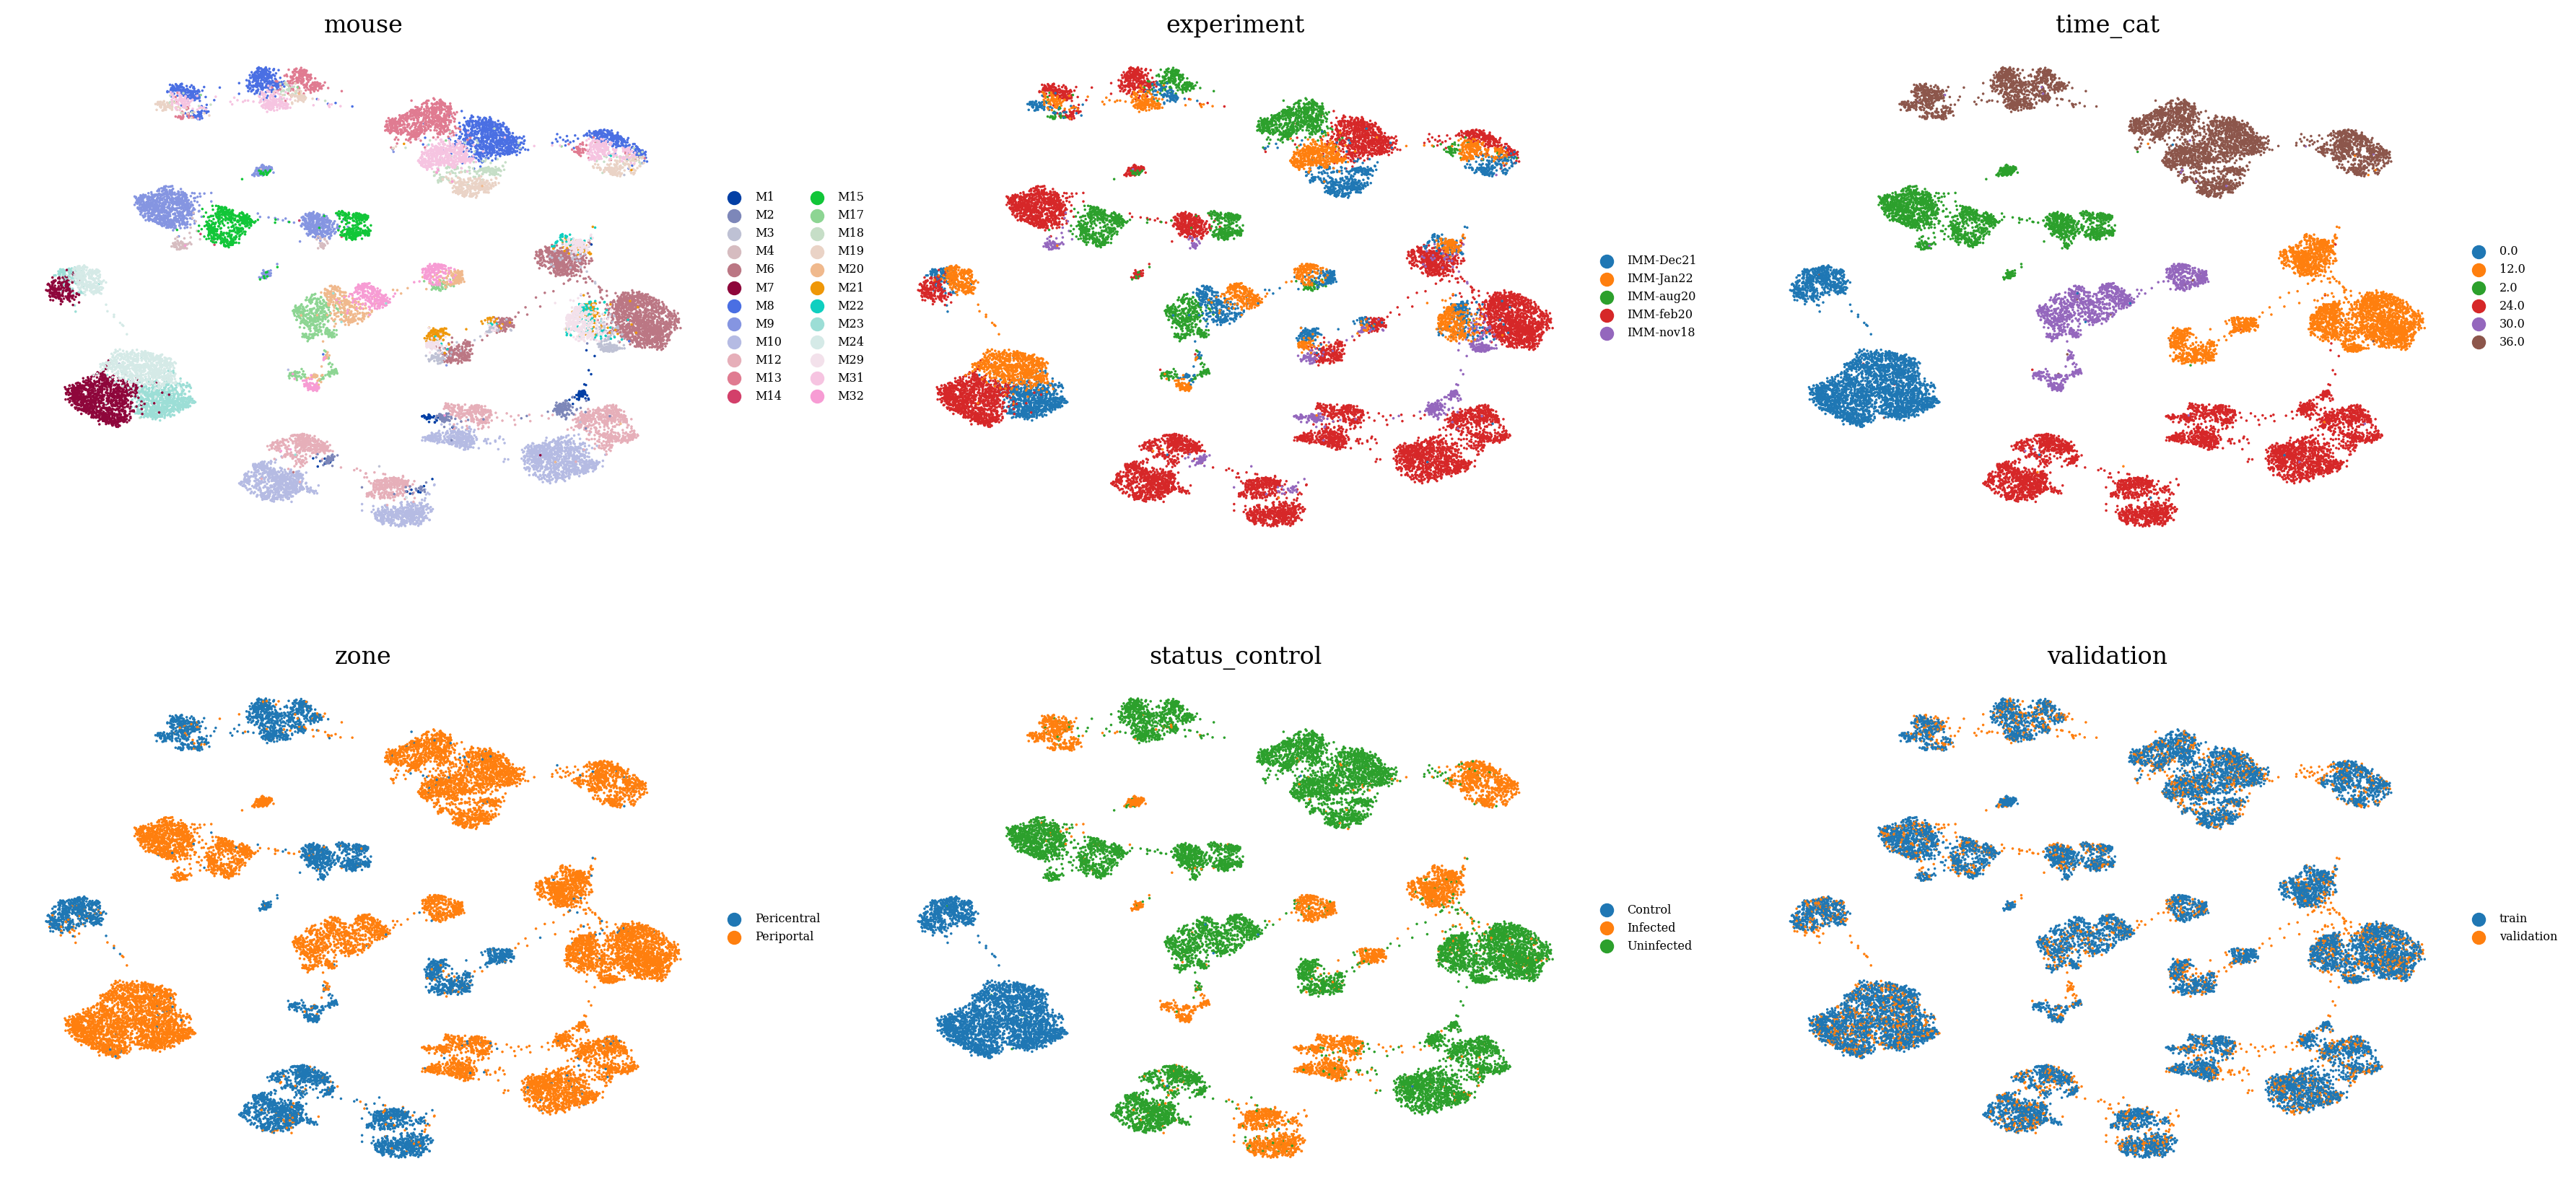

In [14]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control', "validation"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

## Preds

In [15]:
adata_main = ad.read_h5ad(adata_file_path)
adata_main.obs["ood"] = choices_bool.astype(int).astype(str)
adata_main.obs["ood"] = adata_main.obs["ood"].astype("category")

adata_ood = adata_main[adata_main.obs["ood"] == "1"].copy()

In [16]:
# latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main)[:, DM.configurations.get_by_obs_key("age").reserved_latent_indices], obs=adata_main.obs.copy())
latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main), obs=adata_main.obs.copy())
sc.pp.neighbors(latent_main)
sc.tl.umap(latent_main)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


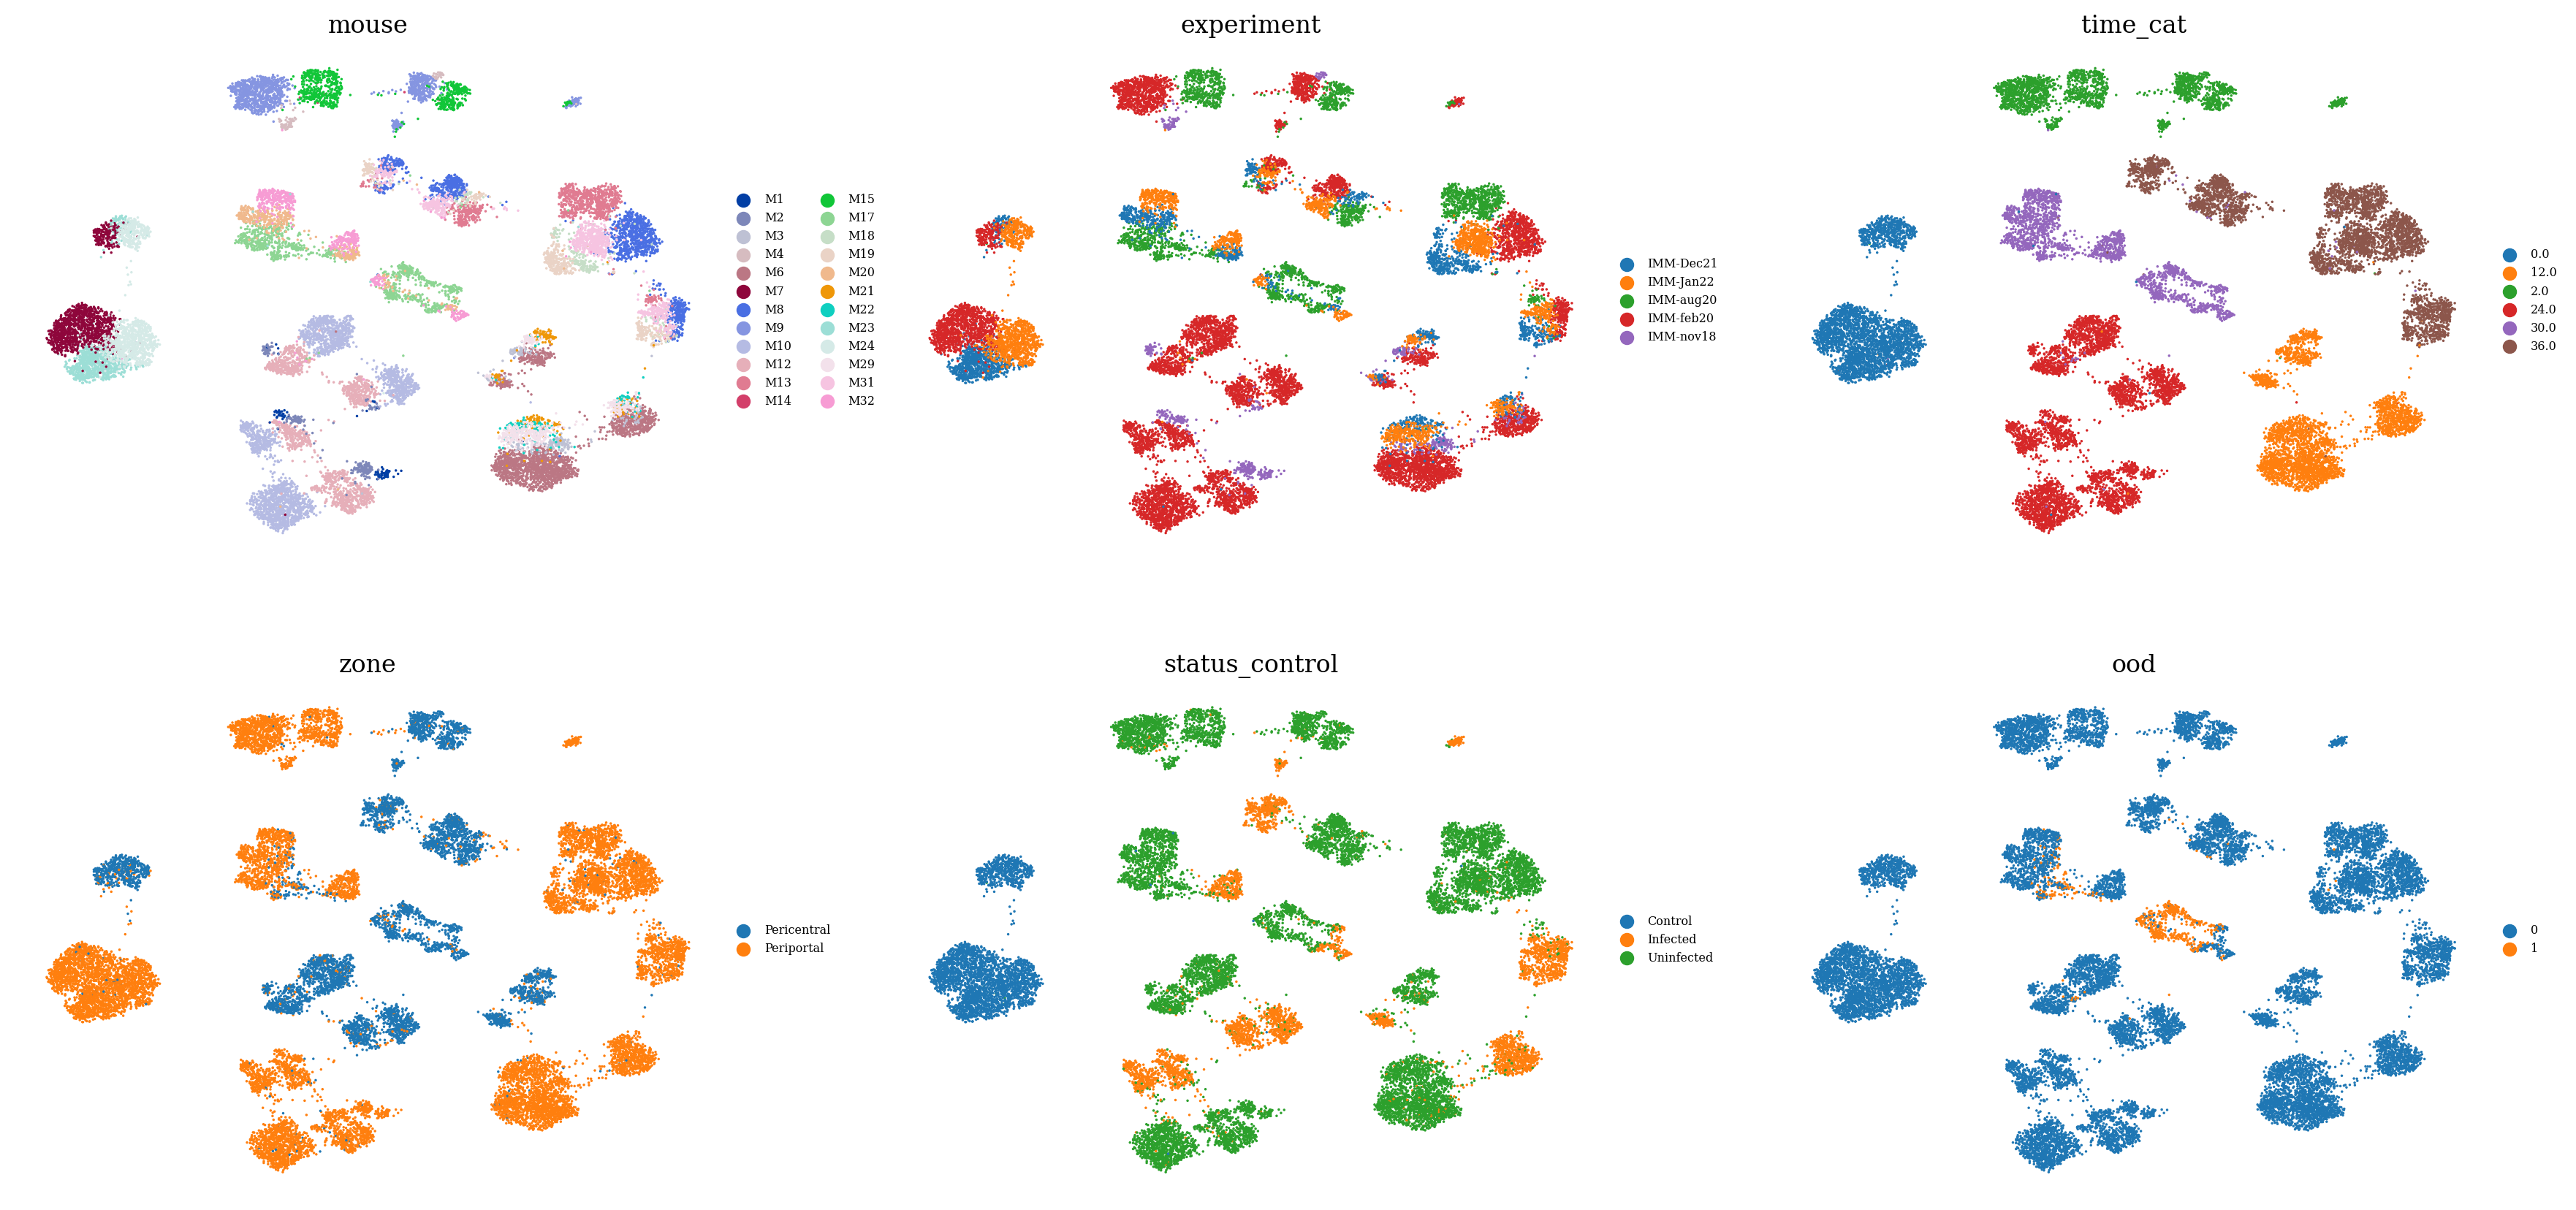

In [17]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_main, 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control', "ood"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [18]:
k = "status_control"

latent = ad.AnnData(X=vae.get_latent_representation(adata)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)

latent_ood = ad.AnnData(X=vae.get_latent_representation(adata_ood)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata_ood.obs.copy())
sc.pp.neighbors(latent_ood)
sc.tl.umap(latent_ood)

label_transfer(latent, latent_ood, cluster_list=[k], neighbors_count=30)
predicted = latent_ood.obs[f"transf_{k}"].astype(str).values
true = latent_ood.obs[k].astype(str).values

metrics = {}
metrics['accuracy'] = sklearn.metrics.accuracy_score(true, predicted)
metrics['precision_macro'] = sklearn.metrics.precision_score(true, predicted, average='macro', zero_division=0)
metrics['recall_macro'] = sklearn.metrics.recall_score(true, predicted, average='macro', zero_division=0)
metrics['f1_score_macro'] = sklearn.metrics.f1_score(true, predicted, average='macro', zero_division=0)
metrics['precision_micro'] = sklearn.metrics.precision_score(true, predicted, average='micro', zero_division=0)
metrics['recall_micro'] = sklearn.metrics.recall_score(true, predicted, average='micro', zero_division=0)
metrics['f1_score_micro'] = sklearn.metrics.f1_score(true, predicted, average='micro', zero_division=0)
metrics['precision_weighted'] = sklearn.metrics.precision_score(true, predicted, average='weighted', zero_division=0)
metrics['recall_weighted'] = sklearn.metrics.recall_score(true, predicted, average='weighted', zero_division=0)
metrics['f1_score_weighted'] = sklearn.metrics.f1_score(true, predicted, average='weighted', zero_division=0)
metrics['confusion_matrix'] = sklearn.metrics.confusion_matrix(true, predicted)

t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))
print("F1 Weighted:", sklearn.metrics.f1_score(t, dummy_predictions, average='weighted', zero_division=0))
print()
t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))
print("F1 Weighted:", sklearn.metrics.f1_score(t, dummy_predictions, average='weighted', zero_division=0))
print()
metrics

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


Baseline Accuracy: 0.6161234451267517
F1 Weighted: 0.4697761186245088

Baseline Accuracy: 0.4496929617383089


F1 Weighted: 0.4500181619940963



{'accuracy': 0.8274706867671692,
 'precision_macro': 0.3333333333333333,
 'recall_macro': 0.2758235622557231,
 'f1_score_macro': 0.30186373357775736,
 'precision_micro': 0.8274706867671692,
 'recall_micro': 0.8274706867671692,
 'f1_score_micro': 0.8274706867671693,
 'precision_weighted': 1.0,
 'recall_weighted': 0.8274706867671692,
 'f1_score_weighted': 0.9055912007332722,
 'confusion_matrix': array([[  0,   0,   0],
        [  0,   0,   0],
        [  1, 102, 494]])}

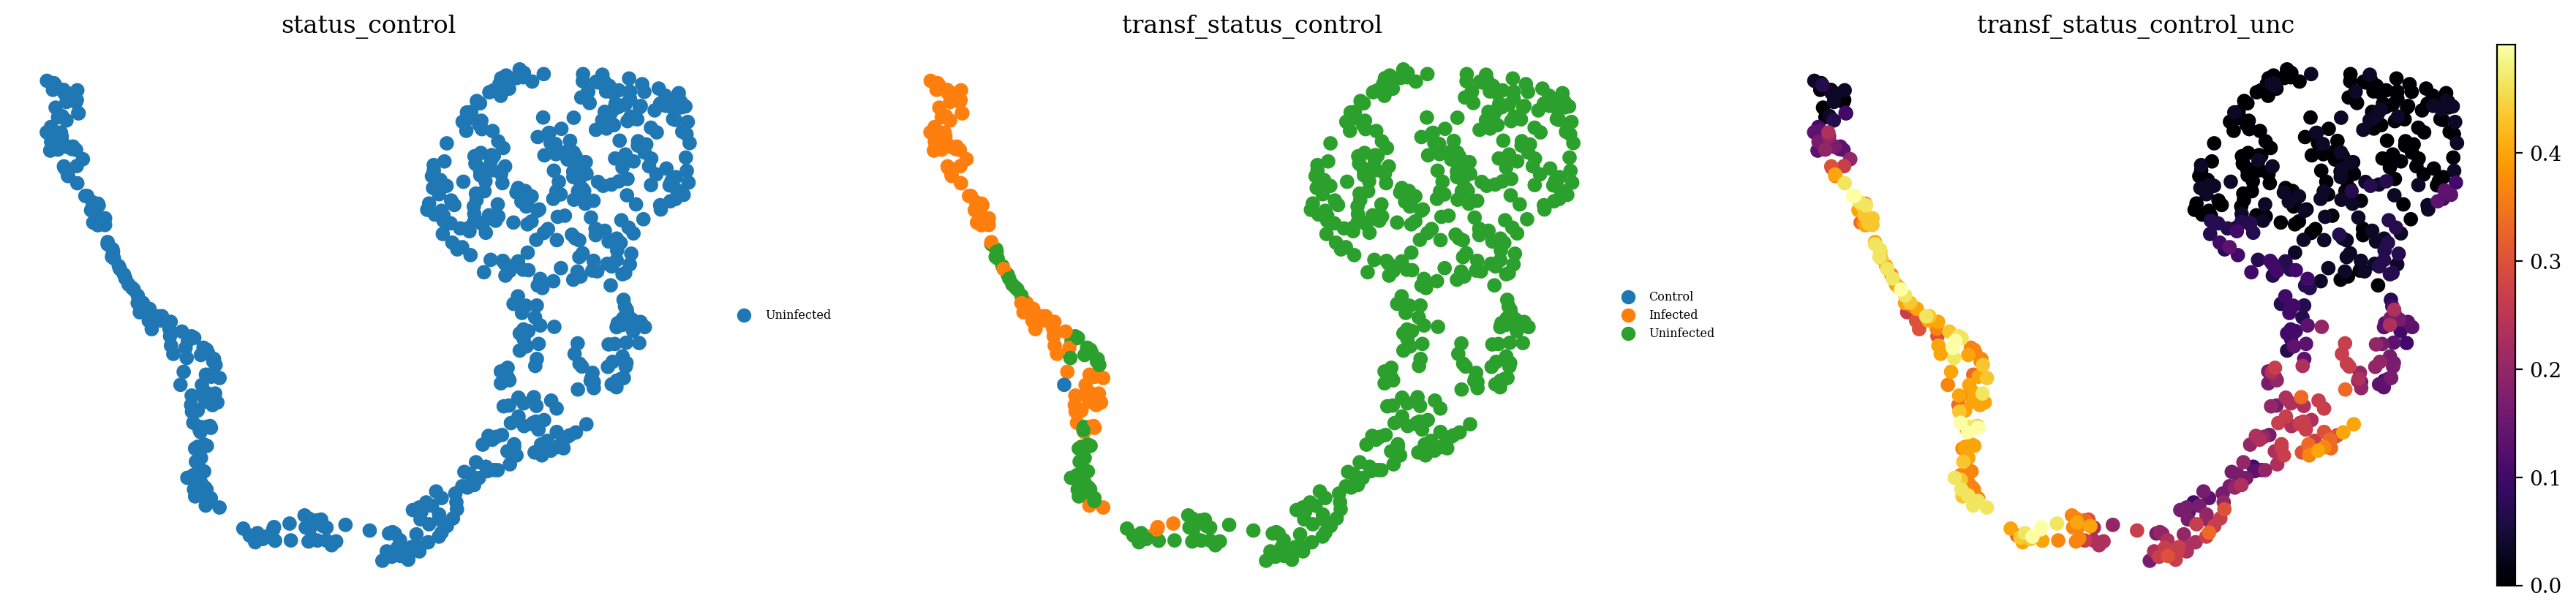

In [19]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_ood, 
        color=[k, f"transf_{k}", f"transf_{k}_unc"], 
        ncols=4,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [20]:
k = "status_control"

latent = ad.AnnData(X=vae.get_latent_representation(adata), obs=adata.obs.copy())
sc.pp.neighbors(latent)

latent_ood = ad.AnnData(X=vae.get_latent_representation(adata_ood), obs=adata_ood.obs.copy())
sc.pp.neighbors(latent_ood)
sc.tl.umap(latent_ood)

label_transfer(latent, latent_ood, cluster_list=[k], neighbors_count=30)
predicted = latent_ood.obs[f"transf_{k}"].astype(str).values
true = latent_ood.obs[k].astype(str).values

metrics = {}
metrics['accuracy'] = sklearn.metrics.accuracy_score(true, predicted)
metrics['precision_macro'] = sklearn.metrics.precision_score(true, predicted, average='macro', zero_division=0)
metrics['recall_macro'] = sklearn.metrics.recall_score(true, predicted, average='macro', zero_division=0)
metrics['f1_score_macro'] = sklearn.metrics.f1_score(true, predicted, average='macro', zero_division=0)
metrics['precision_micro'] = sklearn.metrics.precision_score(true, predicted, average='micro', zero_division=0)
metrics['recall_micro'] = sklearn.metrics.recall_score(true, predicted, average='micro', zero_division=0)
metrics['f1_score_micro'] = sklearn.metrics.f1_score(true, predicted, average='micro', zero_division=0)
metrics['precision_weighted'] = sklearn.metrics.precision_score(true, predicted, average='weighted', zero_division=0)
metrics['recall_weighted'] = sklearn.metrics.recall_score(true, predicted, average='weighted', zero_division=0)
metrics['f1_score_weighted'] = sklearn.metrics.f1_score(true, predicted, average='weighted', zero_division=0)
metrics['confusion_matrix'] = sklearn.metrics.confusion_matrix(true, predicted)

t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))
print("F1 Weighted:", sklearn.metrics.f1_score(t, dummy_predictions, average='weighted', zero_division=0))
print()
t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))
print("F1 Weighted:", sklearn.metrics.f1_score(t, dummy_predictions, average='weighted', zero_division=0))
print()
metrics

Baseline Accuracy: 0.6161234451267517
F1 Weighted: 0.4697761186245088

Baseline Accuracy: 0.44864325827953605


F1 Weighted: 0.44912672316548613



{'accuracy': 0.6683417085427136,
 'precision_macro': 0.5,
 'recall_macro': 0.3341708542713568,
 'f1_score_macro': 0.4006024096385542,
 'precision_micro': 0.6683417085427136,
 'recall_micro': 0.6683417085427136,
 'f1_score_micro': 0.6683417085427136,
 'precision_weighted': 1.0,
 'recall_weighted': 0.6683417085427136,
 'f1_score_weighted': 0.8012048192771084,
 'confusion_matrix': array([[  0,   0],
        [198, 399]])}